In [16]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
# path = '/home/jason/project/EmptyNumberDetection/end_train_datas/recordings/test.wav'
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5fcee882e9e8535645b89760_18616505188.wav'


wav = wave.open(path)
print("采样率：", wav.getframerate())
print("总帧数：{}", wav.getnframes())
print("时间：{}", wav.getnframes()/wav.getframerate())





采样率： 8000
总帧数：{} 0
时间：{} 0.0


采样率： 8000
总帧数： 0
时间： 0.0
(0,)
8000


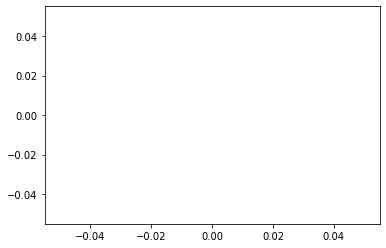

In [17]:
# 文件的导入
# path = '/home/jason/project/EmptyNumberDetection/end_train_datas/主叫停机_10000/slice_media_dir/5fabb02de9e853717abb68d3_15889433008.wav'
# path = '/home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000/slice_media_dir/5f9f5997e9e853635a3baff7_13371819997.wav'
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000/slice_media_dir/5f983069e9e853635a2424c2_13873002023.wav'
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000/slice_media_dir/5fea9820e9e8532098ee9533_18061286677'
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb18186938c65c30a28b45_13829418366.wav'
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5fcee882e9e8535645b89760_18616505188.wav'

wav = wave.open(path)
print("采样率：", wav.getframerate())
print("总帧数：", wav.getnframes())
print("时间：", wav.getnframes()/wav.getframerate())

data, sr = librosa.load(path, sr=None)  # 文件导入。sr=None代表使用原始文件的采样率，也可自己设置进行重采样。(重采样比较耗时）
print(data.shape)
print(sr)
plt.plot(data, "-")  # 画图看看data数据到底长啥样
plt.show()


In [114]:
6411 / 8000

0.801375

In [6]:
data.shape

(479418,)

In [20]:
len(data) / sr

59.92725

In [80]:
# 维度（40， _）  第一个维度代表频域， 第二个维度代表时域，故第二个维度大小跟音频长度有关，第一个维度大小可自行设置（n_mfcc)
mfcc = librosa.feature.mfcc(data, sr=sr, n_mfcc=40)  # 以np数组形式返回梅尔频率倒谱系数

# 维度（256， _）
mel = librosa.feature.melspectrogram(data, sr=sr, n_fft=1024, n_mels=256) 
mel = librosa.power_to_db(mel).T  # Log-Mel Spectrogram特征(最常用）
print(mel.shape)
print(mfcc.shape)

(937, 256)
(40, 937)


In [86]:
data.shape

(479418,)

In [83]:
mfcc = mfcc[10:]

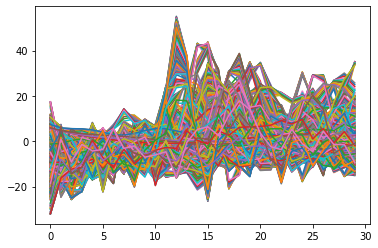

In [84]:
plt.plot(mfcc, "-")  # 画图看看data数据到底长啥样
plt.show()

In [6]:
mfcc = librosa.feature.mfcc(data, sr=sr)  # 以np数组形式返回梅尔频率倒谱系数
mel = librosa.power_to_db(mel).T
print(mfcc.shape)
print(mel.shape)

(20, 937)
(256, 937)


In [3]:
import json
import pandas as pd

class DataLoader(object):
    def __init__(self, ignore_index=-100, max_length=512):
        self.ignore_index = ignore_index
    
    def get_mfcc_feature(self, data, sr):
        tmp_feature = librosa.feature.mfcc(data, sr=sr, n_mfcc=20)  # 默认n_mfcc=20
        # mel = librosa.feature.melspectrogram(data, sr=sr, n_fft=1024, n_mels=256)  # 计算Mel scaled 频谱
        # mel = librosa.power_to_db(mel).T  #  功率转dB
        return tmp_feature
        
    def load_voice(self, fp):
        # 下载音频数据
        # 先只考虑mfcc
        data, sr = librosa.load(path=fp, sr=None)

        return data, sr
    
    def cut_voice(self, data, sr, hit_time, duration=5):
        start_time = int((hit_time - duration) * sr)
        end_time = int(hit_time * sr)
        tmp_data = data[start_time : end_time]
        return tmp_data
        
    def load_datas(self, data_dir, is_train: bool = True):
        if is_train:
            tmp_file = data_dir + '/wrap_output.txt'
            print('fp: ', tmp_file)
            id_ = []
            text = []
            label = []
            hit_time = []
            with open(tmp_file, 'r') as fr:
                for idx, i in enumerate(fr):
                    tmp = json.loads(i)
                    id_.append(tmp.get('_id'))
                    text.append(tmp.get('asr_text'))
                    label.append(tmp.get('call_status'))
                    hit_time.append(float(tmp.get('detect_result_hit_duration', 0)) / 1000)
        mfcc = []
        mfcc_target = []  # 命中关键词前5秒录音
        duration = []
        for idx, i in enumerate(id_):
            tmp_file = data_dir + '/slice_media_dir/' + str(i) + '.wav'
            
            try:
                tmp_data, tmp_sr = self.load_voice(tmp_file)
                tmp_mfcc = self.get_mfcc_feature(tmp_data, tmp_sr)
                tmp_duration = len(tmp_data) / tmp_sr
            except:
                print('error: cannot find file', idx, tmp_file)
                tmp_duration = 0
                tmp_mfcc = None
            
            duration.append(tmp_duration)
            mfcc.append(tmp_mfcc)
            '''
            # 获得击中及前5秒特征数据
            print(hit_time[idx])
            tmp_data = self.cut_voice(tmp_data, tmp_sr, hit_time[idx], duration=5)
            print(tmp_data.shape, tmp_sr)
            tmp_mfcc_hit = self.get_mfcc_feature(tmp_data, tmp_sr)
            
            
            mfcc_target.append(tmp_mfcc_hit)
            '''
            
        df = pd.DataFrame(data={'_id': id_, 'text': text, 'label': label, 'hit_time': hit_time, 'features': mfcc, 'duration': duration})
        # df = df.dropna(subset=['features'])
        return df

                  precision    recall  f1-score   support

           0       0.97      0.98      0.97      3930
           1       0.99      1.00      0.99        84
           2       0.91      0.94      0.92       412
           3       0.98      0.98      0.98      1648
           4       0.95      0.98      0.96       696
           5       0.89      1.00      0.94       141
           6       0.83      1.00      0.91        10
           7       0.67      0.87      0.76       100
           8       0.77      0.98      0.86       212
           9       0.78      0.87      0.82       354
          10       0.96      0.88      0.92      2481

    accuracy                           0.95     10068
   macro avg       0.88      0.95      0.91     10068
weighted avg       0.95      0.95      0.95     10068

In [295]:
kwd_online = {
    '占线': ['通话中', '用户正忙', '网络忙', '用户正在通话', '电话正在通话', '线路忙', '忙线中', 'you dialed is busy'], 
    '主叫停机': ['您的手机号码已被暂停', '暂时无法呼出', '您的手机号码已暂停服务', '您的电话已经被停机', '您的电话已欠费', '您的手机号码已暂停', '你的电话已欠费', '您的电话已停机', '话机欠费'], 
    '被叫停机': ['拨打的电话已停机', '拨打的号码已过期', '拨打的用户已暂停服务', '您拨叫的用户已停机', '拨叫的用户的停机', '拨打的用户已停机', '用户已停机'], 
    '空号': ['空号', '号码不正确', '号码不存在', '号码有误'], 
    '关机': ['关机', '不在服务区', 'power'],
    '未启用语音': ['未开通语音通话功能'], 
    '呼叫限制': ['用户已呼入限制', '用户已呼入限', '以呼入限制', '呼叫受限', '请勿越前使用', '拨打的号码是靓号', '黑名单号码', '超出呼叫次数限制', '靓号禁止', '禁止拨打', '是靓号'],
    '语音信箱': ['启用了语音信箱', '游戏留言', '语音信箱', '已启用联通秘书服务','已使用来电管家业务'], 
    '来电提醒': ['来电提醒', '已启动通讯助理', '已启动通信助理'], 
    '无法接通': ['暂时无法接通', '无法接听', '目前无法接通'], 
    '无人接听': ['暂时无人接听', '您拨叫的用户无应答'], 
}

kwd = {
        '占线': ['通话中', '用户正忙', '网络忙', '用户正在通话', '电话正在通话', '线路忙', '忙线中', 'you dialed is busy'], 
        '主叫停机': ['您的手机号码已被暂停', '暂时无法呼出', '您的手机号码已暂停服务', '您的电话已经被停机', '您的电话已欠费', '您的手机号码已暂停', '你的电话已欠费', '您的电话已停机', '话机欠费'], 
        '被叫停机': ['拨打的电话已停机', '拨打的号码已过期', '拨打的用户已暂停服务', '播打的用户已暂停服务', '用户已暂停服务', '您拨叫的用户已停机', '拨叫的用户的停机', '拨打的用户已停机', '用户已停机', '拨打的号码已停机', '拨打的用户未交电话费', '拨打的电话是停机', '您拨的电话已停机', '您拨打的号码已过期'], 
        '空号': ['空号', '号码不正确', '号码不存在', '号码有误', '核对后再拨'], 
        '关机': ['关机', '不在服务区', 'power'], 
        '未启用语音': ['未开通语音通话功能', '您的语音通话功能', '10086语音通话功能'], 
        '语音信箱': ['启用了语音信箱', '游戏留言', '语音信箱', '已启用联通秘书服务','已使用来电管家业务', '请按一留言', '留言请按一', '如需留言', '请您留言', '留言'], 
        '无法接通': ['暂时无法接通', '无法接听', '无法接通', 'can not be connected'], 
        '无人接听': ['暂时无人接听', '您拨叫的用户无应答', '无人接听', '不方便接听'], 
        '来电提醒': ['来电提醒', '已启动通讯助理', '已启动通信助理', '提醒服务来电信息', '漏话提醒', '已转入来电', '已开通乐话提醒', '短信方式通知', '短信方式告知'], 
        '呼叫限制': ['请勿越前使用', '用户已呼入限制', '用户已呼入限', '以呼入限制', '呼叫受限', '拨打的号码是靓号', '尚未开通国际长途', '拨打的用户尚未登录', '黑名单号码', '主叫号码错误', '超出呼叫次数限制', '靓号禁止', '禁止拨打', '是靓号']
      }

# 这个label是带有顺序权重的!
label2idx_old = {
                '占线': 0, 
                '主叫停机': 1, 
                '被叫停机': 2, 
                '空号': 3, 
                '关机': 4, 
                '未启用语音': 5, 
                '语音信箱': 6, 
                '无法接通': 7, 
                '无人接听': 8, # 无法判断类全归入无人接听
                '来电提醒': 9, 
                '呼叫限制': 10, 
                '有录音没文字类': 11 # 纯音乐, 只有嘟嘟嘟
            }

label2idx = {
                '占线': 0, 
                '主叫停机': 1, 
                '被叫停机': 2, 
                '空号': 3, 
                '关机': 4, 
                '呼叫限制': 5, 
                '未启用语音': 6, 
                '语音信箱': 7, 
                '来电提醒': 8, 
                '无法接通': 9, 
                '无人接听': 10, # 无法判断类全归入无人接听
                '有录音没文字类': 11 # 纯音乐, 只有嘟嘟嘟
            }
label_rank = [0, 1, 2, 3, 4, 10, 5, 6, 9, 7, 8, 11]

raw2idx_old = {
    3: 8, 4: 10, 5: 4, 6: 3, 8: 9, 9: 0, 15: 6, 16: 1, 17: 2, 18: 5, 10:8, 14:8
}
# 新版线上,线下模型标签映射
raw2idx = {
    3: 10, 4: 5, 5: 4, 6: 3, 8: 8, 9: 0, 15: 7, 16: 1, 17: 2, 18: 6, 10:11, 14:11
}

oldlabel2newlabel = {0:0, 1:1, 2:2, 3:3, 4:4, 5:6, 6:7, 7:9, 8:10, 9:8, 10:5, 11:11}

In [4]:
# df1 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/主叫停机_10000')
# df2 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000')
# df3 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000')
# df4 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/呼叫限制_10000')
# df5 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/无人接听_10000')
# df6 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/_10000')
# df7 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000')
# df8 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000')
# df9 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000')
# df10 = dl.load_datas('/home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000')
dir_path = '/home/jason/project/EmptyNumberDetection/end_train_datas/20191001_20000'
dl = DataLoader()

paths = ['主叫停机_10000', 
         '关机_10000', 
         '占线_10000', 
         '呼叫限制_10000',  
         '暂时无法接听_10000', 
         '未启用语音_10000', 
         '来电提醒_10000', 
         '空号_10000', 
         '被叫停机_10000', 
         '语音信箱_10000']
dir_path = '/home/jason/project/EmptyNumberDetection/end_train_datas/'
df = pd.DataFrame()
for tmp_path in paths:
    tmp_path = dir_path + tmp_path
    print('loading: ', tmp_path)
    tmp_df = dl.load_datas(tmp_path)
    df = df.append(tmp_df)


loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/主叫停机_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/主叫停机_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/呼叫限制_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/呼叫限制_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/暂时无法接听_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/暂时无法接听_10000/wrap_output.txt


/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1224
  n_fft, y.shape[-1]
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1375
  n_fft, y.shape[-1]
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1532
  n_fft, y.shape[-1]
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1280
  n_fft, y.shape[-1]
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1166
  n_fft, y.shape[-1]
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: User

loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/未启用语音_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/未启用语音_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/来电提醒_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/来电提醒_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/空号_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/空号_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/被叫停机_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/被叫停机_10000/wrap_output.txt
loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/语音信箱_10000
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/语音信箱_10000/wrap_output.txt


In [21]:
#额外201910和general数据集
dl = DataLoader()

paths = ['test_datas', 
         # '20191001_20000', 
         # 'general_15000',
        ]
dir_path = '/home/jason/project/EmptyNumberDetection/end_train_datas/'
df = pd.DataFrame()
for tmp_path in paths:
    tmp_path = dir_path + tmp_path
    print('loading: ', tmp_path)
    tmp_df = dl.load_datas(tmp_path)
    df = df.append(tmp_df)

loading:  /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas
fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/wrap_output.txt
error: cannot find file 0 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13728731884.wav
error: cannot find file 3 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13149913126.wav
error: cannot find file 4 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3948e9e8532098024759_18988965053.wav
error: cannot find file 5 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_18926515683.wav
error: cannot find file 7 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b726938c6661ecd8bdb_15162861888.wav
error: cannot find file 9 /home/jason/project/EmptyNumberDetection/end_train_d

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=0
  n_fft, y.shape[-1]


error: cannot find file 20 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13190017709.wav
error: cannot find file 21 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec33f1e9e8532098fd09e0_13072997533.wav
error: cannot find file 22 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_13061460615.wav
error: cannot find file 23 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13204022621.wav
error: cannot find file 24 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_15507736672.wav
error: cannot find file 26 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13798332958.wav
error: cannot find file 27 /home/jason/project/EmptyNumberDetection/end_train_datas/test

error: cannot find file 112 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_15955595608.wav
error: cannot find file 114 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13204048665.wav
error: cannot find file 115 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_18863986023.wav
error: cannot find file 117 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec1fc4e9e8532098fb2392_13925960789.wav
error: cannot find file 119 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13204044710.wav
error: cannot find file 120 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_15899775110.wav
error: cannot find file 122 /home/jason/project/EmptyNumberDetection/end_train_dat

error: cannot find file 232 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13537125916.wav
error: cannot find file 233 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13802534589.wav
error: cannot find file 234 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13994232529.wav
error: cannot find file 238 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13951612551.wav
error: cannot find file 240 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_02163291559.wav
error: cannot find file 241 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13581601224.wav
error: cannot find file 242 /home/jason/project/EmptyNumberDetection/end_train_dat

error: cannot find file 347 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13702016090.wav
error: cannot find file 348 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13802454638.wav
error: cannot find file 351 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13801966546.wav
error: cannot find file 355 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea90d2e9e8532098ede316_13106675138.wav
error: cannot find file 359 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13486148447.wav
error: cannot find file 361 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_03746108195.wav
error: cannot find file 362 /home/jason/project/EmptyNumberDetection/end_train_dat

error: cannot find file 469 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13809065510.wav
error: cannot find file 470 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13951584924.wav
error: cannot find file 471 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13929989591.wav
error: cannot find file 473 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_13137124458.wav
error: cannot find file 474 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_076928682236.wav
error: cannot find file 477 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6e91d6938c6661eb14c8a_18639021761.wav
error: cannot find file 479 /home/jason/project/EmptyNumberDetection/end_train_da

error: cannot find file 612 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13916398888.wav
error: cannot find file 613 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13810137211.wav
error: cannot find file 615 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13064752432.wav
error: cannot find file 617 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae3a9e9e8532098f3b7c6_13105584144.wav
error: cannot find file 618 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2bd06938c6661ed23d04_13655175988.wav
error: cannot find file 619 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_075583696957.wav
error: cannot find file 620 /home/jason/project/EmptyNumberDetection/end_train_da

error: cannot find file 724 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18103464848.wav
error: cannot find file 727 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed948de9e853209807fd07_15989488863.wav
error: cannot find file 730 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febea5b6938c6661ec9c5a3_13932694922.wav
error: cannot find file 731 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe41ee9e8532098f7e323_15055526901.wav
error: cannot find file 732 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feab3046938c6661ec1b0aa_15822028409.wav
error: cannot find file 734 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe4305ee9e8535a53aca636_13921119208.wav
error: cannot find file 736 /home/jason/project/EmptyNumberDetection/end_train_dat

error: cannot find file 850 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13605150066.wav
error: cannot find file 856 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_13116058865.wav
error: cannot find file 858 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea83466938c6661ebdeded_075725331038.wav
error: cannot find file 860 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18530883169.wav
error: cannot find file 863 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_13601816936.wav
error: cannot find file 868 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb10e9e8532098f71611_15930119539.wav
error: cannot find file 873 /home/jason/project/EmptyNumberDetection/end_train_da

error: cannot find file 1009 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_02089623019.wav
error: cannot find file 1012 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3f8b6938c6661ed4445f_15010086122.wav
error: cannot find file 1013 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_15989790741.wav
error: cannot find file 1014 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe000e8e9e8535a5389db08_13060988729.wav
error: cannot find file 1015 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_13698968863.wav
error: cannot find file 1016 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe957086938c6661eb766e4_13316907999.wav
error: cannot find file 1017 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 1152 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_15999634095.wav
error: cannot find file 1155 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13701277637.wav
error: cannot find file 1156 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed830de9e8530d7945d25f_15637699777.wav
error: cannot find file 1158 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6a936938c6661ed5d509_18925706253.wav
error: cannot find file 1160 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec1fc4e9e8532098fb2392_15616520867.wav
error: cannot find file 1161 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe97a64e9e8532098e72645_18516195580.wav
error: cannot find file 1162 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 1293 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_15552975280.wav
error: cannot find file 1296 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13554767513.wav
error: cannot find file 1297 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed4b6be9e853209803e22f_075786619386.wav
error: cannot find file 1299 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc5c02be9e85368d4bf8186_13814781468.wav
error: cannot find file 1301 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_18929338853.wav
error: cannot find file 1306 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3c5f6938c6661ed3f66a_15889778621.wav
error: cannot find file 1309 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 1434 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_02488151644.wav
error: cannot find file 1435 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15286831710.wav
error: cannot find file 1436 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6e91d6938c6661eb14c8a_13818729611.wav
error: cannot find file 1437 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed7b9ce9e853209805ef89_13825677796.wav
error: cannot find file 1439 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feafdb86938c6661ec7042c_13951109819.wav
error: cannot find file 1440 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18203412036.wav
error: cannot find file 1442 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 1556 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3fbb6938c6661ed4493b_13879238032.wav
error: cannot find file 1563 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13825242496.wav
error: cannot find file 1569 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_13539010031.wav
error: cannot find file 1570 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea83466938c6661ebdeded_076088555358.wav
error: cannot find file 1572 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13128723120.wav
error: cannot find file 1573 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_15151445936.wav
error: cannot find file 1575 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 1709 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13918781836.wav
error: cannot find file 1710 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13910177576.wav
error: cannot find file 1714 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_15067435402.wav
error: cannot find file 1716 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_18333604174.wav
error: cannot find file 1717 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13668911920.wav
error: cannot find file 1726 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_045186706802.wav
error: cannot find file 1727 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 1831 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdc617be9e8535a538138d7_18920625518.wav
error: cannot find file 1832 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_18323265791.wav
error: cannot find file 1834 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_13914337325.wav
error: cannot find file 1839 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f1c8e9e8532098e06ae7_15920551265.wav
error: cannot find file 1843 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_15723721332.wav
error: cannot find file 1848 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18028513272.wav
error: cannot find file 1852 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 1989 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_13407235199.wav
error: cannot find file 1991 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2c0666938c67b0896435c_15573358173.wav
error: cannot find file 1994 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15965455658.wav
error: cannot find file 1996 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_13356119789.wav
error: cannot find file 1998 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_17701868217.wav
error: cannot find file 2000 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febef36e9e8532098f8e922_13928825949.wav
error: cannot find file 2001 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 2139 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13954661899.wav
error: cannot find file 2140 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe1d1366938c67b0891f6bb_13726771228.wav
error: cannot find file 2141 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13250624465.wav
error: cannot find file 2142 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_15013255168.wav
error: cannot find file 2144 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febd41a6938c6661ec7d9ac_13902331479.wav
error: cannot find file 2145 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdc617be9e8535a538138d7_15364905535.wav
error: cannot find file 2150 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 2295 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6e90e9e853209804c732_13752186273.wav
error: cannot find file 2296 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9554ee9e8532098e5fe8a_18501758459.wav
error: cannot find file 2298 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea9820e9e8532098ee9533_13004575578.wav
error: cannot find file 2299 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13724851069.wav
error: cannot find file 2300 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed47dee9e8532098039cf6_13714109846.wav
error: cannot find file 2301 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_18566509517.wav
error: cannot find file 2303 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 2434 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_045151756868.wav
error: cannot find file 2435 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18824156040.wav
error: cannot find file 2439 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f2156938c6661eb1b201_13711302131.wav
error: cannot find file 2440 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13922247620.wav
error: cannot find file 2441 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_17327081991.wav
error: cannot find file 2445 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13822258936.wav
error: cannot find file 2448 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 2605 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_13761017688.wav
error: cannot find file 2607 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_13590717289.wav
error: cannot find file 2612 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13222983292.wav
error: cannot find file 2614 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_02083842147.wav
error: cannot find file 2615 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_15822972619.wav
error: cannot find file 2616 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe44d09e9e8535a53b04e77_16620908438.wav
error: cannot find file 2619 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 2749 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13905460618.wav
error: cannot find file 2750 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6e91d6938c6661eb14c8a_13901813848.wav
error: cannot find file 2752 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6a5ae9e8535a53850321_13738201286.wav
error: cannot find file 2754 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2afa1e9e8535a539fb9e1_13821223225.wav
error: cannot find file 2755 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_051265975178.wav
error: cannot find file 2756 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_18285550212.wav
error: cannot find file 2757 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 2855 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_045184663581.wav
error: cannot find file 2856 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed35f2e9e853209801e9dd_18671574567.wav
error: cannot find file 2859 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe992666938c6661ebad7cf_13121912202.wav
error: cannot find file 2862 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13902236752.wav
error: cannot find file 2869 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_18028004410.wav
error: cannot find file 2872 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18612166918.wav
error: cannot find file 2874 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 3000 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa3906938c6661ec10516_15914483318.wav
error: cannot find file 3002 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec13a6e9e8532098fa4ef8_15900762442.wav
error: cannot find file 3003 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec6c666938c6661ed14938_13806823888.wav
error: cannot find file 3006 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_13934780613.wav
error: cannot find file 3007 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_13856072941.wav
error: cannot find file 3008 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_13405172389.wav
error: cannot find file 3009 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3155 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13928871076.wav
error: cannot find file 3156 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_18513373273.wav
error: cannot find file 3157 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_18285156609.wav
error: cannot find file 3162 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54fab6938c6661ea7f5ab_13711055374.wav
error: cannot find file 3165 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_18128297954.wav
error: cannot find file 3166 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed479b6938c6661ed4f614_18635773103.wav
error: cannot find file 3167 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3280 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13590175112.wav
error: cannot find file 3283 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_18916658815.wav
error: cannot find file 3286 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_07502880211.wav
error: cannot find file 3294 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9ee94e9e8532098ec5a97_18551179004.wav
error: cannot find file 3295 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13221716879.wav
error: cannot find file 3297 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_13906628286.wav
error: cannot find file 3299 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3420 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_13774074465.wav
error: cannot find file 3425 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13214237233.wav
error: cannot find file 3429 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_07732150650.wav
error: cannot find file 3431 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13214231567.wav
error: cannot find file 3434 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec1fc4e9e8532098fb2392_18718731580.wav
error: cannot find file 3435 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec1fc4e9e8532098fb2392_13695220877.wav
error: cannot find file 3437 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3523 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_13818507874.wav
error: cannot find file 3524 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18027160716.wav
error: cannot find file 3532 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13897638565.wav
error: cannot find file 3533 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe4e6e9e8532098f7f528_13792671360.wav
error: cannot find file 3540 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_13501576366.wav
error: cannot find file 3542 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe992666938c6661ebad7cf_13824469026.wav
error: cannot find file 3543 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3657 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13761908827.wav
error: cannot find file 3659 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc9e21e6938c62b5c217834_15279995386.wav
error: cannot find file 3661 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_03746108087.wav
error: cannot find file 3664 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18334803318.wav
error: cannot find file 3665 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54fab6938c6661ea7f5ab_13712170752.wav
error: cannot find file 3666 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_03746108182.wav
error: cannot find file 3667 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3740 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_076921663156.wav
error: cannot find file 3741 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_075588844440.wav
error: cannot find file 3743 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea83466938c6661ebdeded_15986641218.wav
error: cannot find file 3749 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe938336938c6661eb4bf8b_15518185277.wav
error: cannot find file 3751 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed4b6be9e853209803e22f_18700512992.wav
error: cannot find file 3757 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13951824662.wav
error: cannot find file 3759 /home/jason/project/EmptyNumberDetection/end_

error: cannot find file 3869 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13916698986.wav
error: cannot find file 3872 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3739e9e8532098020ceb_13962397749.wav
error: cannot find file 3874 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed479b6938c6661ed4f614_18860258602.wav
error: cannot find file 3877 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13681096735.wav
error: cannot find file 3879 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_02152708492.wav
error: cannot find file 3880 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13713247160.wav
error: cannot find file 3881 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 3983 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13683245363.wav
error: cannot find file 3985 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13611594439.wav
error: cannot find file 3986 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_15000352898.wav
error: cannot find file 3987 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd9d1a8e9e8535a536f617d_13514565307.wav
error: cannot find file 4000 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f1c8e9e8532098e06ae7_13802423297.wav
error: cannot find file 4001 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_15150599177.wav
error: cannot find file 4002 /home/jason/project/EmptyNumberDetection/end_tr

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=547
  n_fft, y.shape[-1]


error: cannot find file 4050 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed7b9ce9e853209805ef89_15361807073.wav
error: cannot find file 4051 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed948de9e853209807fd07_13927743836.wav
error: cannot find file 4052 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed47dee9e8532098039cf6_13828780836.wav
error: cannot find file 4057 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea8a4fe9e8532098ed453d_18657588975.wav
error: cannot find file 4060 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13858187547.wav
error: cannot find file 4062 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_18357775265.wav
error: cannot find file 4068 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 4194 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9366d6938c6661eb4a117_18385311751.wav
error: cannot find file 4195 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed479b6938c6661ed4f614_15890973851.wav
error: cannot find file 4196 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa0736938c6661ec0b0d5_15857305249.wav
error: cannot find file 4197 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe4e6e9e8532098f7f528_15919262660.wav
error: cannot find file 4198 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18037163683.wav
error: cannot find file 4199 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3f8b6938c6661ed4445f_15979501219.wav
error: cannot find file 4201 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 4317 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_18902068851.wav
error: cannot find file 4318 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed7b9ce9e853209805ef89_15975999318.wav
error: cannot find file 4319 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_13996922301.wav
error: cannot find file 4322 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13546417333.wav
error: cannot find file 4325 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3f8b6938c6661ed4445f_15875951295.wav
error: cannot find file 4328 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae3a9e9e8532098f3b7c6_02586622211.wav
error: cannot find file 4331 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 4444 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_17611758276.wav
error: cannot find file 4445 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13901601556.wav
error: cannot find file 4446 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13386120113.wav
error: cannot find file 4447 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13802394330.wav
error: cannot find file 4450 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed830de9e8530d7945d25f_13283021114.wav
error: cannot find file 4451 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fb36043e9e85369c66e2991_18083011078.wav
error: cannot find file 4452 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 4575 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9366d6938c6661eb4a117_13339626022.wav
error: cannot find file 4580 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb18186938c65c30a28b45_13829147163.wav
error: cannot find file 4581 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6b52e9e8535a53850b09_15360681538.wav
error: cannot find file 4584 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_18386395703.wav
error: cannot find file 4586 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_18823740451.wav
error: cannot find file 4590 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13592552155.wav
error: cannot find file 4591 /home/jason/project/EmptyNumberDetection/end_tr

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=537
  n_fft, y.shape[-1]


error: cannot find file 4648 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa829e9e8532098f02ae6_13634147892.wav
error: cannot find file 4649 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13380891656.wav
error: cannot find file 4650 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f1c8e9e8532098e06ae7_13922304881.wav
error: cannot find file 4653 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_17129094666.wav
error: cannot find file 4656 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18222125188.wav
error: cannot find file 4659 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15039067383.wav
error: cannot find file 4665 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 4802 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_02424622930.wav
error: cannot find file 4804 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13573882765.wav
error: cannot find file 4805 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_15590828899.wav
error: cannot find file 4808 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13626590825.wav
error: cannot find file 4811 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed285f6938c6661ed1f6a3_18487334027.wav
error: cannot find file 4812 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_13425133999.wav
error: cannot find file 4816 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 4945 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13674916798.wav
error: cannot find file 4946 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea83466938c6661ebdeded_13928196898.wav
error: cannot find file 4948 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13527052255.wav
error: cannot find file 4951 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe541776938c6652971c239_13562888698.wav
error: cannot find file 4952 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe000e8e9e8535a5389db08_13242700791.wav
error: cannot find file 4954 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed7b9ce9e853209805ef89_13417765121.wav
error: cannot find file 4955 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5086 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f1c8e9e8532098e06ae7_13516569247.wav
error: cannot find file 5087 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13352222356.wav
error: cannot find file 5088 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_02422726930.wav
error: cannot find file 5091 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18513763107.wav
error: cannot find file 5094 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13918201375.wav
error: cannot find file 5095 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_15597775050.wav
error: cannot find file 5100 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5220 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed35f2e9e853209801e9dd_15027223336.wav
error: cannot find file 5221 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_02423402707.wav
error: cannot find file 5222 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_18723253992.wav
error: cannot find file 5223 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_15302101580.wav
error: cannot find file 5224 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2b756938c6661ed23546_13751990728.wav
error: cannot find file 5225 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15343409177.wav
error: cannot find file 5226 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5371 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13249052222.wav
error: cannot find file 5372 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_18580585207.wav
error: cannot find file 5374 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13482817458.wav
error: cannot find file 5375 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_18656156872.wav
error: cannot find file 5376 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13339898448.wav
error: cannot find file 5377 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13710915881.wav
error: cannot find file 5378 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5503 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_13306844398.wav
error: cannot find file 5510 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe071a7e9e8535a53923768_13382049798.wav
error: cannot find file 5514 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee8ae9e8530d794548c1_13904161695.wav
error: cannot find file 5520 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18538717638.wav
error: cannot find file 5529 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed285f6938c6661ed1f6a3_15288203031.wav
error: cannot find file 5533 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6da146938c6661eb0bc28_13503015898.wav
error: cannot find file 5535 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5664 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_18611260899.wav
error: cannot find file 5665 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13920142244.wav
error: cannot find file 5666 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed71c7e9e853209805142e_15827199582.wav
error: cannot find file 5669 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_13983415234.wav


/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1733
  n_fft, y.shape[-1]


error: cannot find file 5677 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6e91d6938c6661eb14c8a_13671918446.wav
error: cannot find file 5678 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec213fe9e8532098fb47a2_13391809325.wav
error: cannot find file 5679 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13516030063.wav
error: cannot find file 5681 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18736061185.wav
error: cannot find file 5685 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_13920578207.wav
error: cannot find file 5687 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13929567586.wav
error: cannot find file 5689 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5826 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18930621572.wav
error: cannot find file 5827 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_13397085670.wav
error: cannot find file 5831 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3fe66938c6661ed44dbb_18679756090.wav
error: cannot find file 5832 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_18621110101.wav
error: cannot find file 5834 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13387591867.wav
error: cannot find file 5835 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febf2e36938c6661eca9025_15811888891.wav
error: cannot find file 5837 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 5962 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe992666938c6661ebad7cf_13763336026.wav
error: cannot find file 5965 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_13003026358.wav
error: cannot find file 5966 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_15869274433.wav
error: cannot find file 5967 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd65e86938c67b0879cc15_17607618893.wav
error: cannot find file 5968 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_15322359297.wav
error: cannot find file 5969 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_13068308251.wav
error: cannot find file 5973 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6109 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_13855923005.wav
error: cannot find file 6111 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec6c666938c6661ed14938_18757638370.wav
error: cannot find file 6114 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18001655255.wav
error: cannot find file 6115 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed47dee9e8532098039cf6_18676377073.wav
error: cannot find file 6116 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_13575507291.wav
error: cannot find file 6118 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54fab6938c6661ea7f5ab_15989316627.wav
error: cannot find file 6120 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6210 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_18268085425.wav
error: cannot find file 6211 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec23cee9e8532098fb8421_13714553177.wav
error: cannot find file 6212 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_13951021240.wav
error: cannot find file 6213 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe93ec86938c6661eb54217_18280437312.wav
error: cannot find file 6221 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed8eff6938c6661ed8f750_13509611469.wav
error: cannot find file 6223 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3c7be9e8532098029cef_13263471014.wav
error: cannot find file 6228 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6337 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_13008817540.wav
error: cannot find file 6347 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_18925376698.wav
error: cannot find file 6350 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_13828480162.wav
error: cannot find file 6353 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13590103181.wav
error: cannot find file 6354 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13161076398.wav
error: cannot find file 6356 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_15877559217.wav
error: cannot find file 6358 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6481 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_15395145554.wav
error: cannot find file 6483 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_15102929138.wav
error: cannot find file 6484 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_18902815239.wav
error: cannot find file 6486 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_18114005388.wav
error: cannot find file 6487 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_15889767823.wav
error: cannot find file 6488 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13925500856.wav
error: cannot find file 6491 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6609 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_18304622246.wav
error: cannot find file 6611 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_18126011691.wav
error: cannot find file 6616 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6e90e9e853209804c732_13752256978.wav
error: cannot find file 6622 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_18057330366.wav
error: cannot find file 6628 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6da146938c6661eb0bc28_13929671389.wav
error: cannot find file 6629 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_13798502370.wav
error: cannot find file 6631 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6742 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_13706301606.wav
error: cannot find file 6744 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13535017899.wav
error: cannot find file 6745 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13316087578.wav
error: cannot find file 6746 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae3a9e9e8532098f3b7c6_13927900969.wav
error: cannot find file 6747 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_15195989888.wav
error: cannot find file 6751 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18928843165.wav
error: cannot find file 6752 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6831 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13224269423.wav
error: cannot find file 6833 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_13589345649.wav
error: cannot find file 6834 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13224267278.wav
error: cannot find file 6835 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_02037621755.wav
error: cannot find file 6837 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_13584818162.wav
error: cannot find file 6839 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13951936557.wav
error: cannot find file 6840 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 6947 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea8e58e9e8532098edac16_13921082405.wav
error: cannot find file 6948 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13316867632.wav
error: cannot find file 6949 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_03746108262.wav
error: cannot find file 6950 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_15517220732.wav
error: cannot find file 6953 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feafdb86938c6661ec7042c_13913070598.wav
error: cannot find file 6955 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb42e9e8532098f71a70_02424220631.wav
error: cannot find file 6958 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7072 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13813906129.wav
error: cannot find file 7074 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe992666938c6661ebad7cf_13760734471.wav
error: cannot find file 7079 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_18255057334.wav
error: cannot find file 7080 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed5e8be9e8532098042386_13793558234.wav
error: cannot find file 7081 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed479b6938c6661ed4f614_18539432235.wav
error: cannot find file 7085 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe1d1366938c67b0891f6bb_18602079535.wav
error: cannot find file 7087 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7189 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13612639950.wav
error: cannot find file 7191 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe435306938c67b08a1e934_18819458746.wav
error: cannot find file 7193 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15136104089.wav
error: cannot find file 7194 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13783606117.wav
error: cannot find file 7195 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_02488555275.wav
error: cannot find file 7196 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe992666938c6661ebad7cf_15915992206.wav
error: cannot find file 7198 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7324 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed47dee9e8532098039cf6_13798337801.wav
error: cannot find file 7329 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea82d4e9e8532098ec9ea9_18641513737.wav
error: cannot find file 7331 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15333788878.wav
error: cannot find file 7332 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54fab6938c6661ea7f5ab_13794898384.wav
error: cannot find file 7334 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe1d1366938c67b0891f6bb_13825199499.wav
error: cannot find file 7335 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_13701686372.wav
error: cannot find file 7338 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7448 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13871287489.wav
error: cannot find file 7449 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15937188621.wav
error: cannot find file 7451 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_13871886144.wav
error: cannot find file 7452 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febea5b6938c6661ec9c5a3_15231733338.wav
error: cannot find file 7453 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13526500031.wav
error: cannot find file 7455 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_13105570320.wav
error: cannot find file 7467 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7570 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13052222928.wav
error: cannot find file 7571 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6e91d6938c6661eb14c8a_13917222113.wav
error: cannot find file 7572 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_18217264934.wav
error: cannot find file 7575 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13472820545.wav
error: cannot find file 7577 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13834678561.wav
error: cannot find file 7579 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaf17f6938c6661ec6323c_18069975999.wav
error: cannot find file 7580 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7714 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_15017544827.wav
error: cannot find file 7715 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe541776938c6652971c239_13965592277.wav
error: cannot find file 7716 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe4305ee9e8535a53aca636_13812273229.wav
error: cannot find file 7717 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92e2f6938c6661eb428e4_18689918800.wav
error: cannot find file 7720 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13754868802.wav
error: cannot find file 7724 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_18948714633.wav
error: cannot find file 7725 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7847 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed8eff6938c6661ed8f750_18320993474.wav
error: cannot find file 7849 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18611403565.wav
error: cannot find file 7856 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_15904054011.wav
error: cannot find file 7857 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_13662669181.wav
error: cannot find file 7860 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fbb650f6938c649f2c2ef20_13415453777.wav
error: cannot find file 7861 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed446ee9e8532098035619_13893450373.wav
error: cannot find file 7862 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 7989 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc9e21e6938c62b5c217834_13336057356.wav
error: cannot find file 7990 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_13851476365.wav
error: cannot find file 7991 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13585580791.wav
error: cannot find file 7997 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9366d6938c6661eb4a117_13765823760.wav
error: cannot find file 7998 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_02151299600.wav
error: cannot find file 7999 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_18605983748.wav
error: cannot find file 8002 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 8126 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea83466938c6661ebdeded_075725336477.wav
error: cannot find file 8129 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13238845317.wav
error: cannot find file 8130 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe93ec86938c6661eb54217_18483690340.wav
error: cannot find file 8132 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2afa1e9e8535a539fb9e1_19972651666.wav
error: cannot find file 8136 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_17807659571.wav
error: cannot find file 8137 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_18052061815.wav
error: cannot find file 8138 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 8263 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd65e86938c67b0879cc15_13502890585.wav
error: cannot find file 8266 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feab3046938c6661ec1b0aa_17724017202.wav
error: cannot find file 8267 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe1d1366938c67b0891f6bb_13902245797.wav
error: cannot find file 8269 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18720701837.wav
error: cannot find file 8270 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_15885026557.wav
error: cannot find file 8274 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13676012097.wav
error: cannot find file 8275 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 8395 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13352400881.wav
error: cannot find file 8399 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_15815666723.wav
error: cannot find file 8404 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed35f2e9e853209801e9dd_13907282180.wav
error: cannot find file 8405 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_13001387995.wav
error: cannot find file 8410 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15536009688.wav
error: cannot find file 8413 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_18576760874.wav
error: cannot find file 8415 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 8522 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_17728184362.wav
error: cannot find file 8523 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe1d1366938c67b0891f6bb_18681557451.wav
error: cannot find file 8530 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13822201712.wav
error: cannot find file 8532 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9786de9e8531f96604bc3_15861948862.wav
error: cannot find file 8533 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13652621596.wav
error: cannot find file 8536 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_15813822862.wav
error: cannot find file 8538 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 8674 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe63b6938c6661ec96659_13422348504.wav
error: cannot find file 8675 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13868571010.wav
error: cannot find file 8678 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13250736621.wav
error: cannot find file 8685 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_13857107911.wav
error: cannot find file 8687 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea8a4fe9e8532098ed453d_18357929886.wav
error: cannot find file 8688 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13874351991.wav
error: cannot find file 8689 /home/jason/project/EmptyNumberDetection/end_tr

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=459
  n_fft, y.shape[-1]


error: cannot find file 8811 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13810367335.wav
error: cannot find file 8812 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe4305ee9e8535a53aca636_13861840664.wav
error: cannot find file 8814 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc9e21e6938c62b5c217834_15151551287.wav
error: cannot find file 8815 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe99aa6e9e8532098ea6e10_13805214128.wav
error: cannot find file 8819 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13530938908.wav
error: cannot find file 8820 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea8a4fe9e8532098ed453d_13957410286.wav
error: cannot find file 8821 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 8966 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13261315788.wav
error: cannot find file 8967 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13916154559.wav
error: cannot find file 8968 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2a3d8e9e8535a539e839d_13824444848.wav
error: cannot find file 8969 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_13655189644.wav
error: cannot find file 8973 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_19607347888.wav
error: cannot find file 8975 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec6c666938c6661ed14938_18605843337.wav
error: cannot find file 8976 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 9095 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_075526625659.wav
error: cannot find file 9097 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13471482839.wav
error: cannot find file 9098 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe99aa6e9e8532098ea6e10_18252226079.wav
error: cannot find file 9100 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13489111200.wav
error: cannot find file 9101 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13380367646.wav
error: cannot find file 9103 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2c0666938c67b0896435c_18142653568.wav
error: cannot find file 9106 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 9229 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2c0666938c67b0896435c_18673682338.wav
error: cannot find file 9230 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa3906938c6661ec10516_18898673367.wav
error: cannot find file 9231 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe44ac86938c67b08a4bed3_15083559228.wav
error: cannot find file 9232 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13527701397.wav
error: cannot find file 9236 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea82d4e9e8532098ec9ea9_13052700257.wav
error: cannot find file 9237 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2bd06938c6661ed23d04_13338614788.wav
error: cannot find file 9242 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 9345 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_13851411511.wav
error: cannot find file 9346 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_18155576483.wav
error: cannot find file 9348 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13202658278.wav
error: cannot find file 9349 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6e90e9e853209804c732_13702001712.wav
error: cannot find file 9350 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed8e5be9e85320980786ac_15317280787.wav
error: cannot find file 9353 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed8eff6938c6661ed8f750_18820187570.wav
error: cannot find file 9354 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 9463 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_13610621295.wav
error: cannot find file 9464 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_13337778479.wav
error: cannot find file 9465 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed71c7e9e853209805142e_13667191677.wav
error: cannot find file 9466 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13760729977.wav
error: cannot find file 9467 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_051267423130.wav
error: cannot find file 9468 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13423426481.wav
error: cannot find file 9469 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 9597 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_13958866926.wav
error: cannot find file 9599 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feab3046938c6661ec1b0aa_13316551928.wav
error: cannot find file 9600 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13904000127.wav
error: cannot find file 9602 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6a5ae9e8535a53850321_13813383082.wav
error: cannot find file 9603 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3c7be9e8532098029cef_13518708038.wav
error: cannot find file 9604 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92e2f6938c6661eb428e4_13698984688.wav
error: cannot find file 9605 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 9748 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13719056031.wav
error: cannot find file 9752 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea9820e9e8532098ee9533_18267132936.wav
error: cannot find file 9756 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdc617be9e8535a538138d7_18918281959.wav
error: cannot find file 9757 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_13600512695.wav
error: cannot find file 9758 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_15958708306.wav
error: cannot find file 9762 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13802970824.wav
error: cannot find file 9765 /home/jason/project/EmptyNumberDetection/end_tr

error: cannot find file 9895 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fbcccc76938c649f2ceb11a_13711452224.wav
error: cannot find file 9899 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb1a956938c6661ec79119_13305648530.wav
error: cannot find file 9902 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc45d64e9e85368d4b4b720_15251599883.wav
error: cannot find file 9904 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed71c7e9e853209805142e_13098800788.wav
error: cannot find file 9908 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13775929308.wav
error: cannot find file 9910 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae3a9e9e8532098f3b7c6_057588992880.wav
error: cannot find file 9911 /home/jason/project/EmptyNumberDetection/end_t

error: cannot find file 10024 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13204018363.wav
error: cannot find file 10026 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_13969780189.wav
error: cannot find file 10028 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13510012512.wav
error: cannot find file 10029 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_15275236773.wav
error: cannot find file 10031 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13204004390.wav
error: cannot find file 10032 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b726938c6661ecd8bdb_15026620496.wav
error: cannot find file 10036 /home/jason/project/EmptyNumberDetection

error: cannot find file 10134 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13234013788.wav
error: cannot find file 10135 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec1fc4e9e8532098fb2392_13727372056.wav
error: cannot find file 10137 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae3a9e9e8532098f3b7c6_13808966726.wav
error: cannot find file 10138 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec10abe9e8532098fa3c94_13801558925.wav
error: cannot find file 10139 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13621893733.wav
error: cannot find file 10141 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_051267873003.wav
error: cannot find file 10142 /home/jason/project/EmptyNumberDetectio

error: cannot find file 10283 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_18613190917.wav
error: cannot find file 10284 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13701256248.wav
error: cannot find file 10286 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe93d77e9e8532098e3dfc3_13771604444.wav
error: cannot find file 10287 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_075527770685.wav
error: cannot find file 10288 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed7b9ce9e853209805ef89_13827883533.wav
error: cannot find file 10291 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee8ae9e8530d794548c1_13464776264.wav
error: cannot find file 10293 /home/jason/project/EmptyNumberDetectio

error: cannot find file 10420 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febd2626938c6661ec7c0bf_13530075848.wav
error: cannot find file 10421 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13834213771.wav
error: cannot find file 10422 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_076921663696.wav
error: cannot find file 10423 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb10e9e8532098f71611_15886460869.wav
error: cannot find file 10424 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13713683552.wav
error: cannot find file 10425 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_13830602722.wav
error: cannot find file 10426 /home/jason/project/EmptyNumberDetectio

error: cannot find file 10549 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_17789617607.wav
error: cannot find file 10550 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_13816818282.wav
error: cannot find file 10553 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13919019350.wav
error: cannot find file 10557 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13917346180.wav
error: cannot find file 10560 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_043181059032.wav
error: cannot find file 10565 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_15692085869.wav
error: cannot find file 10567 /home/jason/project/EmptyNumberDetectio

error: cannot find file 10665 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9ee94e9e8532098ec5a97_18662529999.wav
error: cannot find file 10667 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea9820e9e8532098ee9533_18662705586.wav
error: cannot find file 10670 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd65e86938c67b0879cc15_13851710265.wav
error: cannot find file 10674 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3739e9e8532098020ceb_13928484336.wav
error: cannot find file 10676 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13236634226.wav
error: cannot find file 10678 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_15895989495.wav
error: cannot find file 10683 /home/jason/project/EmptyNumberDetection

error: cannot find file 10820 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13770656677.wav
error: cannot find file 10822 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_13924603006.wav
error: cannot find file 10823 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18500048989.wav
error: cannot find file 10825 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13911127817.wav
error: cannot find file 10828 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea8a4fe9e8532098ed453d_15961770605.wav
error: cannot find file 10831 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5ab5a6938c6661eae9101_13455791306.wav
error: cannot find file 10835 /home/jason/project/EmptyNumberDetection

error: cannot find file 10961 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_18902830173.wav
error: cannot find file 10967 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15038060354.wav
error: cannot find file 10968 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_13918665537.wav
error: cannot find file 10969 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_02083022986.wav
error: cannot find file 10970 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_13428796634.wav
error: cannot find file 10971 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9ee94e9e8532098ec5a97_13913093390.wav
error: cannot find file 10972 /home/jason/project/EmptyNumberDetection

error: cannot find file 11076 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed479b6938c6661ed4f614_15617600005.wav
error: cannot find file 11083 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec23cee9e8532098fb8421_13679798766.wav
error: cannot find file 11086 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_13923293213.wav
error: cannot find file 11087 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13900185633.wav
error: cannot find file 11089 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5ab5a6938c6661eae9101_15265223551.wav
error: cannot find file 11093 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13668660809.wav
error: cannot find file 11094 /home/jason/project/EmptyNumberDetection

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=264
  n_fft, y.shape[-1]


error: cannot find file 11152 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe071a7e9e8535a53923768_13952098862.wav
error: cannot find file 11163 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13311318281.wav
error: cannot find file 11164 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_18664042112.wav
error: cannot find file 11166 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18635573612.wav
error: cannot find file 11167 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc9e21e6938c62b5c217834_15068116366.wav
error: cannot find file 11172 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_13956047927.wav
error: cannot find file 11173 /home/jason/project/EmptyNumberDetection

error: cannot find file 11271 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13611803359.wav
error: cannot find file 11277 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_17756035850.wav
error: cannot find file 11280 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_02083274378.wav
error: cannot find file 11281 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaf17f6938c6661ec6323c_18906891975.wav
error: cannot find file 11282 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed68abe9e8532098045936_13702904792.wav
error: cannot find file 11284 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed71c7e9e853209805142e_13607217686.wav
error: cannot find file 11285 /home/jason/project/EmptyNumberDetection

error: cannot find file 11377 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_13920369300.wav
error: cannot find file 11382 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_18768312817.wav
error: cannot find file 11383 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe938336938c6661eb4bf8b_15617240099.wav
error: cannot find file 11386 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_13605517640.wav
error: cannot find file 11387 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13968600265.wav
error: cannot find file 11389 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13538766665.wav
error: cannot find file 11390 /home/jason/project/EmptyNumberDetection

error: cannot find file 11515 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_15322932424.wav
error: cannot find file 11516 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13002758085.wav
error: cannot find file 11518 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea8a4fe9e8532098ed453d_13867892502.wav
error: cannot find file 11520 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13925256008.wav
error: cannot find file 11521 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2dcc6938c6661ed26b9e_13786266488.wav
error: cannot find file 11522 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15890009098.wav
error: cannot find file 11523 /home/jason/project/EmptyNumberDetection

error: cannot find file 11634 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_13906215371.wav
error: cannot find file 11635 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13601159006.wav
error: cannot find file 11636 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13238818889.wav
error: cannot find file 11637 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febf2e36938c6661eca9025_13585097327.wav
error: cannot find file 11638 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febef36e9e8532098f8e922_15902013318.wav
error: cannot find file 11639 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_18823810821.wav
error: cannot find file 11640 /home/jason/project/EmptyNumberDetection

error: cannot find file 11740 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febd41a6938c6661ec7d9ac_13719005530.wav
error: cannot find file 11744 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc45d64e9e85368d4b4b720_14704707543.wav
error: cannot find file 11746 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13752562690.wav
error: cannot find file 11747 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_18292033321.wav
error: cannot find file 11753 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18335199522.wav
error: cannot find file 11757 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13929960593.wav
error: cannot find file 11758 /home/jason/project/EmptyNumberDetection

error: cannot find file 11855 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2afa1e9e8535a539fb9e1_13702049773.wav
error: cannot find file 11857 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_15165074853.wav
error: cannot find file 11859 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe071a7e9e8535a53923768_13401936715.wav
error: cannot find file 11860 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15135122347.wav
error: cannot find file 11864 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_13587432129.wav
error: cannot find file 11868 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13660491105.wav
error: cannot find file 11871 /home/jason/project/EmptyNumberDetection

error: cannot find file 11975 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea9820e9e8532098ee9533_18169811118.wav
error: cannot find file 11977 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_19852873518.wav
error: cannot find file 11982 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13923188078.wav
error: cannot find file 11987 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13794603155.wav
error: cannot find file 11988 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_18158415684.wav
error: cannot find file 11991 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18734928488.wav
error: cannot find file 11992 /home/jason/project/EmptyNumberDetection

error: cannot find file 12127 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13902917322.wav
error: cannot find file 12137 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_13819790548.wav
error: cannot find file 12138 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6e91d6938c6661eb14c8a_13916791777.wav
error: cannot find file 12144 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe156a76938c61a61fecbab_15901704558.wav
error: cannot find file 12152 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_13078507906.wav
error: cannot find file 12154 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13631567486.wav
error: cannot find file 12156 /home/jason/project/EmptyNumberDetection

error: cannot find file 12265 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2decb6938c67b0896e45c_15817541936.wav
error: cannot find file 12266 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13893415488.wav
error: cannot find file 12271 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3fbb6938c6661ed4493b_15223788666.wav
error: cannot find file 12272 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea9820e9e8532098ee9533_13615258361.wav
error: cannot find file 12273 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe14d66e9e8535a53938695_15313189619.wav
error: cannot find file 12276 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2decb6938c67b0896e45c_13825771790.wav
error: cannot find file 12280 /home/jason/project/EmptyNumberDetection

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=809
  n_fft, y.shape[-1]


error: cannot find file 12340 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_13923747084.wav
error: cannot find file 12341 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe4e6e9e8532098f7f528_13528672565.wav
error: cannot find file 12344 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13401185813.wav
error: cannot find file 12347 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13834144545.wav
error: cannot find file 12349 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febf2e36938c6661eca9025_17058994777.wav
error: cannot find file 12352 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_15663676113.wav
error: cannot find file 12353 /home/jason/project/EmptyNumberDetection

error: cannot find file 12504 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13926080167.wav
error: cannot find file 12505 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa3906938c6661ec10516_13570986376.wav
error: cannot find file 12510 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_15939058300.wav
error: cannot find file 12511 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13305182399.wav
error: cannot find file 12512 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18200700732.wav
error: cannot find file 12514 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed85b0e9e853209806d11f_13995691721.wav
error: cannot find file 12517 /home/jason/project/EmptyNumberDetection

error: cannot find file 12650 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13500003013.wav
error: cannot find file 12652 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc9e21e6938c62b5c217834_18650156558.wav
error: cannot find file 12653 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6e90e9e853209804c732_13820572735.wav
error: cannot find file 12655 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_18323265783.wav
error: cannot find file 12658 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f2156938c6661eb1b201_15049770007.wav
error: cannot find file 12660 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec6c666938c6661ed14938_13958732019.wav
error: cannot find file 12663 /home/jason/project/EmptyNumberDetection

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1865
  n_fft, y.shape[-1]


error: cannot find file 12687 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_13637479238.wav
error: cannot find file 12688 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feafa54e9e8532098f57c6a_13827125958.wav
error: cannot find file 12689 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_13812004520.wav
error: cannot find file 12690 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_15816866861.wav
error: cannot find file 12698 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13502404198.wav
error: cannot find file 12699 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_18017305079.wav
error: cannot find file 12708 /home/jason/project/EmptyNumberDetection

error: cannot find file 12831 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe992666938c6661ebad7cf_13620202051.wav
error: cannot find file 12833 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc5c02be9e85368d4bf8186_18915080555.wav
error: cannot find file 12834 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5b4f86938c6661eaf3e94_18661919576.wav
error: cannot find file 12839 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe4305ee9e8535a53aca636_13814239289.wav
error: cannot find file 12843 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92e2f6938c6661eb428e4_13976964960.wav
error: cannot find file 12844 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13430922189.wav
error: cannot find file 12851 /home/jason/project/EmptyNumberDetection

error: cannot find file 12967 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe938336938c6661eb4bf8b_15617430968.wav
error: cannot find file 12968 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb10e9e8532098f71611_13998554275.wav
error: cannot find file 12970 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13710800028.wav
error: cannot find file 12971 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3739e9e8532098020ceb_13826554881.wav
error: cannot find file 12972 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_13823456782.wav
error: cannot find file 12974 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2c0666938c67b0896435c_15874817162.wav
error: cannot find file 12978 /home/jason/project/EmptyNumberDetection

error: cannot find file 13082 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13843050852.wav
error: cannot find file 13085 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13763169829.wav
error: cannot find file 13086 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_15311342302.wav
error: cannot find file 13087 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_02034287339.wav
error: cannot find file 13088 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_18055895807.wav
error: cannot find file 13089 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13503096142.wav
error: cannot find file 13091 /home/jason/project/EmptyNumberDetection

error: cannot find file 13188 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_13641705312.wav
error: cannot find file 13191 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_13946047965.wav
error: cannot find file 13192 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13929167607.wav
error: cannot find file 13194 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec6c666938c6661ed14938_13858076105.wav
error: cannot find file 13196 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae31e6938c6661ec4f340_15122859555.wav
error: cannot find file 13204 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_18101501883.wav
error: cannot find file 13206 /home/jason/project/EmptyNumberDetection

error: cannot find file 13303 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6d3bb6938c6661eb0a84d_13826150608.wav
error: cannot find file 13304 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_15700083114.wav
error: cannot find file 13306 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_13651671457.wav
error: cannot find file 13307 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6d3bb6938c6661eb0a84d_13703005847.wav
error: cannot find file 13310 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_15776225485.wav
error: cannot find file 13312 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_13889316956.wav
error: cannot find file 13313 /home/jason/project/EmptyNumberDetection

error: cannot find file 13386 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa95be9e8532098f044e7_18504515183.wav
error: cannot find file 13387 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b726938c6661ecd8bdb_15828683945.wav
error: cannot find file 13388 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13190091343.wav
error: cannot find file 13389 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18520275777.wav
error: cannot find file 13391 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_07732125168.wav
error: cannot find file 13392 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18928925563.wav
error: cannot find file 13393 /home/jason/project/EmptyNumberDetection

error: cannot find file 13484 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_18651635553.wav
error: cannot find file 13485 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec1fc4e9e8532098fb2392_18988648558.wav
error: cannot find file 13486 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13366790710.wav
error: cannot find file 13487 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13501733489.wav
error: cannot find file 13490 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_15733635188.wav
error: cannot find file 13491 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13911578011.wav
error: cannot find file 13492 /home/jason/project/EmptyNumberDetection

error: cannot find file 13620 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_13968838351.wav
error: cannot find file 13621 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_15820777783.wav
error: cannot find file 13623 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_15957758679.wav
error: cannot find file 13624 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_18620128491.wav
error: cannot find file 13626 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54fab6938c6661ea7f5ab_076982252535.wav
error: cannot find file 13628 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed5e8be9e8532098042386_18678239461.wav
error: cannot find file 13630 /home/jason/project/EmptyNumberDetectio

error: cannot find file 13731 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13713341868.wav
error: cannot find file 13737 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_02152683352.wav
error: cannot find file 13739 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_18620300918.wav
error: cannot find file 13741 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_18925224506.wav
error: cannot find file 13742 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9ee94e9e8532098ec5a97_18694902925.wav
error: cannot find file 13744 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_02431084170.wav
error: cannot find file 13745 /home/jason/project/EmptyNumberDetection

error: cannot find file 13856 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_17706138315.wav
error: cannot find file 13860 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed285f6938c6661ed1f6a3_13888210408.wav
error: cannot find file 13862 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18735366590.wav
error: cannot find file 13865 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2b756938c6661ed23546_02061170666.wav
error: cannot find file 13866 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb42e9e8532098f71a70_059187985729.wav
error: cannot find file 13867 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13911559422.wav
error: cannot find file 13868 /home/jason/project/EmptyNumberDetectio

error: cannot find file 13965 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_15099716716.wav
error: cannot find file 13966 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6a5ae9e8535a53850321_18352031885.wav
error: cannot find file 13970 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa3906938c6661ec10516_13360173868.wav
error: cannot find file 13973 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_03938951977.wav
error: cannot find file 13975 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2b756938c6661ed23546_05372933909.wav
error: cannot find file 13976 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13750983656.wav
error: cannot find file 13978 /home/jason/project/EmptyNumberDetection

error: cannot find file 14115 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92e2f6938c6661eb428e4_18876799963.wav
error: cannot find file 14120 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13400054489.wav
error: cannot find file 14121 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_15281011828.wav
error: cannot find file 14122 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febea5b6938c6661ec9c5a3_13731756787.wav
error: cannot find file 14125 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_13601268606.wav
error: cannot find file 14129 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa3906938c6661ec10516_13113380086.wav
error: cannot find file 14132 /home/jason/project/EmptyNumberDetection

error: cannot find file 14258 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe44d09e9e8535a53b04e77_17719021689.wav
error: cannot find file 14259 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_13918084495.wav
error: cannot find file 14262 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_18717986212.wav
error: cannot find file 14265 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13630023335.wav
error: cannot find file 14266 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_13113972726.wav
error: cannot find file 14267 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_18948714622.wav
error: cannot find file 14269 /home/jason/project/EmptyNumberDetection

error: cannot find file 14397 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed830de9e8530d7945d25f_13223000109.wav
error: cannot find file 14398 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13527634022.wav
error: cannot find file 14403 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9366d6938c6661eb4a117_13595013386.wav
error: cannot find file 14404 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13556199603.wav
error: cannot find file 14406 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f1c8e9e8532098e06ae7_18620098957.wav
error: cannot find file 14407 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92e2f6938c6661eb428e4_15344551567.wav
error: cannot find file 14411 /home/jason/project/EmptyNumberDetection

error: cannot find file 14526 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_18630810238.wav
error: cannot find file 14528 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_15990352077.wav
error: cannot find file 14529 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_15137015766.wav
error: cannot find file 14531 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_15972577643.wav
error: cannot find file 14533 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13631761096.wav
error: cannot find file 14534 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa0736938c6661ec0b0d5_18226191518.wav
error: cannot find file 14538 /home/jason/project/EmptyNumberDetection

error: cannot find file 14645 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaf17f6938c6661ec6323c_18860883809.wav
error: cannot find file 14646 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6da146938c6661eb0bc28_15813391161.wav
error: cannot find file 14648 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_15155330991.wav
error: cannot find file 14649 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_18651123455.wav
error: cannot find file 14650 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea82d4e9e8532098ec9ea9_13066722444.wav
error: cannot find file 14651 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13593150699.wav
error: cannot find file 14652 /home/jason/project/EmptyNumberDetection

error: cannot find file 14760 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_18923182286.wav
error: cannot find file 14762 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2afa1e9e8535a539fb9e1_15000345690.wav
error: cannot find file 14765 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13537775048.wav
error: cannot find file 14770 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_18610010880.wav
error: cannot find file 14773 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18600640930.wav
error: cannot find file 14775 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feab3046938c6661ec1b0aa_13556262504.wav
error: cannot find file 14776 /home/jason/project/EmptyNumberDetection

error: cannot find file 14883 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed47dee9e8532098039cf6_13714649808.wav
error: cannot find file 14884 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_13840540158.wav
error: cannot find file 14885 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_18095126319.wav
error: cannot find file 14886 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13583516772.wav
error: cannot find file 14887 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5e2111b85e271703bf0b15cf_18056079213.wav
error: cannot find file 14889 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2decb6938c67b0896e45c_13802915175.wav
error: cannot find file 14892 /home/jason/project/EmptyNumberDetection

error: cannot find file 15016 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe435306938c67b08a1e934_15118138108.wav
error: cannot find file 15017 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2decb6938c67b0896e45c_13070218334.wav
error: cannot find file 15024 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13910368748.wav
error: cannot find file 15025 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febf13be9e8532098f91745_18382610111.wav
error: cannot find file 15026 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54cfee9e8532098d6627d_18825055720.wav
error: cannot find file 15031 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_18682421686.wav
error: cannot find file 15032 /home/jason/project/EmptyNumberDetection

error: cannot find file 15144 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_18689239843.wav
error: cannot find file 15148 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_19995169889.wav
error: cannot find file 15154 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febf13be9e8532098f91745_13967066708.wav
error: cannot find file 15155 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2c0666938c67b0896435c_18673435851.wav
error: cannot find file 15160 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec213fe9e8532098fb47a2_13755555178.wav
error: cannot find file 15166 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc45d64e9e85368d4b4b720_18101038429.wav
error: cannot find file 15168 /home/jason/project/EmptyNumberDetection

error: cannot find file 15288 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_13912934000.wav
error: cannot find file 15297 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_18932659512.wav
error: cannot find file 15299 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6da146938c6661eb0bc28_13826474159.wav
error: cannot find file 15300 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_15719588532.wav
error: cannot find file 15301 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13256810068.wav
error: cannot find file 15305 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe957086938c6661eb766e4_13655841399.wav
error: cannot find file 15306 /home/jason/project/EmptyNumberDetection

error: cannot find file 15444 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe97a64e9e8532098e72645_07158206177.wav
error: cannot find file 15445 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_18948773587.wav
error: cannot find file 15446 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed854a6938c6661ed82a97_18866025536.wav
error: cannot find file 15448 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe04b4ae9e8535a538eb6a4_089866756573.wav
error: cannot find file 15451 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe938336938c6661eb4bf8b_18039951977.wav
error: cannot find file 15454 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_13930808758.wav
error: cannot find file 15455 /home/jason/project/EmptyNumberDetectio

error: cannot find file 15584 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed2b756938c6661ed23546_02029885665.wav
error: cannot find file 15585 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13246466228.wav
error: cannot find file 15587 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_15973190792.wav
error: cannot find file 15590 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13925164445.wav
error: cannot find file 15595 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_18202333285.wav
error: cannot find file 15596 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_13533393079.wav
error: cannot find file 15597 /home/jason/project/EmptyNumberDetection

error: cannot find file 15733 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13401182822.wav
error: cannot find file 15736 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13631362865.wav
error: cannot find file 15737 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9554ee9e8532098e5fe8a_13888768236.wav
error: cannot find file 15738 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb09af6938c6661ec74ff9_13981796961.wav
error: cannot find file 15741 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae31e6938c6661ec4f340_13512497097.wav
error: cannot find file 15743 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2decb6938c67b0896e45c_13829752488.wav
error: cannot find file 15744 /home/jason/project/EmptyNumberDetection

error: cannot find file 15884 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_18923726256.wav
error: cannot find file 15888 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaa0736938c6661ec0b0d5_18260722352.wav
error: cannot find file 15889 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_13641456289.wav
error: cannot find file 15892 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3fe66938c6661ed44dbb_13710503150.wav
error: cannot find file 15893 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdc617be9e8535a538138d7_18221724658.wav
error: cannot find file 15896 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13478237736.wav
error: cannot find file 15903 /home/jason/project/EmptyNumberDetection

error: cannot find file 16046 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_18143478455.wav
error: cannot find file 16049 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec13a6e9e8532098fa4ef8_13701721199.wav
error: cannot find file 16051 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd65e86938c67b0879cc15_13828725841.wav
error: cannot find file 16054 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea87486938c6661ebe3ead_13916768059.wav
error: cannot find file 16056 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe54fab6938c6661ea7f5ab_13652440445.wav
error: cannot find file 16057 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6c3e6938c6661ed5f568_13508378786.wav
error: cannot find file 16062 /home/jason/project/EmptyNumberDetection

error: cannot find file 16202 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3739e9e8532098020ceb_13827410319.wav
error: cannot find file 16204 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_15395176001.wav
error: cannot find file 16205 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2afa1e9e8535a539fb9e1_13821025558.wav
error: cannot find file 16209 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13549964551.wav
error: cannot find file 16210 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_15801338445.wav
error: cannot find file 16215 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec6c666938c6661ed14938_15858850681.wav
error: cannot find file 16216 /home/jason/project/EmptyNumberDetection

error: cannot find file 16337 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec13a6e9e8532098fa4ef8_15921181050.wav
error: cannot find file 16338 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_18701139598.wav
error: cannot find file 16339 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_13702009424.wav
error: cannot find file 16341 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5ab5a6938c6661eae9101_13668628753.wav
error: cannot find file 16347 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe93d77e9e8532098e3dfc3_13395707632.wav
error: cannot find file 16349 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_18913999801.wav
error: cannot find file 16354 /home/jason/project/EmptyNumberDetection

error: cannot find file 16456 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea82d4e9e8532098ec9ea9_13940005698.wav
error: cannot find file 16462 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_17721013337.wav
error: cannot find file 16465 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_18688205118.wav
error: cannot find file 16466 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb10e9e8532098f71611_17768080962.wav
error: cannot find file 16467 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe156a76938c61a61fecbab_13375858561.wav
error: cannot find file 16469 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_02081058112.wav
error: cannot find file 16475 /home/jason/project/EmptyNumberDetection

error: cannot find file 16593 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd813af6938c62b5c6a8e75_13486147026.wav
error: cannot find file 16596 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13636315545.wav
error: cannot find file 16597 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98f196938c665297369eb_15974325788.wav
error: cannot find file 16598 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98c4f6938c6661eba3b85_17183395999.wav
error: cannot find file 16599 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea9820e9e8532098ee9533_18351122223.wav
error: cannot find file 16601 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb10e9e8532098f71611_13331325382.wav
error: cannot find file 16602 /home/jason/project/EmptyNumberDetection

error: cannot find file 16710 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b726938c6661ecd8bdb_13606307875.wav
error: cannot find file 16711 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13194226444.wav
error: cannot find file 16713 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13194222048.wav
error: cannot find file 16714 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec33f1e9e8532098fd09e0_13629280121.wav
error: cannot find file 16717 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe2f9fee9e8535a53a532d0_07733816090.wav
error: cannot find file 16718 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13190097225.wav
error: cannot find file 16721 /home/jason/project/EmptyNumberDetection

error: cannot find file 16855 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13937186248.wav
error: cannot find file 16861 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_18038123385.wav
error: cannot find file 16862 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed47dee9e8532098039cf6_15999697205.wav
error: cannot find file 16865 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe435306938c67b08a1e934_15915861970.wav
error: cannot find file 16868 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe938336938c6661eb4bf8b_17760718317.wav
error: cannot find file 16870 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13326880217.wav
error: cannot find file 16871 /home/jason/project/EmptyNumberDetection

error: cannot find file 16965 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed74bbe9e85320980556c5_13812994087.wav
error: cannot find file 16967 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13100003918.wav
error: cannot find file 16968 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_13771285828.wav
error: cannot find file 16969 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed8eff6938c6661ed8f750_13828860101.wav
error: cannot find file 16971 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13913800705.wav
error: cannot find file 16974 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee8ae9e8530d794548c1_18840741472.wav
error: cannot find file 16975 /home/jason/project/EmptyNumberDetection

error: cannot find file 17066 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febd41a6938c6661ec7d9ac_13808811638.wav
error: cannot find file 17067 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13920021433.wav
error: cannot find file 17070 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13717155455.wav
error: cannot find file 17074 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_15929771832.wav
error: cannot find file 17075 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdaf8a76938c67b086aa51a_13717397508.wav
error: cannot find file 17077 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_15021010131.wav
error: cannot find file 17078 /home/jason/project/EmptyNumberDetection

error: cannot find file 17196 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe41ee9e8532098f7e323_18655030527.wav
error: cannot find file 17198 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe45ca36938c67b08a6ade2_13028141221.wav
error: cannot find file 17199 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea90d2e9e8532098ede316_13825512100.wav
error: cannot find file 17201 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed271f6938c6661ed1e09d_13476285321.wav
error: cannot find file 17202 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_15727855998.wav
error: cannot find file 17206 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_13752594665.wav
error: cannot find file 17208 /home/jason/project/EmptyNumberDetection

error: cannot find file 17311 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13371836239.wav
error: cannot find file 17312 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_15850116747.wav
error: cannot find file 17313 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13519295211.wav
error: cannot find file 17314 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9366d6938c6661eb4a117_15885652756.wav
error: cannot find file 17316 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe4305ee9e8535a53aca636_15061827728.wav
error: cannot find file 17317 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feafdb86938c6661ec7042c_13862400562.wav
error: cannot find file 17318 /home/jason/project/EmptyNumberDetection

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1255
  n_fft, y.shape[-1]


error: cannot find file 17372 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13918283682.wav
error: cannot find file 17373 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_13901727722.wav
error: cannot find file 17375 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6ab6e9e8532098047570_15914124774.wav
error: cannot find file 17377 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13911597744.wav
error: cannot find file 17378 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13078699866.wav
error: cannot find file 17380 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_15989369334.wav
error: cannot find file 17381 /home/jason/project/EmptyNumberDetection

error: cannot find file 17516 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13901898253.wav
error: cannot find file 17520 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6a5ae9e8535a53850321_13951557769.wav
error: cannot find file 17523 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9ee94e9e8532098ec5a97_13771783806.wav
error: cannot find file 17529 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee8ae9e8530d794548c1_13654997472.wav
error: cannot find file 17531 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed7b9ce9e853209805ef89_18813668688.wav
error: cannot find file 17532 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_15850503487.wav
error: cannot find file 17536 /home/jason/project/EmptyNumberDetection

error: cannot find file 17650 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaca16e9e8532098f11368_13051756697.wav
error: cannot find file 17654 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaf17f6938c6661ec6323c_17757195101.wav
error: cannot find file 17655 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed446ee9e8532098035619_13669314418.wav
error: cannot find file 17656 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec2b356938c6661ecd863b_02164357079.wav
error: cannot find file 17657 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_18112521317.wav
error: cannot find file 17658 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_17801706894.wav
error: cannot find file 17661 /home/jason/project/EmptyNumberDetection

error: cannot find file 17812 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9e169e9e8532098ec57f1_13632376303.wav
error: cannot find file 17813 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13670253881.wav
error: cannot find file 17816 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_02081295946.wav
error: cannot find file 17817 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec070f6938c6661ecb6f8c_13989439656.wav
error: cannot find file 17818 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febea5b6938c6661ec9c5a3_13833968508.wav
error: cannot find file 17823 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_15914041958.wav
error: cannot find file 17826 /home/jason/project/EmptyNumberDetection

error: cannot find file 17947 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6a5ae9e8535a53850321_15195105075.wav
error: cannot find file 17948 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13888663160.wav
error: cannot find file 17949 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb1a956938c6661ec79119_13014033888.wav
error: cannot find file 17955 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe000e8e9e8535a5389db08_13710020936.wav
error: cannot find file 17956 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febea5b6938c6661ec9c5a3_15231139118.wav
error: cannot find file 17957 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd6a5ae9e8535a53850321_13809037865.wav
error: cannot find file 17958 /home/jason/project/EmptyNumberDetection

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1896
  n_fft, y.shape[-1]


error: cannot find file 18041 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13632655401.wav
error: cannot find file 18042 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed513ce9e85320980408fc_13265460063.wav
error: cannot find file 18043 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe99aa6e9e8532098ea6e10_18811904999.wav
error: cannot find file 18045 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13783692355.wav
error: cannot find file 18046 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_15339039363.wav
error: cannot find file 18047 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed8eff6938c6661ed8f750_13750089994.wav
error: cannot find file 18050 /home/jason/project/EmptyNumberDetection

error: cannot find file 18175 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe19aea6938c67b088ddaa2_15618196966.wav
error: cannot find file 18177 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_13760362468.wav
error: cannot find file 18178 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe4e6e9e8532098f7f528_13971066778.wav
error: cannot find file 18184 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe000e8e9e8535a5389db08_13570430565.wav
error: cannot find file 18187 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed36d06938c6661ed35d4d_13689559313.wav
error: cannot find file 18188 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe53de86938c6661ea62ad8_051267317389.wav
error: cannot find file 18189 /home/jason/project/EmptyNumberDetectio

error: cannot find file 18331 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3739e9e8532098020ceb_13924614422.wav
error: cannot find file 18335 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_18623631183.wav
error: cannot find file 18336 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feb35346938c6661ec79a72_18334326205.wav
error: cannot find file 18337 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13917391877.wav
error: cannot find file 18339 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febdb10e9e8532098f71611_13860184289.wav
error: cannot find file 18343 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdc617be9e8535a538138d7_13066661901.wav
error: cannot find file 18346 /home/jason/project/EmptyNumberDetection

error: cannot find file 18475 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9366d6938c6661eb4a117_13017409944.wav
error: cannot find file 18476 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febee65e9e8532098f8d387_13564027210.wav
error: cannot find file 18479 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_15122678688.wav
error: cannot find file 18481 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_18665153934.wav
error: cannot find file 18482 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3739e9e8532098020ceb_13923458048.wav
error: cannot find file 18484 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdc617be9e8535a538138d7_15019491696.wav
error: cannot find file 18486 /home/jason/project/EmptyNumberDetection

error: cannot find file 18587 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_15800372377.wav
error: cannot find file 18589 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec0f856938c6661ecb8c83_13601757617.wav
error: cannot find file 18593 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13928229174.wav
error: cannot find file 18596 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feab3046938c6661ec1b0aa_13530115339.wav
error: cannot find file 18597 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec47c6e9e8532098feb4a8_13929940776.wav
error: cannot find file 18599 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feafdb86938c6661ec7042c_13771718601.wav
error: cannot find file 18600 /home/jason/project/EmptyNumberDetection

error: cannot find file 18711 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed782d6938c65c30a3614a_13673662767.wav
error: cannot find file 18714 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9554ee9e8532098e5fe8a_14787818616.wav
error: cannot find file 18717 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe435306938c67b08a1e934_13723705615.wav
error: cannot find file 18720 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9506d6938c6661eb6c306_13714173571.wav
error: cannot find file 18722 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe1fa916938c67b08923451_13827409837.wav
error: cannot find file 18723 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3ff9e9e853209802f27f_13560441575.wav
error: cannot find file 18725 /home/jason/project/EmptyNumberDetection

error: cannot find file 18895 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_02084215263.wav
error: cannot find file 18902 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_13144849066.wav
error: cannot find file 18903 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13268311373.wav
error: cannot find file 18908 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe44d09e9e8535a53b04e77_13726856580.wav
error: cannot find file 18909 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13563910028.wav
error: cannot find file 18911 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9ee94e9e8532098ec5a97_13915677138.wav
error: cannot find file 18912 /home/jason/project/EmptyNumberDetection

error: cannot find file 19039 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fdd65e86938c67b0879cc15_13005441456.wav
error: cannot find file 19042 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe938336938c6661eb4bf8b_15603782613.wav
error: cannot find file 19044 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec62b3e9e8532098ffc625_13543322607.wav
error: cannot find file 19046 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe56df4e9e8532098d8a716_15013225392.wav
error: cannot find file 19047 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaaa286938c65c30a257ba_13507464646.wav
error: cannot find file 19048 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f2156938c6661eb1b201_13711286281.wav
error: cannot find file 19053 /home/jason/project/EmptyNumberDetection

error: cannot find file 19161 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_075529956840.wav
error: cannot find file 19164 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fbb650f6938c649f2c2ef20_13420600509.wav
error: cannot find file 19167 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec213fe9e8532098fb47a2_13311565544.wav
error: cannot find file 19178 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec35a56938c6661ece87a4_13806802489.wav
error: cannot find file 19188 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13681846766.wav
error: cannot find file 19189 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fd97bede9e8535a5369ea1c_13012206161.wav
error: cannot find file 19193 /home/jason/project/EmptyNumberDetectio

error: cannot find file 19286 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec23cee9e8532098fb8421_15914015662.wav
error: cannot find file 19287 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5febe41ee9e8532098f7e323_13866145437.wav
error: cannot find file 19289 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec526c6938c6661ed0b8da_15986275406.wav
error: cannot find file 19291 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fea906ce9e8532098edda54_18622508887.wav
error: cannot find file 19292 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6d3bb6938c6661eb0a84d_13802651719.wav
error: cannot find file 19293 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_18710468890.wav
error: cannot find file 19294 /home/jason/project/EmptyNumberDetection

error: cannot find file 19432 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5cfb5e9e8532098dea038_15814078767.wav
error: cannot find file 19443 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed84cc6938c6661ed81f2f_13853980603.wav
error: cannot find file 19445 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fec4e27e9e8532098ff3002_13519703100.wav
error: cannot find file 19452 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feae3a9e9e8532098f3b7c6_18629675577.wav
error: cannot find file 19453 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_15920793005.wav
error: cannot find file 19455 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed271f6938c6661ed1e09d_18672320677.wav
error: cannot find file 19456 /home/jason/project/EmptyNumberDetection

error: cannot find file 19598 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3fe66938c6661ed44dbb_18170236886.wav
error: cannot find file 19600 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_13632800684.wav
error: cannot find file 19603 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed88e5e9e85320980715f8_13604006007.wav
error: cannot find file 19607 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed4a53e9e853209803ce7c_13168755907.wav
error: cannot find file 19608 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe30d856938c67b089b8330_18602585130.wav
error: cannot find file 19609 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feaf17f6938c6661ec6323c_18157919268.wav
error: cannot find file 19613 /home/jason/project/EmptyNumberDetection

error: cannot find file 19708 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92b6e6938c6661eb421c7_13524836989.wav
error: cannot find file 19710 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6d3bb6938c6661eb0a84d_15019909280.wav
error: cannot find file 19713 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe9c089e9e8532098ec3914_13652415878.wav
error: cannot find file 19716 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3c7be9e8532098029cef_13427886601.wav
error: cannot find file 19717 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc9e21e6938c62b5c217834_18588706312.wav
error: cannot find file 19720 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_18601111378.wav
error: cannot find file 19721 /home/jason/project/EmptyNumberDetection

error: cannot find file 19826 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe92e2f6938c6661eb428e4_13136015266.wav
error: cannot find file 19830 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fc5c02be9e85368d4bf8186_13196787612.wav
error: cannot find file 19835 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe6f2156938c6661eb1b201_18874256851.wav
error: cannot find file 19837 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe14d66e9e8535a53938695_18315917139.wav
error: cannot find file 19840 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed27f2e9e853209800950c_13801157249.wav
error: cannot find file 19842 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe5823ee9e8532098d92307_13926251949.wav
error: cannot find file 19845 /home/jason/project/EmptyNumberDetection

error: cannot find file 19948 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fe98606e9e8532098e85658_13925299651.wav
error: cannot find file 19949 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13501219269.wav
error: cannot find file 19950 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5feab3046938c6661ec1b0aa_18922848283.wav
error: cannot find file 19951 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed6e90e9e853209804c732_13011308018.wav
error: cannot find file 19952 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fead5806938c6661ec37fd7_13520589999.wav
error: cannot find file 19954 /home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/slice_media_dir/5fed3b0de9e8532098027894_13421090822.wav
error: cannot find file 19957 /home/jason/project/EmptyNumberDetection

In [6]:
# 额外11类别数据集
tmp_path = '/home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14'
dl = DataLoader()
df = dl.load_datas(tmp_path)

with open('/home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/wrap_output.txt', 'r') as fr:
    for idx, i in enumerate(fr):
        print(idx, i)
        if idx == 10:
            break

fp:  /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/wrap_output.txt
error: cannot find file 0 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_15281701345.wav
error: cannot find file 1 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_18633263993.wav
error: cannot find file 2 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9674e26938c61a137026f1_13268259548.wav
error: cannot find file 3 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13711005075.wav
error: cannot find file 4 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13902859578.wav
error: cannot find file 5 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5b4d6938c677d0a74523_18792528666.wa

error: cannot find file 94 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b98c8e9e853635a351576_13798477350.wav
error: cannot find file 95 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13929038019.wav
error: cannot find file 96 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fb2d46938c677d0ab56f5_13428713640.wav
error: cannot find file 99 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fad3f6938c677d0aae98e_15919609494.wav
error: cannot find file 101 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13422647864.wav
error: cannot find file 102 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_15183243337.wav
error: cannot find file 105 /home/jason/project/EmptyNumberDetection/end_train_d

error: cannot find file 199 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7d016938c677d0a92f73_13729808926.wav
error: cannot find file 200 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b85e06938c677d09fab48_13798607141.wav
error: cannot find file 201 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a2ce16938c677d097bfc4_13506693918.wav
error: cannot find file 203 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9be4926938c677d0a3caef_13919543726.wav
error: cannot find file 206 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_02082937540.wav
error: cannot find file 207 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d243d6938c66cc342c1c1_17761877979.wav
error: cannot find file 208 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 310 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7013e9e853635a3cc3bf_18202339288.wav
error: cannot find file 313 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_15056027305.wav
error: cannot find file 315 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bb75ae9e853635a35e07c_13621917630.wav
error: cannot find file 317 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a96e06938c677d09d1fcd_13434394139.wav
error: cannot find file 319 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13556867957.wav
error: cannot find file 320 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ac8966938c677d09d7ef4_13632753475.wav
error: cannot find file 321 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 404 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f8a236938c61a13520114_15948132278.wav
error: cannot find file 407 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_13765820987.wav
error: cannot find file 408 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13427070799.wav
error: cannot find file 410 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_17620390820.wav
error: cannot find file 414 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_15805158529.wav
error: cannot find file 420 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfaeee9e853635a388a7c_13163779291.wav
error: cannot find file 421 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 508 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13041615002.wav
error: cannot find file 509 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13928718882.wav
error: cannot find file 511 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_15956180122.wav
error: cannot find file 512 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13956395987.wav
error: cannot find file 513 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_13407877511.wav
error: cannot find file 514 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_18659665589.wav
error: cannot find file 518 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 611 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13824420622.wav
error: cannot find file 613 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f71326938c677d0a869d8_13715117976.wav
error: cannot find file 614 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf6ee9e853635a358a24_13580534779.wav
error: cannot find file 615 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_17783991010.wav
error: cannot find file 618 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15119499271.wav
error: cannot find file 619 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_18819095082.wav
error: cannot find file 620 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 715 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_15041145607.wav
error: cannot find file 716 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fb32e6938c677d0ab5e3f_15755160086.wav
error: cannot find file 717 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f83bbb8e9e8531aa7454447_13802694691.wav
error: cannot find file 718 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc433e9e853635a3653f3_13879914317.wav
error: cannot find file 719 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18502502598.wav
error: cannot find file 720 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fae226938c677d0aafac4_13699774835.wav
error: cannot find file 721 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 805 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9e087a6938c677d0a6726f_13924869293.wav
error: cannot find file 806 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_15905691877.wav
error: cannot find file 807 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13809776439.wav
error: cannot find file 808 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_17772451218.wav
error: cannot find file 809 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_15073010203.wav
error: cannot find file 811 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98ef7e6938c66cc34210b0_13691676102.wav
error: cannot find file 812 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 914 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_15651995256.wav
error: cannot find file 915 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18670011698.wav
error: cannot find file 916 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a2ce16938c677d097bfc4_18072928173.wav
error: cannot find file 917 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13865967617.wav
error: cannot find file 918 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13560650991.wav
error: cannot find file 919 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f8a236938c61a13520114_15102299178.wav
error: cannot find file 920 /home/jason/project/EmptyNumberDetection/end_tra

error: cannot find file 1001 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_16630807816.wav
error: cannot find file 1002 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_18579632587.wav
error: cannot find file 1006 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13582168703.wav
error: cannot find file 1007 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5762e9e853635a3baa7e_13510860245.wav
error: cannot find file 1009 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa31f6938c677d0aa1fda_15730553639.wav
error: cannot find file 1012 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_15974643666.wav
error: cannot find file 1013 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1116 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13027655978.wav
error: cannot find file 1117 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15998995505.wav
error: cannot find file 1118 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15816855360.wav
error: cannot find file 1120 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5adc6938c677d0a7421e_13869888063.wav
error: cannot find file 1121 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_15331586017.wav
error: cannot find file 1123 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_18969429523.wav
error: cannot find file 1125 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1204 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbeb4e9e853630895d2b1_18779398522.wav
error: cannot find file 1206 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18873033175.wav
error: cannot find file 1208 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cfd706938c677d0a53f7d_13828066062.wav
error: cannot find file 1209 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13996386228.wav
error: cannot find file 1210 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13980909588.wav
error: cannot find file 1213 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_15958528900.wav
error: cannot find file 1214 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1300 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_15913480876.wav
error: cannot find file 1301 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18602384205.wav
error: cannot find file 1302 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_18163707782.wav
error: cannot find file 1304 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b85a8e9e853635a341c45_18277413261.wav
error: cannot find file 1305 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13902650709.wav
error: cannot find file 1306 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13288685396.wav
error: cannot find file 1307 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1398 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13680422884.wav
error: cannot find file 1400 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13542764765.wav
error: cannot find file 1402 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f66a06938c677d0a7c3c4_15818192242.wav
error: cannot find file 1403 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_15956088884.wav
error: cannot find file 1404 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15974107708.wav
error: cannot find file 1405 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13410227772.wav
error: cannot find file 1406 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1498 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13775739577.wav
error: cannot find file 1499 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9674e26938c61a137026f1_19928376200.wav
error: cannot find file 1500 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_15201733092.wav
error: cannot find file 1501 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfaeee9e853635a388a7c_13682624633.wav
error: cannot find file 1502 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13709147468.wav
error: cannot find file 1503 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_15263958123.wav
error: cannot find file 1505 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1591 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13833721285.wav
error: cannot find file 1595 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_15261844425.wav
error: cannot find file 1597 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18815535496.wav
error: cannot find file 1598 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_18320145972.wav
error: cannot find file 1603 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7cd2e9e853635a3d936e_13695698382.wav
error: cannot find file 1605 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_18413375324.wav
error: cannot find file 1608 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1691 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d58f6938c677d090bf74_18681566968.wav
error: cannot find file 1692 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_18098987203.wav
error: cannot find file 1693 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f92436938c677d0a9bece_13410253113.wav
error: cannot find file 1696 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_18256589076.wav
error: cannot find file 1697 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fbe4ae9e853635a40a202_15856060006.wav
error: cannot find file 1698 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_15687601263.wav
error: cannot find file 1699 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1775 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13575047998.wav
error: cannot find file 1776 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13806580822.wav
error: cannot find file 1777 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f799cc7e9e8531aa7348415_15812368488.wav
error: cannot find file 1778 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_15875596720.wav
error: cannot find file 1779 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13041614591.wav
error: cannot find file 1781 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b98c8e9e853635a351576_13501562407.wav
error: cannot find file 1782 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1872 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3fbb6938c677d098f505_17717724777.wav
error: cannot find file 1873 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_18831620389.wav
error: cannot find file 1874 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_13663811771.wav
error: cannot find file 1875 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18551686788.wav
error: cannot find file 1877 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f3f82e9e853635a3ba2a6_13714277355.wav
error: cannot find file 1879 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7b6ae9e853635a3d7cb2_15814739710.wav
error: cannot find file 1882 /home/jason/project/EmptyNumberDetection/

error: cannot find file 1977 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97c3d5e9e853635a20f261_13984948050.wav
error: cannot find file 1981 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8f91e9e853635a34f80d_13917137125.wav
error: cannot find file 1983 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfaeee9e853635a388a7c_13714143305.wav
error: cannot find file 1984 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9641296938c61a136e2c9a_15916810139.wav
error: cannot find file 1985 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13794316903.wav
error: cannot find file 1987 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_03192027766.wav
error: cannot find file 1989 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2090 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_17706573677.wav
error: cannot find file 2091 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15866983765.wav
error: cannot find file 2094 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_15915788457.wav
error: cannot find file 2095 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_18640947777.wav
error: cannot find file 2097 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3fbb6938c677d098f505_13809601365.wav
error: cannot find file 2098 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bafbbe9e853635a358e92_15272385888.wav
error: cannot find file 2099 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2185 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97888be9e853635a1e81eb_18905143610.wav
error: cannot find file 2189 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f6869e9e853635a3c5017_13825028802.wav
error: cannot find file 2191 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_13751094856.wav
error: cannot find file 2192 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_13591382967.wav
error: cannot find file 2194 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc4066938c677d0a1df85_13680859663.wav
error: cannot find file 2195 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f55d787e9e8536e08ad2226_13802103961.wav
error: cannot find file 2197 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2283 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba0dee9e853635a35261d_15938706052.wav
error: cannot find file 2284 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18229919771.wav
error: cannot find file 2285 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_15920201864.wav
error: cannot find file 2286 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f9783e9e8536e3dfc0a5b_15256957456.wav
error: cannot find file 2287 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13964051577.wav
error: cannot find file 2289 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_17775901696.wav
error: cannot find file 2290 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2369 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13302482265.wav
error: cannot find file 2370 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18155172900.wav
error: cannot find file 2371 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13268316221.wav
error: cannot find file 2372 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb8eb6938c677d0a43683_18931799198.wav
error: cannot find file 2373 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98ef7e6938c66cc34210b0_18720998320.wav
error: cannot find file 2374 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13982251239.wav
error: cannot find file 2375 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2453 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_15180812929.wav
error: cannot find file 2455 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18716686700.wav
error: cannot find file 2457 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a2ce16938c677d097bfc4_18067115635.wav
error: cannot find file 2458 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13805262710.wav
error: cannot find file 2459 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bb9a56938c677d0a18065_13585001558.wav
error: cannot find file 2460 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97c3d5e9e853635a20f261_13885840523.wav
error: cannot find file 2461 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2522 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9674e26938c61a137026f1_18594024997.wav
error: cannot find file 2524 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13554712806.wav
error: cannot find file 2525 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd2296938c677d0a2c182_13723739271.wav
error: cannot find file 2526 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f967642e9e8536e3d190c94_13509001580.wav
error: cannot find file 2527 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13858269347.wav
error: cannot find file 2528 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a2871e9e853635a2be8e1_15971397966.wav
error: cannot find file 2529 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2647 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_15251855905.wav
error: cannot find file 2648 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9905f3e9e853635a26db97_13544305224.wav
error: cannot find file 2650 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_17602092946.wav
error: cannot find file 2651 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f61cce9e853635a3bfc07_13905428192.wav
error: cannot find file 2652 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d04e76938c677d0a56697_13824926898.wav
error: cannot find file 2653 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_13250107591.wav
error: cannot find file 2655 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2735 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f83546938c61a1351e307_15271096569.wav
error: cannot find file 2736 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15855060565.wav
error: cannot find file 2737 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9814786938c677d08fa2d3_13829137177.wav
error: cannot find file 2739 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13316287615.wav
error: cannot find file 2741 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15902389383.wav
error: cannot find file 2742 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_18183511474.wav
error: cannot find file 2743 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2826 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_15240060910.wav
error: cannot find file 2827 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13903098441.wav
error: cannot find file 2828 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13528299912.wav
error: cannot find file 2831 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13711012766.wav
error: cannot find file 2832 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13760999836.wav
error: cannot find file 2833 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13411151985.wav
error: cannot find file 2834 /home/jason/project/EmptyNumberDetection/

error: cannot find file 2928 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18726308010.wav
error: cannot find file 2932 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13712862825.wav
error: cannot find file 2933 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13302254332.wav
error: cannot find file 2935 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_15918588716.wav
error: cannot find file 2936 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d06f66938c677d0a57243_13614218999.wav
error: cannot find file 2937 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_18755292223.wav
error: cannot find file 2938 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3032 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cc1fd6938c677d0a466b8_18332876006.wav
error: cannot find file 3033 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13719399683.wav
error: cannot find file 3034 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b882f6938c677d09fe3ac_13928830884.wav
error: cannot find file 3036 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9e6b84e9e853635a3b6ba8_13711230258.wav
error: cannot find file 3040 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98cb6ce9e853635a24a1a6_13955578505.wav
error: cannot find file 3041 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad7ee9e853635a356c4a_13725523993.wav
error: cannot find file 3043 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3131 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_15295772480.wav
error: cannot find file 3135 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_15923338181.wav
error: cannot find file 3136 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_13655625773.wav
error: cannot find file 3137 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6436938c677d09d7984_13822216013.wav
error: cannot find file 3138 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f9efc6938c677d0a9f282_15288300661.wav
error: cannot find file 3141 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13594295504.wav
error: cannot find file 3142 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3231 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cfa896938c677d0a539a1_13715879969.wav
error: cannot find file 3234 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d04e76938c677d0a56697_15017409104.wav
error: cannot find file 3235 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13924139541.wav
error: cannot find file 3236 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13535786669.wav
error: cannot find file 3238 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fad3f6938c677d0aae98e_13902995085.wav
error: cannot find file 3239 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f067838421eff4c6b47d526_15989422056.wav
error: cannot find file 3240 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3335 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13631342112.wav
error: cannot find file 3336 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98ef7e6938c66cc34210b0_075588617445.wav
error: cannot find file 3338 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13822311388.wav
error: cannot find file 3339 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_18122494863.wav
error: cannot find file 3340 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7626938c677d08edb5a_15837562920.wav
error: cannot find file 3341 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15856985452.wav
error: cannot find file 3343 /home/jason/project/EmptyNumberDetection

error: cannot find file 3422 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13965121883.wav
error: cannot find file 3423 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f8a236938c61a13520114_13609176914.wav
error: cannot find file 3426 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba0dee9e853635a35261d_13938555816.wav
error: cannot find file 3430 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f924c2f6938c61a136235dd_13850251660.wav
error: cannot find file 3432 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13984279918.wav
error: cannot find file 3433 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_13678915349.wav
error: cannot find file 3435 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3544 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13787069894.wav
error: cannot find file 3545 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fad436938c677d0aaea00_13929963558.wav
error: cannot find file 3547 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfc5e6938c677d0a41815_13128931827.wav
error: cannot find file 3548 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13983761307.wav
error: cannot find file 3550 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13802513644.wav
error: cannot find file 3552 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8d275ee9e85340f58ee95c_15700377955.wav
error: cannot find file 3553 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3625 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_18158358123.wav
error: cannot find file 3626 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f6149e9e853635a3bf7b6_17701790378.wav
error: cannot find file 3628 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa27d6938c677d0aa1568_13760809045.wav
error: cannot find file 3629 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13380251477.wav
error: cannot find file 3630 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f92436938c677d0a9bece_15917804805.wav
error: cannot find file 3631 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92a72d6938c61a1366f6f8_13642354270.wav
error: cannot find file 3632 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3736 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc4066938c677d0a1df85_13940369868.wav
error: cannot find file 3737 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92363be9e8536e3d09a8ba_13714780644.wav
error: cannot find file 3738 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9aba2fe9e853635a31f45a_13570906045.wav
error: cannot find file 3739 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_18385426628.wav
error: cannot find file 3740 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_18270593325.wav
error: cannot find file 3742 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a95d6e9e853635a3192e8_13632865951.wav
error: cannot find file 3745 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3818 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab180e9e853635a31efb1_13909639919.wav
error: cannot find file 3819 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18856188567.wav
error: cannot find file 3820 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13828831280.wav
error: cannot find file 3821 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_18700371173.wav
error: cannot find file 3823 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_18366355590.wav
error: cannot find file 3825 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13500093962.wav
error: cannot find file 3827 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3907 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f92436938c677d0a9bece_13539778220.wav
error: cannot find file 3908 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f641b6938c677d0a7a501_13555644700.wav
error: cannot find file 3909 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_15820532911.wav
error: cannot find file 3911 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13866903355.wav
error: cannot find file 3913 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f72446938c677d0a87aab_15905935299.wav
error: cannot find file 3914 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_15918588289.wav
error: cannot find file 3915 /home/jason/project/EmptyNumberDetection/

error: cannot find file 3996 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_13637064808.wav
error: cannot find file 3998 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13920672050.wav
error: cannot find file 3999 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13674039039.wav
error: cannot find file 4001 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18858102275.wav
error: cannot find file 4002 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97fa696938c66cc341f72c_13903021408.wav
error: cannot find file 4003 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8eebea6938c61a1351d6c4_13808805415.wav
error: cannot find file 4006 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4092 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_17193690868.wav
error: cannot find file 4093 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13996837058.wav
error: cannot find file 4094 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13538083579.wav
error: cannot find file 4095 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f72256938c677d0a878d8_13691707872.wav
error: cannot find file 4097 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc4066938c677d0a1df85_13574150496.wav
error: cannot find file 4098 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf6ee9e853635a358a24_13719242216.wav
error: cannot find file 4099 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4203 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13021466541.wav
error: cannot find file 4204 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b882f6938c677d09fe3ac_13760756301.wav
error: cannot find file 4205 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a35d9e9e853635a2cd863_13871118666.wav
error: cannot find file 4210 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13657614728.wav
error: cannot find file 4211 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_15076604161.wav
error: cannot find file 4212 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_18923729372.wav
error: cannot find file 4213 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4311 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13229575726.wav
error: cannot find file 4312 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13032215100.wav
error: cannot find file 4316 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_18041156065.wav
error: cannot find file 4320 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f978eb56938c677d08a7777_13313601111.wav
error: cannot find file 4321 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13618592476.wav
error: cannot find file 4325 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18110222037.wav
error: cannot find file 4326 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4402 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13048535352.wav
error: cannot find file 4403 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_15286022070.wav
error: cannot find file 4404 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_18954295268.wav
error: cannot find file 4405 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15268530403.wav
error: cannot find file 4408 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_13671897246.wav
error: cannot find file 4413 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13623058251.wav
error: cannot find file 4418 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4518 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13883317858.wav
error: cannot find file 4519 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13040817769.wav
error: cannot find file 4521 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_15156050157.wav
error: cannot find file 4526 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1987e9e853635a2afbd7_18805713262.wav
error: cannot find file 4527 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18269707903.wav
error: cannot find file 4529 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_13600349062.wav
error: cannot find file 4530 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4615 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbc966938c677d0a448d3_18679954679.wav
error: cannot find file 4616 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccf086938c677d0a4b8d5_15297854601.wav
error: cannot find file 4618 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_13912945960.wav
error: cannot find file 4620 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_17792735412.wav
error: cannot find file 4622 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13829227789.wav
error: cannot find file 4623 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_15358590700.wav
error: cannot find file 4627 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4737 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13798041898.wav
error: cannot find file 4738 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13731855072.wav
error: cannot find file 4739 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13063009988.wav
error: cannot find file 4740 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b612d6938c677d09d8d02_13615695184.wav
error: cannot find file 4742 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cc1fd6938c677d0a466b8_18617319258.wav
error: cannot find file 4743 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_15055006411.wav
error: cannot find file 4744 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4842 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13902254275.wav
error: cannot find file 4843 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18580069933.wav
error: cannot find file 4845 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a69b46938c677d09a5222_13544301955.wav
error: cannot find file 4847 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f6a146938c677d0a7f45e_13732196661.wav
error: cannot find file 4848 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9674e26938c61a137026f1_13288156729.wav
error: cannot find file 4851 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_13714154941.wav
error: cannot find file 4852 /home/jason/project/EmptyNumberDetection/

error: cannot find file 4923 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13574046672.wav
error: cannot find file 4925 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab529e9e853635a31f0be_18926206618.wav
error: cannot find file 4927 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fbe4ae9e853635a40a202_13868396316.wav
error: cannot find file 4929 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13192468911.wav
error: cannot find file 4930 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a17926938c66cc3422f2c_13531816181.wav
error: cannot find file 4932 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13908317660.wav
error: cannot find file 4933 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5034 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13610463361.wav
error: cannot find file 5035 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f991d26e9e853635a281efc_13708375263.wav
error: cannot find file 5036 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_15862811865.wav
error: cannot find file 5037 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_13913066160.wav
error: cannot find file 5038 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_15839952762.wav
error: cannot find file 5039 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_19908480210.wav
error: cannot find file 5040 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5119 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7cd2e9e853635a3d936e_13671569739.wav
error: cannot find file 5120 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13083869913.wav
error: cannot find file 5122 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8fffc5e9e8536e3d017b02_15521310082.wav
error: cannot find file 5125 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13906588939.wav
error: cannot find file 5126 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f95383ee9e8536e3d14b891_13790191323.wav
error: cannot find file 5128 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_15112280086.wav
error: cannot find file 5130 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5213 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f978e7a6938c677d08a732e_15122225711.wav
error: cannot find file 5214 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_18218884700.wav
error: cannot find file 5215 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13525775316.wav
error: cannot find file 5216 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_17581217455.wav
error: cannot find file 5218 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_18203060138.wav
error: cannot find file 5220 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13961280498.wav
error: cannot find file 5221 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5308 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13450247515.wav
error: cannot find file 5310 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf6ee9e853635a358a24_13802502466.wav
error: cannot find file 5311 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13926820327.wav
error: cannot find file 5312 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6909e9e853635a3235ea_13888605206.wav
error: cannot find file 5314 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13419629337.wav
error: cannot find file 5316 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93d5f26938c61a1369a619_18611766737.wav
error: cannot find file 5317 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5410 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_17731394469.wav
error: cannot find file 5411 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b882f6938c677d09fe3ac_13928845294.wav
error: cannot find file 5412 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_18856982819.wav
error: cannot find file 5413 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bb2296938c677d0a13a18_13786710201.wav
error: cannot find file 5415 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbd9be9e853635a361763_13763193765.wav
error: cannot find file 5418 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f83b5af6938c6176da94b4f_13865832518.wav
error: cannot find file 5421 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5518 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13932106730.wav
error: cannot find file 5520 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13711818088.wav
error: cannot find file 5521 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13791711899.wav
error: cannot find file 5522 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b733d6938c677d09e593a_13902578189.wav
error: cannot find file 5529 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13330259785.wav
error: cannot find file 5530 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13059246348.wav
error: cannot find file 5531 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5619 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbc966938c677d0a448d3_18689260581.wav
error: cannot find file 5621 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9641296938c61a136e2c9a_13686654556.wav
error: cannot find file 5623 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13602589066.wav
error: cannot find file 5624 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f994269e9e853635a2a4e9f_15156687875.wav
error: cannot find file 5625 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13853285603.wav
error: cannot find file 5626 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92363be9e8536e3d09a8ba_13424186786.wav
error: cannot find file 5627 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5708 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13913400310.wav
error: cannot find file 5709 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98ef7e6938c66cc34210b0_13603012315.wav
error: cannot find file 5710 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13824726843.wav
error: cannot find file 5711 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_15310080998.wav
error: cannot find file 5712 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_13401886969.wav
error: cannot find file 5713 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13723515018.wav
error: cannot find file 5715 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5787 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8d275ee9e85340f58ee95c_076988500390.wav
error: cannot find file 5794 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_15919023404.wav
error: cannot find file 5795 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99707ae9e853635a2aa6d0_18022028590.wav
error: cannot find file 5796 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ce0df6938c677d0a51e7f_18680478881.wav
error: cannot find file 5797 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_18717816529.wav
error: cannot find file 5798 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a28796938c677d097718f_15824538289.wav
error: cannot find file 5799 /home/jason/project/EmptyNumberDetection

error: cannot find file 5891 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13352681705.wav
error: cannot find file 5892 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18752007023.wav
error: cannot find file 5893 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13955336853.wav
error: cannot find file 5894 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_15728759341.wav
error: cannot find file 5895 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13866898255.wav
error: cannot find file 5899 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fc96fe9e853635a417ae2_15955768706.wav
error: cannot find file 5900 /home/jason/project/EmptyNumberDetection/

error: cannot find file 5971 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_18641108848.wav
error: cannot find file 5972 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_13699705717.wav
error: cannot find file 5973 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13887877254.wav
error: cannot find file 5974 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f9783e9e8536e3dfc0a5b_13764883901.wav
error: cannot find file 5975 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfc396938c677d0a417c3_13424242806.wav
error: cannot find file 5978 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9faf51e9e853635a3f76c8_18857705753.wav
error: cannot find file 5980 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6072 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_15986520596.wav
error: cannot find file 6074 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_13987655570.wav
error: cannot find file 6077 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a17926938c66cc3422f2c_075527717283.wav
error: cannot find file 6079 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f969cd66938c61a1372c929_15178150150.wav
error: cannot find file 6080 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_15156219786.wav
error: cannot find file 6081 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7a95e9e853635a335289_13728622059.wav
error: cannot find file 6082 /home/jason/project/EmptyNumberDetection

error: cannot find file 6174 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13856988840.wav
error: cannot find file 6175 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_18939262588.wav
error: cannot find file 6178 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_13059163098.wav
error: cannot find file 6179 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf6ee9e853635a358a24_15676676660.wav
error: cannot find file 6180 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_15155272028.wav
error: cannot find file 6182 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13628690790.wav
error: cannot find file 6184 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6261 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13450278326.wav
error: cannot find file 6263 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18256319188.wav
error: cannot find file 6264 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_18024339339.wav
error: cannot find file 6265 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15325817160.wav
error: cannot find file 6266 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a371f6938c677d09875b9_15926749606.wav
error: cannot find file 6267 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_18705894499.wav
error: cannot find file 6272 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6348 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_18819234259.wav
error: cannot find file 6351 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a28456938c677d0976da1_15989299306.wav
error: cannot find file 6352 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13033109611.wav
error: cannot find file 6353 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5b4d6938c677d0a74523_15129005255.wav
error: cannot find file 6354 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3fbb6938c677d098f505_13592370387.wav
error: cannot find file 6355 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_13424540831.wav
error: cannot find file 6356 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6447 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdab0e9e853635a37bde4_13922209159.wav
error: cannot find file 6448 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_17715629862.wav
error: cannot find file 6450 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13710891787.wav
error: cannot find file 6451 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f6ad6e9e853635a3c71cb_13955814943.wav
error: cannot find file 6452 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979695e9e853635a1f7a29_18685811111.wav
error: cannot find file 6453 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13202415142.wav
error: cannot find file 6454 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6524 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdab0e9e853635a37bde4_13570053950.wav
error: cannot find file 6525 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13501598349.wav
error: cannot find file 6526 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13996288413.wav
error: cannot find file 6528 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15155172300.wav
error: cannot find file 6529 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f66a06938c677d0a7c3c4_13710094402.wav
error: cannot find file 6531 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18153308933.wav
error: cannot find file 6532 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6605 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8fffc5e9e8536e3d017b02_18078844488.wav
error: cannot find file 6606 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_18702440799.wav
error: cannot find file 6607 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13883938055.wav
error: cannot find file 6608 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13826402579.wav
error: cannot find file 6610 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f92436938c677d0a9bece_13539155881.wav
error: cannot find file 6611 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_13357101987.wav
error: cannot find file 6612 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6701 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13907408198.wav
error: cannot find file 6704 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93d5f26938c61a1369a619_13672159862.wav
error: cannot find file 6705 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13672829144.wav
error: cannot find file 6706 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f9dfde9e853635a3e50e7_13929924234.wav
error: cannot find file 6707 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13643113105.wav
error: cannot find file 6709 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fad436938c677d0aaea00_15916147356.wav
error: cannot find file 6710 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6790 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13603042518.wav
error: cannot find file 6791 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_15885161081.wav
error: cannot find file 6792 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_13530853518.wav
error: cannot find file 6793 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13638285175.wav
error: cannot find file 6796 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1d02e9e853635a2b2c92_13512200541.wav
error: cannot find file 6797 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cc04d6938c677d0a45d4c_13501627613.wav
error: cannot find file 6800 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6895 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f978eb56938c677d08a7777_13804516633.wav
error: cannot find file 6896 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13833722470.wav
error: cannot find file 6898 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13777235508.wav
error: cannot find file 6900 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_13475334765.wav
error: cannot find file 6901 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cfa896938c677d0a539a1_13502789245.wav
error: cannot find file 6902 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_18933598466.wav
error: cannot find file 6903 /home/jason/project/EmptyNumberDetection/

error: cannot find file 6984 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13751375918.wav
error: cannot find file 6987 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b85e06938c677d09fab48_15272875555.wav
error: cannot find file 6989 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f924c2f6938c61a136235dd_15665736169.wav
error: cannot find file 6990 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97888be9e853635a1e81eb_13400067171.wav
error: cannot find file 6991 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3fbb6938c677d098f505_18731335414.wav
error: cannot find file 6993 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93d5f26938c61a1369a619_13803188846.wav
error: cannot find file 6994 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7084 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_18261292558.wav
error: cannot find file 7085 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfc5e6938c677d0a41815_18038123385.wav
error: cannot find file 7088 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_18798631364.wav
error: cannot find file 7090 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d03fa6938c677d0a5615e_15008420852.wav
error: cannot find file 7091 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_17727156015.wav
error: cannot find file 7093 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_13623882112.wav
error: cannot find file 7094 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7182 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_18601789599.wav
error: cannot find file 7183 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13333672002.wav
error: cannot find file 7184 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa27d6938c677d0aa1568_13560369921.wav
error: cannot find file 7185 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fad436938c677d0aaea00_18925942087.wav
error: cannot find file 7188 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f772ce9e853635a3d378d_13702930791.wav
error: cannot find file 7189 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bb7236938c677d0a16aeb_13386206563.wav
error: cannot find file 7191 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7281 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13111619513.wav
error: cannot find file 7282 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_17692338774.wav
error: cannot find file 7283 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13822298006.wav
error: cannot find file 7284 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13594295504.wav
error: cannot find file 7285 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b74a6e9e853635a32e8fd_13711712270.wav
error: cannot find file 7286 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15223324286.wav
error: cannot find file 7287 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7377 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_13889478202.wav
error: cannot find file 7379 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f66a06938c677d0a7c3c4_15876583178.wav
error: cannot find file 7382 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13368169083.wav
error: cannot find file 7384 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a7ac6e9e853635a300096_18588220969.wav
error: cannot find file 7386 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13770889297.wav
error: cannot find file 7387 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_18056002991.wav
error: cannot find file 7388 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7469 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8fffc5e9e8536e3d017b02_18928739967.wav
error: cannot find file 7472 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13696612829.wav
error: cannot find file 7475 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_17357181007.wav
error: cannot find file 7477 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_15842874367.wav
error: cannot find file 7478 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5b4d6938c677d0a74523_13772017615.wav
error: cannot find file 7479 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f75606938c677d0a8afc2_18788752538.wav
error: cannot find file 7482 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7555 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d04e76938c677d0a56697_13973601523.wav
error: cannot find file 7556 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13913370026.wav
error: cannot find file 7557 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13885278817.wav
error: cannot find file 7558 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13855928678.wav
error: cannot find file 7562 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5b4d6938c677d0a74523_18792977423.wav
error: cannot find file 7563 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd5f1e9e853635a3775f1_18953197908.wav
error: cannot find file 7564 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7646 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f977c08e9e853635a1d9b05_13901065568.wav
error: cannot find file 7647 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccae4e9e853635a3914b9_13590261850.wav
error: cannot find file 7648 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b74a6e9e853635a32e8fd_13826268680.wav
error: cannot find file 7652 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18273005108.wav
error: cannot find file 7653 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d04e76938c677d0a56697_13928322616.wav
error: cannot find file 7654 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18969964390.wav
error: cannot find file 7655 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7734 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18523595587.wav
error: cannot find file 7735 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_13987660412.wav
error: cannot find file 7736 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_13765082908.wav
error: cannot find file 7737 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd4cd6938c677d0a2ed69_18359185185.wav
error: cannot find file 7738 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_15050979851.wav
error: cannot find file 7742 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfc5e6938c677d0a41815_18566766205.wav
error: cannot find file 7745 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7838 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbeb4e9e853630895d2b1_13767552680.wav
error: cannot find file 7839 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13570906509.wav
error: cannot find file 7840 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13418379896.wav
error: cannot find file 7841 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_15876093613.wav
error: cannot find file 7843 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_13527176343.wav
error: cannot find file 7844 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13822138168.wav
error: cannot find file 7845 /home/jason/project/EmptyNumberDetection/

error: cannot find file 7937 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bb64be9e853635a35d672_18575596590.wav
error: cannot find file 7938 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13553832809.wav
error: cannot find file 7940 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13974060359.wav
error: cannot find file 7941 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cc1fd6938c677d0a466b8_15919582310.wav
error: cannot find file 7942 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15524573555.wav
error: cannot find file 7944 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_18929965006.wav
error: cannot find file 7945 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8034 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13820184024.wav
error: cannot find file 8036 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15955041122.wav
error: cannot find file 8040 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13268247130.wav
error: cannot find file 8042 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13352893224.wav
error: cannot find file 8043 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b98c8e9e853635a351576_13049431546.wav
error: cannot find file 8049 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_15132912730.wav
error: cannot find file 8051 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8140 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_15385693867.wav
error: cannot find file 8143 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13856866652.wav
error: cannot find file 8144 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13956990958.wav
error: cannot find file 8146 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_13925825851.wav
error: cannot find file 8147 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd2ae6938c677d0a2ca33_13822470901.wav
error: cannot find file 8148 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_15877956201.wav
error: cannot find file 8150 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8229 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d04e76938c677d0a56697_13703088525.wav
error: cannot find file 8230 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a2ce16938c677d097bfc4_13819858538.wav
error: cannot find file 8232 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_15913104602.wav
error: cannot find file 8233 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f772ce9e853635a3d378d_13603004949.wav
error: cannot find file 8235 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b5fc86938c677d09d88ba_13773160423.wav
error: cannot find file 8236 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9914286938c677d093170c_18218327352.wav
error: cannot find file 8238 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8327 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18523539307.wav
error: cannot find file 8329 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f799cc7e9e8531aa7348415_13532322200.wav
error: cannot find file 8330 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fab476938c677d0aabc61_15916099999.wav
error: cannot find file 8331 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f80250de9e8531aa73c66f5_13712555028.wav
error: cannot find file 8332 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13675716000.wav
error: cannot find file 8333 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f978eb56938c677d08a7777_18686826385.wav
error: cannot find file 8335 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8404 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_15868388659.wav
error: cannot find file 8406 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_15074088686.wav
error: cannot find file 8407 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cafa76938c677d0a42878_13458678456.wav
error: cannot find file 8408 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbd9be9e853635a361763_15855221522.wav
error: cannot find file 8411 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13905229963.wav
error: cannot find file 8413 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_18288777674.wav
error: cannot find file 8414 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8489 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13534048265.wav
error: cannot find file 8490 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbeb4e9e853630895d2b1_13879958497.wav
error: cannot find file 8492 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13966712688.wav
error: cannot find file 8493 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bafbbe9e853635a358e92_15857912121.wav
error: cannot find file 8496 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_18232938765.wav
error: cannot find file 8497 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f66a06938c677d0a7c3c4_13902380166.wav
error: cannot find file 8498 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8592 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9be4926938c677d0a3caef_18217172321.wav
error: cannot find file 8593 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15132898372.wav
error: cannot find file 8595 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13953869559.wav
error: cannot find file 8596 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13501560653.wav
error: cannot find file 8597 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_13759406866.wav
error: cannot find file 8602 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15826130468.wav
error: cannot find file 8604 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8686 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc7a86938c677d0a2187c_13724325501.wav
error: cannot find file 8688 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a2fa06938c677d097f18e_15937148184.wav
error: cannot find file 8690 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_15358129180.wav
error: cannot find file 8691 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13570814011.wav
error: cannot find file 8693 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13437474958.wav
error: cannot find file 8697 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13535793405.wav
error: cannot find file 8698 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8780 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fad436938c677d0aaea00_15811725989.wav
error: cannot find file 8781 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13544519065.wav
error: cannot find file 8782 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf0e6938c677d0a1107e_15517579990.wav
error: cannot find file 8783 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_18163277271.wav
error: cannot find file 8785 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_18767208290.wav
error: cannot find file 8786 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13395178005.wav
error: cannot find file 8787 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8876 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f853d0c6938c6176db31dec_15901787103.wav
error: cannot find file 8877 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_13987796307.wav
error: cannot find file 8880 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6909e9e853635a3235ea_13888600702.wav
error: cannot find file 8884 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_15975438447.wav
error: cannot find file 8886 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d03fa6938c677d0a5615e_18780102987.wav
error: cannot find file 8887 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97c4f3e9e853635a210775_15832778116.wav
error: cannot find file 8889 /home/jason/project/EmptyNumberDetection/

error: cannot find file 8972 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13703313617.wav
error: cannot find file 8973 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d58f6938c677d090bf74_18290593023.wav
error: cannot find file 8974 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fc313e9e853635a40ff98_13425182828.wav
error: cannot find file 8975 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13386161829.wav
error: cannot find file 8977 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13926025350.wav
error: cannot find file 8979 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_18640869775.wav
error: cannot find file 8980 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9088 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f916046e9e8536e3d091321_13860900021.wav
error: cannot find file 9091 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_18912893555.wav
error: cannot find file 9093 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a5bdc6938c677d0995311_13502899299.wav
error: cannot find file 9094 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13035525155.wav
error: cannot find file 9097 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_18025313230.wav
error: cannot find file 9099 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc433e9e853635a3653f3_15987652594.wav
error: cannot find file 9100 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9204 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92a72d6938c61a1366f6f8_13924625867.wav
error: cannot find file 9205 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb8eb6938c677d0a43683_13083001978.wav
error: cannot find file 9206 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13822409270.wav
error: cannot find file 9207 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13176488092.wav
error: cannot find file 9209 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_18921911799.wav
error: cannot find file 9211 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13221047326.wav
error: cannot find file 9213 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9297 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96beba6938c61a1373471d_15918460982.wav
error: cannot find file 9299 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccad06938c677d0a49d75_18676699493.wav
error: cannot find file 9304 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_18319605405.wav
error: cannot find file 9305 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15998982672.wav
error: cannot find file 9307 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13316985859.wav
error: cannot find file 9309 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cfa896938c677d0a539a1_13902712343.wav
error: cannot find file 9311 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9394 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13702394110.wav
error: cannot find file 9395 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a35d9e9e853635a2cd863_13932377774.wav
error: cannot find file 9396 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bacf8e9e853635a356561_18603033829.wav
error: cannot find file 9398 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_15536982147.wav
error: cannot find file 9402 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13537185881.wav
error: cannot find file 9403 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13712229639.wav
error: cannot find file 9405 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9506 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa31f6938c677d0aa1fda_13658482968.wav
error: cannot find file 9507 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_15322992998.wav
error: cannot find file 9508 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_15970079942.wav
error: cannot find file 9509 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7626938c677d08edb5a_13995512518.wav
error: cannot find file 9511 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13929168411.wav
error: cannot find file 9512 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13566820690.wav
error: cannot find file 9513 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9617 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbe20e9e853635a38c7ee_15920801190.wav
error: cannot find file 9618 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f977c08e9e853635a1d9b05_13910975933.wav
error: cannot find file 9620 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a6ac26938c677d09a6596_18621184332.wav
error: cannot find file 9621 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e05e6938c677d08e7338_13968882529.wav
error: cannot find file 9622 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa31f6938c677d0aa1fda_13452898258.wav
error: cannot find file 9624 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13575752343.wav
error: cannot find file 9626 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9717 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13702366580.wav
error: cannot find file 9718 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b98c8e9e853635a351576_13760155698.wav
error: cannot find file 9719 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b81496938c677d09f56f7_13917983110.wav
error: cannot find file 9721 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_15157465410.wav
error: cannot find file 9725 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc433e9e853635a3653f3_13684713323.wav
error: cannot find file 9726 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_15723171926.wav
error: cannot find file 9727 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9822 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18067921785.wav
error: cannot find file 9824 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb8eb6938c677d0a43683_18056993391.wav
error: cannot find file 9825 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab529e9e853635a31f0be_13265370201.wav
error: cannot find file 9827 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13368251210.wav
error: cannot find file 9829 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_18284597062.wav
error: cannot find file 9832 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18673068868.wav
error: cannot find file 9834 /home/jason/project/EmptyNumberDetection/

error: cannot find file 9908 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13432201127.wav
error: cannot find file 9909 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13926200279.wav
error: cannot find file 9910 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f749a6938c677d0a8a248_13726263168.wav
error: cannot find file 9911 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13430972850.wav
error: cannot find file 9912 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13600856954.wav
error: cannot find file 9914 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a17926938c66cc3422f2c_13352836411.wav
error: cannot find file 9916 /home/jason/project/EmptyNumberDetection/

error: cannot find file 10005 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13350016345.wav
error: cannot find file 10006 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_13727597096.wav
error: cannot find file 10010 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13702215459.wav
error: cannot find file 10011 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8910e26938c67fb16c1b06_15890193717.wav
error: cannot find file 10012 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_13580360191.wav
error: cannot find file 10014 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f923f246938c61a13612ea8_18903025467.wav
error: cannot find file 10015 /home/jason/project/EmptyNumberDet

error: cannot find file 10103 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3fbb6938c677d098f505_18611134266.wav
error: cannot find file 10104 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f641b6938c677d0a7a501_13427428669.wav
error: cannot find file 10105 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13316079325.wav
error: cannot find file 10106 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f827a716938c6176da79780_17396832779.wav
error: cannot find file 10108 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97999fe9e853635a1fab5f_15171806966.wav
error: cannot find file 10112 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_13751306658.wav
error: cannot find file 10113 /home/jason/project/EmptyNumberDet

error: cannot find file 10212 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_13851775172.wav
error: cannot find file 10216 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13612571622.wav
error: cannot find file 10220 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_13904091462.wav
error: cannot find file 10221 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93d5f26938c61a1369a619_13920103939.wav
error: cannot find file 10222 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13570038985.wav
error: cannot find file 10223 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_18925101552.wav
error: cannot find file 10227 /home/jason/project/EmptyNumberDet

error: cannot find file 10334 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13902627060.wav
error: cannot find file 10336 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a301f6938c677d097fb24_13011358803.wav
error: cannot find file 10337 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccad06938c677d0a49d75_17001218999.wav
error: cannot find file 10339 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_18819823490.wav
error: cannot find file 10340 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_18820032301.wav
error: cannot find file 10341 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13602640566.wav
error: cannot find file 10347 /home/jason/project/EmptyNumberDet

error: cannot find file 10438 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93be7ae9e8536e3d123185_13662093348.wav
error: cannot find file 10440 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98cb6ce9e853635a24a1a6_13856518880.wav
error: cannot find file 10441 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb81b6938c677d0a43297_13784717890.wav
error: cannot find file 10442 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93be7ae9e8536e3d123185_13652022686.wav
error: cannot find file 10443 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13585238258.wav
error: cannot find file 10446 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9914286938c677d093170c_13925005071.wav
error: cannot find file 10447 /home/jason/project/EmptyNumberDet

error: cannot find file 10517 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15823540509.wav
error: cannot find file 10519 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9e087a6938c677d0a6726f_13825291078.wav
error: cannot find file 10521 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccf086938c677d0a4b8d5_15607001818.wav
error: cannot find file 10522 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_18727197231.wav
error: cannot find file 10524 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_18239185100.wav
error: cannot find file 10526 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13713866798.wav
error: cannot find file 10528 /home/jason/project/EmptyNumberDet

error: cannot find file 10608 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_18819151588.wav
error: cannot find file 10609 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbe20e9e853635a38c7ee_13527631002.wav
error: cannot find file 10610 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad246938c677d0a0f394_13692265386.wav
error: cannot find file 10611 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13998156498.wav
error: cannot find file 10616 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5a30e9e853635a3bb168_15180425154.wav
error: cannot find file 10617 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f59b8e9e853635a3bb03c_13824521070.wav
error: cannot find file 10618 /home/jason/project/EmptyNumberDet

error: cannot find file 10715 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ea6406938c677d0a7289d_13828888910.wav
error: cannot find file 10719 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13855908489.wav
error: cannot find file 10720 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_18256805001.wav
error: cannot find file 10721 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_13942650290.wav
error: cannot find file 10724 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_18362865067.wav
error: cannot find file 10727 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_15818201595.wav
error: cannot find file 10731 /home/jason/project/EmptyNumberDet

error: cannot find file 10822 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_15136499099.wav
error: cannot find file 10823 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a95d6e9e853635a3192e8_13802244688.wav
error: cannot find file 10824 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13984240617.wav
error: cannot find file 10825 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_15989067966.wav
error: cannot find file 10826 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_19925199537.wav
error: cannot find file 10829 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_18339062977.wav
error: cannot find file 10830 /home/jason/project/EmptyNumberDet

error: cannot find file 10916 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f95383ee9e8536e3d14b891_18665168011.wav
error: cannot find file 10917 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_15188158105.wav
error: cannot find file 10918 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf6ee9e853635a358a24_13590566984.wav
error: cannot find file 10920 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_15220621766.wav
error: cannot find file 10921 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_15285126787.wav
error: cannot find file 10923 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15255357209.wav
error: cannot find file 10924 /home/jason/project/EmptyNumberDet

error: cannot find file 11011 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13983911879.wav
error: cannot find file 11012 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_13099974391.wav
error: cannot find file 11013 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d033f6938c677d0a55d75_02084268116.wav
error: cannot find file 11014 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdab0e9e853635a37bde4_15815518755.wav
error: cannot find file 11015 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13822337680.wav
error: cannot find file 11016 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccae4e9e853635a3914b9_18820258399.wav
error: cannot find file 11020 /home/jason/project/EmptyNumberDet

error: cannot find file 11116 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_18560908788.wav
error: cannot find file 11118 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_15367408185.wav
error: cannot find file 11120 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_18275001583.wav
error: cannot find file 11121 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f924c2f6938c61a136235dd_15552669936.wav
error: cannot find file 11123 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13165088661.wav
error: cannot find file 11124 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_18802552788.wav
error: cannot find file 11125 /home/jason/project/EmptyNumberDet

error: cannot find file 11225 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f978e7a6938c677d08a732e_13022840376.wav
error: cannot find file 11228 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13983894460.wav
error: cannot find file 11232 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_15278194663.wav
error: cannot find file 11237 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_15140811588.wav
error: cannot find file 11238 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97c3d5e9e853635a20f261_13688582506.wav
error: cannot find file 11239 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_13885023843.wav
error: cannot find file 11241 /home/jason/project/EmptyNumberDet

error: cannot find file 11351 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13883294855.wav
error: cannot find file 11352 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13342634835.wav
error: cannot find file 11353 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cc1fd6938c677d0a466b8_13751782626.wav
error: cannot find file 11355 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13879791519.wav
error: cannot find file 11356 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965916e9e8536e3d17b4be_13956309091.wav
error: cannot find file 11357 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13680142308.wav
error: cannot find file 11358 /home/jason/project/EmptyNumberDet

error: cannot find file 11449 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_18015511753.wav
error: cannot find file 11451 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bf987e9e853635a3887f8_18138230593.wav
error: cannot find file 11452 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15075715564.wav
error: cannot find file 11453 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_18929106798.wav
error: cannot find file 11456 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13316229377.wav
error: cannot find file 11459 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d033f6938c677d0a55d75_02086880082.wav
error: cannot find file 11460 /home/jason/project/EmptyNumberDet

error: cannot find file 11570 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f916046e9e8536e3d091321_13824467551.wav
error: cannot find file 11571 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13712569705.wav
error: cannot find file 11572 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13971032344.wav
error: cannot find file 11574 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13532706996.wav
error: cannot find file 11575 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bf8fee9e853635a388693_15906084142.wav
error: cannot find file 11576 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7a95e9e853635a335289_13798228936.wav
error: cannot find file 11577 /home/jason/project/EmptyNumberDet

error: cannot find file 11667 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccf086938c677d0a4b8d5_15279317189.wav
error: cannot find file 11668 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9be4926938c677d0a3caef_13501980609.wav
error: cannot find file 11669 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7013e9e853635a3cc3bf_13508388832.wav
error: cannot find file 11670 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13870071006.wav
error: cannot find file 11671 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_18024025244.wav
error: cannot find file 11672 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fab476938c677d0aabc61_18621925727.wav
error: cannot find file 11673 /home/jason/project/EmptyNumberDet

error: cannot find file 11751 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a6ac26938c677d09a6596_13603382640.wav
error: cannot find file 11753 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_13889538810.wav
error: cannot find file 11754 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13645524618.wav
error: cannot find file 11755 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13560407020.wav
error: cannot find file 11759 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_13609747580.wav
error: cannot find file 11760 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab7146938c677d09d7a2d_13510794678.wav
error: cannot find file 11761 /home/jason/project/EmptyNumberDet

error: cannot find file 11845 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13500288872.wav
error: cannot find file 11848 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_18054245941.wav
error: cannot find file 11850 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13983612208.wav
error: cannot find file 11851 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13594760379.wav
error: cannot find file 11852 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bda2a6938c677d0a340a7_13706851890.wav
error: cannot find file 11853 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13729863418.wav
error: cannot find file 11854 /home/jason/project/EmptyNumberDet

error: cannot find file 11944 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15273161429.wav
error: cannot find file 11945 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13132814431.wav
error: cannot find file 11947 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_18608032368.wav
error: cannot find file 11949 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13786503378.wav
error: cannot find file 11951 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_15077997780.wav
error: cannot find file 11955 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f977c08e9e853635a1d9b05_15801077926.wav
error: cannot find file 11957 /home/jason/project/EmptyNumberDet

error: cannot find file 12056 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f772ce9e853635a3d378d_13502884805.wav
error: cannot find file 12059 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_13925516494.wav
error: cannot find file 12060 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13856321475.wav
error: cannot find file 12061 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13803969085.wav
error: cannot find file 12062 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18627510484.wav
error: cannot find file 12066 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_18681168020.wav
error: cannot find file 12067 /home/jason/project/EmptyNumberDet

error: cannot find file 12156 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13965075295.wav
error: cannot find file 12157 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13861896483.wav
error: cannot find file 12159 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfaeee9e853635a388a7c_13480694327.wav
error: cannot find file 12160 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_15274014195.wav
error: cannot find file 12163 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_18275579167.wav
error: cannot find file 12164 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f827b85e9e8531aa7434a9c_15030027908.wav
error: cannot find file 12165 /home/jason/project/EmptyNumberDet

error: cannot find file 12244 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_18755108637.wav
error: cannot find file 12245 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_17785645585.wav
error: cannot find file 12246 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13033034998.wav
error: cannot find file 12247 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13954377700.wav
error: cannot find file 12248 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_18325705511.wav
error: cannot find file 12249 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_18817327131.wav
error: cannot find file 12252 /home/jason/project/EmptyNumberDet

error: cannot find file 12343 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15178444881.wav
error: cannot find file 12344 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98de5ae9e853635a25c417_13928556181.wav
error: cannot find file 12345 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_15876995507.wav
error: cannot find file 12346 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdeb5e9e853635a37f8f1_13928891149.wav
error: cannot find file 12347 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8f91e9e853635a34f80d_15821469406.wav
error: cannot find file 12352 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_18898360514.wav
error: cannot find file 12353 /home/jason/project/EmptyNumberDet

error: cannot find file 12452 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7d016938c677d0a92f73_13823325050.wav
error: cannot find file 12453 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13932796329.wav
error: cannot find file 12456 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_18022062714.wav
error: cannot find file 12457 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_13932739962.wav
error: cannot find file 12459 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13537753234.wav
error: cannot find file 12463 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f61d36938c677d0a7886b_15914398885.wav
error: cannot find file 12464 /home/jason/project/EmptyNumberDet

error: cannot find file 12552 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_18923861757.wav
error: cannot find file 12553 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f55d787e9e8536e08ad2226_15102273105.wav
error: cannot find file 12554 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab04c6938c677d09d7695_18533622208.wav
error: cannot find file 12556 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13510078424.wav
error: cannot find file 12557 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a623c6938c677d099c475_18623813135.wav
error: cannot find file 12562 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c5136938c677d08fd7f4_13777822069.wav
error: cannot find file 12563 /home/jason/project/EmptyNumberDet

error: cannot find file 12670 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc432e9e853635a3653e0_18979696716.wav
error: cannot find file 12671 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13770351275.wav
error: cannot find file 12673 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7d016938c677d0a92f73_13826135508.wav
error: cannot find file 12674 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bacf8e9e853635a356561_14718174168.wav
error: cannot find file 12675 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_13216168127.wav
error: cannot find file 12676 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13130856359.wav
error: cannot find file 12677 /home/jason/project/EmptyNumberDet

error: cannot find file 12788 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13902888108.wav
error: cannot find file 12789 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7a95e9e853635a335289_13923754200.wav
error: cannot find file 12790 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13318505268.wav
error: cannot find file 12792 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_18924513707.wav
error: cannot find file 12793 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13640137862.wav
error: cannot find file 12795 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5a71e9e853635a3bb3ac_18726960899.wav
error: cannot find file 12797 /home/jason/project/EmptyNumberDet

error: cannot find file 12880 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13965200256.wav
error: cannot find file 12882 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13858889336.wav
error: cannot find file 12883 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_18458411285.wav
error: cannot find file 12885 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13501503298.wav
error: cannot find file 12888 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbe20e9e853635a38c7ee_13928851448.wav
error: cannot find file 12889 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18223258308.wav
error: cannot find file 12890 /home/jason/project/EmptyNumberDet

error: cannot find file 12973 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_15833997580.wav
error: cannot find file 12974 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccad06938c677d0a49d75_18676652033.wav
error: cannot find file 12975 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_15989945338.wav
error: cannot find file 12978 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18573007711.wav
error: cannot find file 12979 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13652665377.wav
error: cannot find file 12980 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_18928825157.wav
error: cannot find file 12981 /home/jason/project/EmptyNumberDet

error: cannot find file 13056 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccac76938c677d0a49d38_13757356891.wav
error: cannot find file 13058 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_15018716800.wav
error: cannot find file 13059 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_13710744120.wav
error: cannot find file 13060 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_13018601953.wav
error: cannot find file 13061 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13410457605.wav
error: cannot find file 13063 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15868849099.wav
error: cannot find file 13068 /home/jason/project/EmptyNumberDet

error: cannot find file 13143 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9790606938c677d08a949e_15308046631.wav
error: cannot find file 13145 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15124199996.wav
error: cannot find file 13147 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_13424092300.wav
error: cannot find file 13148 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_13600413964.wav
error: cannot find file 13149 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13902969420.wav
error: cannot find file 13150 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13942673598.wav
error: cannot find file 13151 /home/jason/project/EmptyNumberDet

error: cannot find file 13232 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f92436938c677d0a9bece_13728707900.wav
error: cannot find file 13234 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_17783056758.wav
error: cannot find file 13240 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d0a976938c66cc342b5be_13706306855.wav
error: cannot find file 13243 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_17785946645.wav
error: cannot find file 13245 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc4066938c677d0a1df85_13987491813.wav
error: cannot find file 13247 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_13925316748.wav
error: cannot find file 13249 /home/jason/project/EmptyNumberDet

error: cannot find file 13344 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13731836086.wav
error: cannot find file 13346 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13869323693.wav
error: cannot find file 13347 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cf226938c677d08d4f78_15969124612.wav
error: cannot find file 13352 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f60226938c677d0a7764f_18710636288.wav
error: cannot find file 13354 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_15068859173.wav
error: cannot find file 13355 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_13506716039.wav
error: cannot find file 13356 /home/jason/project/EmptyNumberDet

error: cannot find file 13432 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13908358165.wav
error: cannot find file 13433 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1987e9e853635a2afbd7_13508908939.wav
error: cannot find file 13435 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd2ae6938c677d0a2ca33_13809209389.wav
error: cannot find file 13436 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_15507618177.wav
error: cannot find file 13439 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbc966938c677d0a448d3_17820014657.wav
error: cannot find file 13440 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f916046e9e8536e3d091321_13928783663.wav
error: cannot find file 13443 /home/jason/project/EmptyNumberDet

error: cannot find file 13519 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_13480843944.wav
error: cannot find file 13520 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_15864151913.wav
error: cannot find file 13525 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fc9bb6938c677d0ad1bbd_13901881233.wav
error: cannot find file 13528 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13711633369.wav
error: cannot find file 13529 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13926105017.wav
error: cannot find file 13530 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a8173e9e853635a307266_15831657119.wav
error: cannot find file 13536 /home/jason/project/EmptyNumberDet

error: cannot find file 13616 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_13066469866.wav
error: cannot find file 13617 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13713362960.wav
error: cannot find file 13619 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92363be9e8536e3d09a8ba_13554919420.wav
error: cannot find file 13620 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_15002020748.wav
error: cannot find file 13621 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8fffc5e9e8536e3d017b02_13672428399.wav
error: cannot find file 13622 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_13067160301.wav
error: cannot find file 13629 /home/jason/project/EmptyNumberDet

error: cannot find file 13725 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9641296938c61a136e2c9a_13528628866.wav
error: cannot find file 13730 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_057156854613.wav
error: cannot find file 13731 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_18520657017.wav
error: cannot find file 13733 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13685513016.wav
error: cannot find file 13734 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bf8fee9e853635a388693_15255586811.wav
error: cannot find file 13735 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9790606938c677d08a949e_15840094119.wav
error: cannot find file 13736 /home/jason/project/EmptyNumberDe

error: cannot find file 13848 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18274088488.wav
error: cannot find file 13851 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f923f246938c61a13612ea8_18930727996.wav
error: cannot find file 13854 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13883346220.wav
error: cannot find file 13855 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13923721728.wav
error: cannot find file 13856 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab6276938c677d09d7956_15622220255.wav
error: cannot find file 13857 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d03fa6938c677d0a5615e_13922556826.wav
error: cannot find file 13858 /home/jason/project/EmptyNumberDet

error: cannot find file 13954 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f684ee9e853635a3c4e76_13528751910.wav
error: cannot find file 13955 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13905651525.wav
error: cannot find file 13957 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_13529106531.wav
error: cannot find file 13958 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13710484193.wav
error: cannot find file 13959 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13061315554.wav
error: cannot find file 13962 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fc026e9e853635a40c545_13689579556.wav
error: cannot find file 13964 /home/jason/project/EmptyNumberDet

error: cannot find file 14048 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3458e9e853635a2cbe00_13631166613.wav
error: cannot find file 14050 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13970788833.wav
error: cannot find file 14052 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13606143977.wav
error: cannot find file 14055 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_13675159105.wav
error: cannot find file 14056 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f703d7f6938c653c46369c4_09708630779.wav
error: cannot find file 14057 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b882f6938c677d09fe3ac_02083176866.wav
error: cannot find file 14060 /home/jason/project/EmptyNumberDet

error: cannot find file 14142 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97d8146938c677d08de77a_13549161321.wav
error: cannot find file 14144 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb8eb6938c677d0a43683_13955330001.wav
error: cannot find file 14145 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13927425321.wav
error: cannot find file 14147 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc111e9e853635a3637fd_13751179423.wav
error: cannot find file 14148 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13678986717.wav
error: cannot find file 14152 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_13770750966.wav
error: cannot find file 14154 /home/jason/project/EmptyNumberDet

error: cannot find file 14239 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fbe4ae9e853635a40a202_15968848940.wav
error: cannot find file 14242 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13826114956.wav
error: cannot find file 14243 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13956033978.wav
error: cannot find file 14244 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13076863800.wav
error: cannot find file 14245 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13874070433.wav
error: cannot find file 14247 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_19859228015.wav
error: cannot find file 14249 /home/jason/project/EmptyNumberDet

error: cannot find file 14334 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f95383ee9e8536e3d14b891_18926869668.wav
error: cannot find file 14337 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13719238689.wav
error: cannot find file 14338 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_13856034390.wav
error: cannot find file 14340 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccad06938c677d0a49d75_13823783367.wav
error: cannot find file 14342 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_18663901366.wav
error: cannot find file 14349 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13712525835.wav
error: cannot find file 14350 /home/jason/project/EmptyNumberDet

error: cannot find file 14448 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8910e26938c67fb16c1b06_13871073426.wav
error: cannot find file 14451 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb8eb6938c677d0a43683_18931797800.wav
error: cannot find file 14452 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13032113000.wav
error: cannot find file 14456 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15056078566.wav
error: cannot find file 14459 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc475e9e853635a36573a_13998845860.wav
error: cannot find file 14461 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15935030215.wav
error: cannot find file 14462 /home/jason/project/EmptyNumberDet

error: cannot find file 14558 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f992084e9e853635a285729_13855711166.wav
error: cannot find file 14560 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13044336690.wav
error: cannot find file 14561 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbc966938c677d0a448d3_13802528281.wav
error: cannot find file 14562 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13955044455.wav
error: cannot find file 14563 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_15000345229.wav
error: cannot find file 14564 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13820022676.wav
error: cannot find file 14565 /home/jason/project/EmptyNumberDet

error: cannot find file 14641 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_18875776998.wav
error: cannot find file 14642 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f977c08e9e853635a1d9b05_13401167087.wav
error: cannot find file 14645 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b85e06938c677d09fab48_13726863666.wav
error: cannot find file 14646 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13074138432.wav
error: cannot find file 14647 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13032335395.wav
error: cannot find file 14648 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86a5d96938c6176dbc4361_18038827913.wav
error: cannot find file 14649 /home/jason/project/EmptyNumberDet

error: cannot find file 14749 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13560709965.wav
error: cannot find file 14750 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_18102500087.wav
error: cannot find file 14751 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b882f6938c677d09fe3ac_13925638128.wav
error: cannot find file 14752 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fac42e9e853635a3f3b1e_13602717356.wav
error: cannot find file 14754 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18260051314.wav
error: cannot find file 14756 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18912990097.wav
error: cannot find file 14757 /home/jason/project/EmptyNumberDet

error: cannot find file 14841 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_18506403739.wav
error: cannot find file 14842 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f977c08e9e853635a1d9b05_13910746823.wav
error: cannot find file 14843 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f067838421eff4c6b47d526_15876562966.wav
error: cannot find file 14845 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7731e9e853635a331593_13918514347.wav
error: cannot find file 14847 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f68f1e9e853635a3c56f1_13794884263.wav
error: cannot find file 14850 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_17086819495.wav
error: cannot find file 14852 /home/jason/project/EmptyNumberDet

error: cannot find file 14936 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13712241739.wav
error: cannot find file 14937 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15115367708.wav
error: cannot find file 14939 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13790402400.wav
error: cannot find file 14940 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_18189187635.wav
error: cannot find file 14942 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13559566699.wav
error: cannot find file 14945 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_13316228897.wav
error: cannot find file 14946 /home/jason/project/EmptyNumberDet

error: cannot find file 15028 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cfa896938c677d0a539a1_15816663122.wav
error: cannot find file 15029 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fae226938c677d0aafac4_15118204318.wav
error: cannot find file 15032 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13979757127.wav
error: cannot find file 15033 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13955326785.wav
error: cannot find file 15034 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f963c2e6938c61a136de39a_18763671559.wav
error: cannot find file 15037 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97888be9e853635a1e81eb_13776551741.wav
error: cannot find file 15038 /home/jason/project/EmptyNumberDet

error: cannot find file 15121 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_18641102799.wav
error: cannot find file 15122 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13368711122.wav
error: cannot find file 15124 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13330219280.wav
error: cannot find file 15126 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97888be9e853635a1e81eb_13851716886.wav
error: cannot find file 15129 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13665589996.wav
error: cannot find file 15130 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13715338723.wav
error: cannot find file 15132 /home/jason/project/EmptyNumberDet

error: cannot find file 15217 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18373097305.wav
error: cannot find file 15221 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6909e9e853635a3235ea_13888873591.wav
error: cannot find file 15222 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13983969012.wav
error: cannot find file 15224 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_13729674533.wav
error: cannot find file 15226 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_13888068198.wav
error: cannot find file 15228 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_18315305139.wav
error: cannot find file 15231 /home/jason/project/EmptyNumberDet

error: cannot find file 15309 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15050566505.wav
error: cannot find file 15311 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13787166217.wav
error: cannot find file 15312 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13691883698.wav
error: cannot find file 15313 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_13173557937.wav
error: cannot find file 15314 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18248446288.wav
error: cannot find file 15315 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d0a976938c66cc342b5be_15312455737.wav
error: cannot find file 15317 /home/jason/project/EmptyNumberDet

error: cannot find file 15405 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_15579705776.wav
error: cannot find file 15406 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13650944358.wav
error: cannot find file 15407 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7a95e9e853635a335289_13686884712.wav
error: cannot find file 15409 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd5f1e9e853635a3775f1_15020032666.wav
error: cannot find file 15411 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13712512401.wav
error: cannot find file 15412 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f799cc7e9e8531aa7348415_18688679156.wav
error: cannot find file 15416 /home/jason/project/EmptyNumberDet

error: cannot find file 15510 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_15773632170.wav
error: cannot find file 15511 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13974038597.wav
error: cannot find file 15512 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13815096619.wav
error: cannot find file 15513 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8fffc5e9e8536e3d017b02_13535418039.wav
error: cannot find file 15514 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_18929023003.wav
error: cannot find file 15515 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa4f36938c677d0aa3ed0_18731804871.wav
error: cannot find file 15516 /home/jason/project/EmptyNumberDet

error: cannot find file 15581 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a17926938c66cc3422f2c_02087543661.wav
error: cannot find file 15582 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_17092029160.wav
error: cannot find file 15583 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15990671712.wav
error: cannot find file 15586 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_15915387993.wav
error: cannot find file 15587 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13527388333.wav
error: cannot find file 15591 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13435172434.wav
error: cannot find file 15592 /home/jason/project/EmptyNumberDet

error: cannot find file 15683 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_18879702929.wav
error: cannot find file 15686 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d033f6938c677d0a55d75_15623454633.wav
error: cannot find file 15687 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15381258529.wav
error: cannot find file 15688 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13600492010.wav
error: cannot find file 15690 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13896835256.wav
error: cannot find file 15691 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18506190517.wav
error: cannot find file 15695 /home/jason/project/EmptyNumberDet

error: cannot find file 15784 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_18655128630.wav
error: cannot find file 15786 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_18082797838.wav
error: cannot find file 15788 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bf8fee9e853635a388693_13632956189.wav
error: cannot find file 15791 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab4ef6938c677d09d77e0_13423696690.wav
error: cannot find file 15795 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99707ae9e853635a2aa6d0_13902830933.wav
error: cannot find file 15796 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b85e06938c677d09fab48_15221956396.wav
error: cannot find file 15798 /home/jason/project/EmptyNumberDet

error: cannot find file 15888 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13421149277.wav
error: cannot find file 15890 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13885056174.wav
error: cannot find file 15893 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa31f6938c677d0aa1fda_13638354327.wav
error: cannot find file 15897 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15923071731.wav
error: cannot find file 15899 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98e0b96938c677d0917282_15989920646.wav
error: cannot find file 15900 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc4066938c677d0a1df85_13799074495.wav
error: cannot find file 15901 /home/jason/project/EmptyNumberDet

error: cannot find file 15993 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fbe4ae9e853635a40a202_13510317701.wav
error: cannot find file 15996 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13551030033.wav
error: cannot find file 15997 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_18785667923.wav
error: cannot find file 15998 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18315079487.wav
error: cannot find file 15999 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad926938c677d0a0f8ff_13600156857.wav
error: cannot find file 16000 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13468560509.wav
error: cannot find file 16002 /home/jason/project/EmptyNumberDet

error: cannot find file 16094 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_18121280508.wav
error: cannot find file 16096 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1987e9e853635a2afbd7_15920216219.wav
error: cannot find file 16097 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13861894446.wav
error: cannot find file 16098 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9baf6ee9e853635a358a24_18038247992.wav
error: cannot find file 16101 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad926938c677d0a0f8ff_075524013800.wav
error: cannot find file 16102 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8eebea6938c61a1351d6c4_13632558772.wav
error: cannot find file 16104 /home/jason/project/EmptyNumberDe

error: cannot find file 16192 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_15054722682.wav
error: cannot find file 16194 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_18754433622.wav
error: cannot find file 16195 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f95c7e9e8536e3dfbed58_13601662528.wav
error: cannot find file 16199 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a28456938c677d0976da1_13963640173.wav
error: cannot find file 16200 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13622014677.wav
error: cannot find file 16203 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92363be9e8536e3d09a8ba_18736383293.wav
error: cannot find file 16204 /home/jason/project/EmptyNumberDet

error: cannot find file 16284 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1987e9e853635a2afbd7_13873084119.wav
error: cannot find file 16289 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13686882228.wav
error: cannot find file 16291 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13536229288.wav
error: cannot find file 16294 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5599e9e853635a3ba75f_13572221699.wav
error: cannot find file 16297 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15874261506.wav
error: cannot find file 16302 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18118990345.wav
error: cannot find file 16303 /home/jason/project/EmptyNumberDet

error: cannot find file 16386 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13407071980.wav
error: cannot find file 16391 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13322295377.wav
error: cannot find file 16392 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cc04d6938c677d0a45d4c_13338004393.wav
error: cannot find file 16393 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa3e8e9e853635a3e90ce_15820437727.wav
error: cannot find file 16394 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13798136736.wav
error: cannot find file 16395 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96412ee9e8536e3d16fedb_13760526917.wav
error: cannot find file 16396 /home/jason/project/EmptyNumberDet

error: cannot find file 16493 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8910e26938c67fb16c1b06_15282567936.wav
error: cannot find file 16495 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f979e4ae9e853635a1fd2d0_13770547482.wav
error: cannot find file 16496 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13672826118.wav
error: cannot find file 16497 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b882f6938c677d09fe3ac_18631100973.wav
error: cannot find file 16500 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13883362202.wav
error: cannot find file 16503 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfc5e6938c677d0a41815_18126386190.wav
error: cannot find file 16504 /home/jason/project/EmptyNumberDet

error: cannot find file 16596 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9676a0e9e8536e3d19131d_15913802646.wav
error: cannot find file 16598 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13165140011.wav
error: cannot find file 16599 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bf8fee9e853635a388693_13922800062.wav
error: cannot find file 16601 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab529e9e853635a31f0be_13512772152.wav
error: cannot find file 16602 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f59bc6938c677d0a73ba7_18917360418.wav
error: cannot find file 16608 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_13168922608.wav
error: cannot find file 16612 /home/jason/project/EmptyNumberDet

error: cannot find file 16692 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13966521617.wav
error: cannot find file 16693 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_15911267538.wav
error: cannot find file 16697 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_13966125600.wav
error: cannot find file 16699 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13570906725.wav
error: cannot find file 16700 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_18918026570.wav
error: cannot find file 16701 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13212576007.wav
error: cannot find file 16702 /home/jason/project/EmptyNumberDet

error: cannot find file 16782 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f772ce9e853635a3d378d_13632758568.wav
error: cannot find file 16783 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18133620538.wav
error: cannot find file 16784 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13177791423.wav
error: cannot find file 16786 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_18651858278.wav
error: cannot find file 16788 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b74a6e9e853635a32e8fd_18825269212.wav
error: cannot find file 16789 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_18008416831.wav
error: cannot find file 16790 /home/jason/project/EmptyNumberDet

error: cannot find file 16869 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_13829899020.wav
error: cannot find file 16871 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_15587088808.wav
error: cannot find file 16873 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_13528295495.wav
error: cannot find file 16874 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bb050e9e853635a359713_13545778199.wav
error: cannot find file 16875 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9913d9e9e853635a278882_18036005866.wav
error: cannot find file 16876 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f81b66938c66cc343c7fb_15949695033.wav
error: cannot find file 16878 /home/jason/project/EmptyNumberDet

error: cannot find file 16968 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa31f6938c677d0aa1fda_15095967456.wav
error: cannot find file 16970 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f6149e9e853635a3bf7b6_13732118280.wav
error: cannot find file 16972 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_15198732400.wav
error: cannot find file 16974 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18105187557.wav
error: cannot find file 16975 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_15397976935.wav
error: cannot find file 16976 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13920928896.wav
error: cannot find file 16978 /home/jason/project/EmptyNumberDet

error: cannot find file 17077 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_15837388918.wav
error: cannot find file 17078 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_18626867618.wav
error: cannot find file 17080 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_13633776519.wav
error: cannot find file 17081 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9c2acf6938c677d0a425c8_13828031837.wav
error: cannot find file 17083 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_18286420216.wav
error: cannot find file 17085 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_13765002688.wav
error: cannot find file 17088 /home/jason/project/EmptyNumberDet

error: cannot find file 17163 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_18912921805.wav
error: cannot find file 17164 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa31f6938c677d0aa1fda_15123515599.wav
error: cannot find file 17165 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d06f66938c677d0a57243_18504214179.wav
error: cannot find file 17166 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13879727285.wav
error: cannot find file 17167 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_13985027586.wav
error: cannot find file 17168 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab04c6938c677d09d7695_13730809199.wav
error: cannot find file 17170 /home/jason/project/EmptyNumberDet

error: cannot find file 17250 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6909e9e853635a3235ea_13888335209.wav
error: cannot find file 17253 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1987e9e853635a2afbd7_13828603106.wav
error: cannot find file 17255 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15823981665.wav
error: cannot find file 17259 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_15892583393.wav
error: cannot find file 17261 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8910e26938c67fb16c1b06_13890634269.wav
error: cannot find file 17262 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f83b5af6938c6176da94b4f_15964059313.wav
error: cannot find file 17263 /home/jason/project/EmptyNumberDet

error: cannot find file 17352 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13420415074.wav
error: cannot find file 17353 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8eebea6938c61a1351d6c4_13760440821.wav
error: cannot find file 17354 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d04e76938c677d0a56697_13828535145.wav
error: cannot find file 17359 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c5136938c677d08fd7f4_18824324003.wav
error: cannot find file 17360 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9696186938c61a13726962_15222275292.wav
error: cannot find file 17361 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_15298558501.wav
error: cannot find file 17362 /home/jason/project/EmptyNumberDet

error: cannot find file 17452 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_13917447752.wav
error: cannot find file 17453 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13600060760.wav
error: cannot find file 17454 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15909321118.wav
error: cannot find file 17457 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_15329605562.wav
error: cannot find file 17458 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_13728738404.wav
error: cannot find file 17459 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f75606938c677d0a8afc2_13686481409.wav
error: cannot find file 17460 /home/jason/project/EmptyNumberDet

error: cannot find file 17534 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_18356961993.wav
error: cannot find file 17535 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f8a236938c61a13520114_13652071786.wav
error: cannot find file 17537 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7187e9e853635a32b564_15622122812.wav
error: cannot find file 17538 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f94e1d36938c61a136af3de_13477576953.wav
error: cannot find file 17539 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_053188672001.wav
error: cannot find file 17540 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fc7a6e9e853635a4159f0_15815351839.wav
error: cannot find file 17542 /home/jason/project/EmptyNumberDe

error: cannot find file 17642 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_15970986416.wav
error: cannot find file 17643 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13389206633.wav
error: cannot find file 17644 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdadde9e853635a37c080_13553877177.wav
error: cannot find file 17645 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_02566079298.wav
error: cannot find file 17647 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92363be9e8536e3d09a8ba_13417084567.wav
error: cannot find file 17648 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_18218958189.wav
error: cannot find file 17650 /home/jason/project/EmptyNumberDet

error: cannot find file 17730 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_13312331167.wav
error: cannot find file 17731 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_13762782869.wav
error: cannot find file 17733 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13452821356.wav
error: cannot find file 17734 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990e23e9e853635a2731f1_18367408529.wav
error: cannot find file 17735 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13983389098.wav
error: cannot find file 17737 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad926938c677d0a0f8ff_18201953723.wav
error: cannot find file 17741 /home/jason/project/EmptyNumberDet

error: cannot find file 17824 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f6ad6e9e853635a3c71cb_18255081992.wav
error: cannot find file 17826 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fafede9e853635a3f82b5_13703847077.wav
error: cannot find file 17827 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab7146938c677d09d7a2d_15818502706.wav
error: cannot find file 17831 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d06f66938c677d0a57243_04212736333.wav
error: cannot find file 17833 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_18979773795.wav
error: cannot find file 17834 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_18922380447.wav
error: cannot find file 17835 /home/jason/project/EmptyNumberDet

error: cannot find file 17916 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97cd166938c677d08d2b21_13905188300.wav
error: cannot find file 17917 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13925169360.wav
error: cannot find file 17918 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3fbb6938c677d098f505_13808736168.wav
error: cannot find file 17920 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_15355424862.wav
error: cannot find file 17923 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_13318395051.wav
error: cannot find file 17924 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_18620982854.wav
error: cannot find file 17925 /home/jason/project/EmptyNumberDet

error: cannot find file 18015 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f75606938c677d0a8afc2_15082350688.wav
error: cannot find file 18018 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13530215109.wav
error: cannot find file 18020 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_13360078136.wav
error: cannot find file 18023 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f965e77e9e8536e3d17c3af_17317213897.wav
error: cannot find file 18024 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13523237644.wav
error: cannot find file 18025 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13505608388.wav
error: cannot find file 18027 /home/jason/project/EmptyNumberDet

error: cannot find file 18125 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99409ae9e853635a2a3e10_18156234543.wav
error: cannot find file 18128 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_18924540423.wav
error: cannot find file 18129 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bf8fee9e853635a388693_13510718571.wav
error: cannot find file 18131 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a251ee9e853635a2bae07_13128653168.wav
error: cannot find file 18132 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a95d6e9e853635a3192e8_18268881836.wav
error: cannot find file 18133 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9905f3e9e853635a26db97_13923382676.wav
error: cannot find file 18134 /home/jason/project/EmptyNumberDet

error: cannot find file 18210 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fafbfe9e853635a3f7f2f_15889860791.wav
error: cannot find file 18211 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad926938c677d0a0f8ff_075528148971.wav
error: cannot find file 18212 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb361e9e853635a38a0ed_13556878209.wav
error: cannot find file 18213 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d06f66938c677d0a57243_04212658816.wav
error: cannot find file 18215 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6a6be9e853635a324862_13913598960.wav
error: cannot find file 18216 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13905228873.wav
error: cannot find file 18218 /home/jason/project/EmptyNumberDe

error: cannot find file 18323 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13713306650.wav
error: cannot find file 18324 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b74a6e9e853635a32e8fd_13822725067.wav
error: cannot find file 18325 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8d275ee9e85340f58ee95c_13391205250.wav
error: cannot find file 18327 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13829229954.wav
error: cannot find file 18329 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_13650888735.wav
error: cannot find file 18330 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f977c08e9e853635a1d9b05_13911564245.wav
error: cannot find file 18334 /home/jason/project/EmptyNumberDet

error: cannot find file 18416 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f84fec1e9e8531aa74bedac_15053178433.wav
error: cannot find file 18417 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13302201022.wav
error: cannot find file 18420 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b7aad6938c677d09edc87_13802402115.wav
error: cannot find file 18425 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18523250202.wav
error: cannot find file 18426 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa91ae9e853635a3ef380_18318135059.wav
error: cannot find file 18427 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f92363be9e8536e3d09a8ba_13528682793.wav
error: cannot find file 18428 /home/jason/project/EmptyNumberDet

error: cannot find file 18502 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_15978660673.wav
error: cannot find file 18503 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13871249202.wav
error: cannot find file 18504 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93d5f26938c61a1369a619_13703149295.wav
error: cannot find file 18506 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bc433e9e853635a3653f3_15170978610.wav
error: cannot find file 18508 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_15198945006.wav
error: cannot find file 18509 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_15577109044.wav
error: cannot find file 18510 /home/jason/project/EmptyNumberDet

error: cannot find file 18582 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13726789969.wav
error: cannot find file 18583 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_15889979289.wav
error: cannot find file 18584 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8d275ee9e85340f58ee95c_13503235321.wav
error: cannot find file 18585 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bfc5e6938c677d0a41815_18682010501.wav
error: cannot find file 18586 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab529e9e853635a31f0be_13640810946.wav
error: cannot find file 18587 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab529e9e853635a31f0be_13694238993.wav
error: cannot find file 18589 /home/jason/project/EmptyNumberDet

error: cannot find file 18662 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98ef7e6938c66cc34210b0_13928137564.wav
error: cannot find file 18664 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13611179667.wav
error: cannot find file 18667 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13505578392.wav
error: cannot find file 18668 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990cf7e9e853635a2720fb_13814282610.wav
error: cannot find file 18670 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b6afee9e853635a32507a_17098046548.wav
error: cannot find file 18671 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9688486938c61a137184db_13539304400.wav
error: cannot find file 18673 /home/jason/project/EmptyNumberDet

error: cannot find file 18749 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8910e26938c67fb16c1b06_15860944363.wav
error: cannot find file 18750 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1c446938c677d096a948_18683930423.wav
error: cannot find file 18753 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f799cc7e9e8531aa7348415_18028843954.wav
error: cannot find file 18754 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98ef7e6938c66cc34210b0_13715524511.wav
error: cannot find file 18755 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_18979713774.wav
error: cannot find file 18758 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f966d87e9e8530b320efe87_13757113329.wav
error: cannot find file 18759 /home/jason/project/EmptyNumberDet

error: cannot find file 18852 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_18691568618.wav
error: cannot find file 18853 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab529e9e853635a31f0be_13711699418.wav
error: cannot find file 18854 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f992084e9e853635a285729_13864877197.wav
error: cannot find file 18855 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cbeb4e9e853630895d2b1_17346663460.wav
error: cannot find file 18856 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bad72e9e853635a356b6b_13595622173.wav
error: cannot find file 18858 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d58f6938c677d090bf74_13554851116.wav
error: cannot find file 18859 /home/jason/project/EmptyNumberDet

error: cannot find file 18939 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a3c3b6938c66cc342343c_15252541169.wav
error: cannot find file 18941 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f93c5b5e9e8536e4e260e38_17784198521.wav
error: cannot find file 18942 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15755661059.wav
error: cannot find file 18944 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f92436938c677d0a9bece_18318748884.wav
error: cannot find file 18946 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f963c2e6938c61a136de39a_18803722070.wav
error: cannot find file 18947 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8f91e9e853635a34f80d_18255455555.wav
error: cannot find file 18949 /home/jason/project/EmptyNumberDet

error: cannot find file 19048 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8d3754e9e85340f58fbb9c_13922705595.wav
error: cannot find file 19049 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98d4a5e9e853635a252890_15030288356.wav
error: cannot find file 19050 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97e7266938c66cc341f396_15889322074.wav
error: cannot find file 19051 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5b4d6938c677d0a74523_15129009799.wav
error: cannot find file 19052 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f74a36938c677dcb134de_15915610152.wav
error: cannot find file 19053 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b8267e9e853635a33e1bf_15920809552.wav
error: cannot find file 19054 /home/jason/project/EmptyNumberDet

error: cannot find file 19142 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13388216888.wav
error: cannot find file 19143 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9160156938c61a135fe8c1_18683293319.wav
error: cannot find file 19144 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7d016938c677d0a92f73_13710312863.wav
error: cannot find file 19145 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13725688259.wav
error: cannot find file 19146 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f90fa7fe9e8536e3d046f7e_13768051726.wav
error: cannot find file 19147 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab04c6938c677d09d7695_18970020621.wav
error: cannot find file 19148 /home/jason/project/EmptyNumberDet

error: cannot find file 19239 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13866736538.wav
error: cannot find file 19240 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccad06938c677d0a49d75_18665990262.wav
error: cannot find file 19241 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f83b5af6938c6176da94b4f_13955003515.wav
error: cannot find file 19242 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_16620378083.wav
error: cannot find file 19247 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fc9bb6938c677d0ad1bbd_15988900988.wav
error: cannot find file 19248 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a1b4ce9e853635a2b1311_13902207809.wav
error: cannot find file 19249 /home/jason/project/EmptyNumberDet

error: cannot find file 19327 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13657666619.wav
error: cannot find file 19329 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8f9783e9e8536e3dfc0a5b_18302167278.wav
error: cannot find file 19331 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13636630943.wav
error: cannot find file 19334 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fa89fe9e853635a3eea10_15136137814.wav
error: cannot find file 19336 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_13926206378.wav
error: cannot find file 19338 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bd2e26938c66cc3427d8c_18060919909.wav
error: cannot find file 19339 /home/jason/project/EmptyNumberDet

error: cannot find file 19441 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_15086888379.wav
error: cannot find file 19442 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15856158660.wav
error: cannot find file 19443 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13924961811.wav
error: cannot find file 19444 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f7b78e9e853635a3d7da9_13501877993.wav
error: cannot find file 19445 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9641296938c61a136e2c9a_13437450795.wav
error: cannot find file 19447 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f86ac8de9e8531aa758331e_15198713464.wav
error: cannot find file 19450 /home/jason/project/EmptyNumberDet

error: cannot find file 19539 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b74a6e9e853635a32e8fd_18666625806.wav
error: cannot find file 19540 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ba707e9e853635a353d31_13479910493.wav
error: cannot find file 19542 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfda6938c677d0a1b7b5_13627696466.wav
error: cannot find file 19543 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f8910e26938c67fb16c1b06_15283782528.wav
error: cannot find file 19545 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13825756737.wav
error: cannot find file 19547 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9d0a976938c66cc342b5be_13625327741.wav
error: cannot find file 19549 /home/jason/project/EmptyNumberDet

error: cannot find file 19623 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bdc456938c677d0a360bc_13983360373.wav
error: cannot find file 19625 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9fb32e6938c677d0ab5e3f_18815283132.wav
error: cannot find file 19626 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ccad06938c677d0a49d75_13662241752.wav
error: cannot find file 19627 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a0ffd6938c677d0963bc9_18956622463.wav
error: cannot find file 19628 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13538512830.wav
error: cannot find file 19629 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_15099897886.wav
error: cannot find file 19630 /home/jason/project/EmptyNumberDet

error: cannot find file 19697 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13955593082.wav
error: cannot find file 19701 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9ab04c6938c677d09d7695_13985899258.wav
error: cannot find file 19704 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b74a6e9e853635a32e8fd_13450999838.wav
error: cannot find file 19705 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13586303118.wav
error: cannot find file 19706 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a39046938c677d0989602_16692596921.wav
error: cannot find file 19708 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9cb8eb6938c677d0a43683_15212725312.wav
error: cannot find file 19709 /home/jason/project/EmptyNumberDet

error: cannot find file 19788 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a9c34e9e853635a31b151_13924558797.wav
error: cannot find file 19789 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbfad6938c677d0a1b5f6_13952556288.wav
error: cannot find file 19790 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9a6ac26938c677d09a6596_18731115037.wav
error: cannot find file 19791 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f98c941e9e853635a248401_13822334286.wav
error: cannot find file 19792 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f883862e9e8531aa76185f8_13824205337.wav
error: cannot find file 19793 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f712ee9e853635a3cd5e8_18289879767.wav
error: cannot find file 19798 /home/jason/project/EmptyNumberDet

error: cannot find file 19884 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f73a7e9e853635a3cfd35_13857883928.wav
error: cannot find file 19887 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9f5a71e9e853635a3bb3ac_13637151442.wav
error: cannot find file 19888 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f99182e6938c677d0935801_13719271962.wav
error: cannot find file 19890 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f983069e9e853635a2424c2_18173016860.wav
error: cannot find file 19892 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9b90c2e9e853635a3505ba_18675899138.wav
error: cannot find file 19894 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_13514904391.wav
error: cannot find file 19896 /home/jason/project/EmptyNumberDet

error: cannot find file 19971 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bbde5e9e853635a361a1d_18003062878.wav
error: cannot find file 19972 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f96400f6938c61a136e2003_13249970105.wav
error: cannot find file 19975 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f990f49e9e853635a274276_13622307643.wav
error: cannot find file 19977 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9bafbbe9e853635a358e92_13085168590.wav
error: cannot find file 19978 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f9699eb6938c61a1372a031_15256597155.wav
error: cannot find file 19979 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5f97780be9e853635a1d5cf5_13817338008.wav
error: cannot find file 19982 /home/jason/project/EmptyNumberDet

error: cannot find file 20118 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcf6155e2717375e7aca6e_13753991003.wav
error: cannot find file 20125 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb82f85e2717375e78b89f_13682212204.wav
error: cannot find file 20127 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba3c3a5e2717375e76e1d0_18653868966.wav
error: cannot find file 20128 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba3d685e2717375e76e756_13636661965.wav
error: cannot find file 20129 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1130c421eff5c87c73b4a_076022383999.wav
error: cannot find file 20131 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13725517694.wav
error: cannot find file 20133 /home/jason/project/EmptyNumberDe

error: cannot find file 20300 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13802833938.wav
error: cannot find file 20301 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0d58479568320ba1c2ba0_13305763070.wav
error: cannot find file 20303 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8ea379568320ba1a6649_13903265429.wav
error: cannot find file 20309 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0eebd79568320ba1cbf6d_4000801879.wav
error: cannot find file 20311 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13201661618.wav
error: cannot find file 20313 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_15993028688.wav
error: cannot find file 20317 /home/jason/project/EmptyNumberDete

error: cannot find file 20522 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_15889956006.wav
error: cannot find file 20530 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_15261369496.wav
error: cannot find file 20532 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbcbbc421eff5c87c27cc7_13815971111.wav
error: cannot find file 20540 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9595421eff5c87c1f5d6_13535055089.wav
error: cannot find file 20541 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc129685e2717375e7eff99_15920030052.wav
error: cannot find file 20542 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13711258365.wav
error: cannot find file 20543 /home/jason/project/EmptyNumberDet

error: cannot find file 20725 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dcc679568320ba1c5472_15323992183.wav
error: cannot find file 20726 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb93245e2717375e78f708_18565495847.wav
error: cannot find file 20727 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_13610296186.wav
error: cannot find file 20728 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13450284660.wav
error: cannot find file 20730 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc21af77956837ea4884326_13619366991.wav
error: cannot find file 20731 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_13642701285.wav
error: cannot find file 20739 /home/jason/project/EmptyNumberDet

error: cannot find file 20932 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbff9ee79568320ba1bc594_13880719573.wav
error: cannot find file 20949 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cc88421eff5c87c64791_13802358320.wav
error: cannot find file 20951 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbcbbc421eff5c87c27cc7_18918078032.wav
error: cannot find file 20955 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac24421eff5c87ba02a9_13925460340.wav
error: cannot find file 20960 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb966d79568320ba17a43f_18312358117.wav
error: cannot find file 20961 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13318873226.wav
error: cannot find file 20967 /home/jason/project/EmptyNumberDet

error: cannot find file 21158 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf76d79568320ba18e271_13533780905.wav
error: cannot find file 21166 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db7d6495e2717375e71f156_15920288965.wav
error: cannot find file 21167 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_15917555517.wav
error: cannot find file 21171 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d9fe9ff421eff46163e8a85_13501566980.wav
error: cannot find file 21179 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf9f785e2717375e7c2724_15375819691.wav
error: cannot find file 21181 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbaa7379568320ba1805fd_13083923888.wav
error: cannot find file 21182 /home/jason/project/EmptyNumberDet

error: cannot find file 21357 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba3d06421eff5c87bfec4d_13723732350.wav
error: cannot find file 21358 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13916518661.wav
error: cannot find file 21359 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13729835933.wav
error: cannot find file 21362 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc129425e2717375e7efe5d_13502842850.wav
error: cannot find file 21364 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d5b8d6f421eff2a55752eb4_13806032231.wav
error: cannot find file 21365 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf90a679568320ba1a6ebd_18948413084.wav
error: cannot find file 21367 /home/jason/project/EmptyNumberDet

error: cannot find file 21539 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac6b79568320ba0f069a_13923111343.wav
error: cannot find file 21541 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd5a1421eff5c87c58bca_13720079913.wav
error: cannot find file 21544 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13902291641.wav
error: cannot find file 21546 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_18616117830.wav
error: cannot find file 21549 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc0aca5e2717375e7a6117_13826484992.wav
error: cannot find file 21550 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba8a435e2717375e77f7cf_15013131291.wav
error: cannot find file 21554 /home/jason/project/EmptyNumberDet

error: cannot find file 21739 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2aff65e2717375e6d6bb1_13735055167.wav
error: cannot find file 21740 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfafa1421eff5c87c5198e_13528520916.wav
error: cannot find file 21742 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc114fb79568320ba1d0a5f_02087577301.wav
error: cannot find file 21743 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8ab0421eff5c87c1c53e_13660158990.wav
error: cannot find file 21749 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db933be5e2717375e7575ba_15322030500.wav
error: cannot find file 21750 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0ce49421eff5c87c64e12_13776578908.wav
error: cannot find file 21756 /home/jason/project/EmptyNumberDet

error: cannot find file 21948 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_13416319819.wav
error: cannot find file 21957 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13560443249.wav
error: cannot find file 21958 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13352948170.wav
error: cannot find file 21962 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6acb45e2717375e70a5d6_13679818489.wav
error: cannot find file 21963 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13961387905.wav
error: cannot find file 21964 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6864179568320ba0e5d50_13864350699.wav
error: cannot find file 21965 /home/jason/project/EmptyNumberDet

error: cannot find file 22169 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc0b7679568320ba190a66_13694295618.wav
error: cannot find file 22176 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13590449918.wav
error: cannot find file 22177 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_13711551150.wav
error: cannot find file 22178 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13609788258.wav
error: cannot find file 22182 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_17721135161.wav
error: cannot find file 22184 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf93115e2717375e7becc7_18832036888.wav
error: cannot find file 22188 /home/jason/project/EmptyNumberDet

error: cannot find file 22336 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dca879568320ba1c53d1_15889486994.wav
error: cannot find file 22342 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e3b65e2717375e7de52c_13915437525.wav
error: cannot find file 22347 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbd4bc15e2717375e7b3855_15989094783.wav
error: cannot find file 22351 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13751336226.wav
error: cannot find file 22366 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13711113502.wav
error: cannot find file 22369 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18122367174.wav
error: cannot find file 22375 /home/jason/project/EmptyNumberDet

error: cannot find file 22539 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6acb45e2717375e70a5d6_15813668718.wav
error: cannot find file 22543 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18922770826.wav
error: cannot find file 22544 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cbf879568320ba1c02b8_13775018107.wav
error: cannot find file 22546 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_057182205138.wav
error: cannot find file 22549 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_15975333671.wav
error: cannot find file 22555 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cc9d421eff5c87c647d4_18124670609.wav
error: cannot find file 22558 /home/jason/project/EmptyNumberDe

error: cannot find file 22754 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13794428202.wav
error: cannot find file 22758 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13540904870.wav
error: cannot find file 22761 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13434289085.wav
error: cannot find file 22765 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8cfe421eff5c87c1ce2d_13790047263.wav
error: cannot find file 22766 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9595421eff5c87c1f5d6_15728419191.wav
error: cannot find file 22767 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dee25e2717375e7dc849_13631381848.wav
error: cannot find file 22770 /home/jason/project/EmptyNumberDet

error: cannot find file 22930 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8733421eff5c87c49a37_13141203133.wav
error: cannot find file 22934 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13524504724.wav
error: cannot find file 22935 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbd9d479568320ba1874ef_15321310333.wav
error: cannot find file 22936 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13751460068.wav
error: cannot find file 22938 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cbf879568320ba1c02b8_13585455988.wav
error: cannot find file 22939 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13919497508.wav
error: cannot find file 22945 /home/jason/project/EmptyNumberDet

error: cannot find file 23129 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf9cc179568320ba1aa91a_13911826811.wav
error: cannot find file 23133 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c7fc421eff5c87c63ff0_15952961166.wav
error: cannot find file 23136 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_17772227115.wav
error: cannot find file 23137 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5c72aaea795683123d58e940_18503889865.wav
error: cannot find file 23139 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbd9d479568320ba1874ef_13911345768.wav
error: cannot find file 23148 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcf6155e2717375e7aca6e_15534553793.wav
error: cannot find file 23150 /home/jason/project/EmptyNumberDet

error: cannot find file 23350 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_13602279837.wav
error: cannot find file 23351 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdb1a79568320ba192b84_13682293410.wav
error: cannot find file 23353 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18826411911.wav
error: cannot find file 23356 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5daa8ff1795683133a2271bc_13858606526.wav
error: cannot find file 23361 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf3fb421eff5c87c31c65_13714897376.wav
error: cannot find file 23363 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13713863130.wav
error: cannot find file 23364 /home/jason/project/EmptyNumberDet

error: cannot find file 23529 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc566479568320ba191af1_13871008984.wav
error: cannot find file 23533 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba78c279568320ba16372a_13660055168.wav
error: cannot find file 23534 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcf6155e2717375e7aca6e_13513659769.wav
error: cannot find file 23535 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13924033304.wav
error: cannot find file 23536 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_13430359260.wav
error: cannot find file 23537 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13544308388.wav
error: cannot find file 23540 /home/jason/project/EmptyNumberDet

error: cannot find file 23738 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc0b085e2717375e7a6155_15220197785.wav
error: cannot find file 23739 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db659f15e2717375e6f9838_18938642520.wav
error: cannot find file 23740 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0d7c579568320ba1c35fa_13480172773.wav
error: cannot find file 23745 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db978fc79568320ba153b52_13801156749.wav
error: cannot find file 23746 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c7fc421eff5c87c63ff0_13776137673.wav
error: cannot find file 23750 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbcced79568320ba183c43_13646283815.wav
error: cannot find file 23751 /home/jason/project/EmptyNumberDet

error: cannot find file 23929 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba9f25421eff5c87c14e9e_13679880623.wav
error: cannot find file 23932 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_13660387101.wav
error: cannot find file 23940 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfc810421eff5c87c55460_13927336221.wav
error: cannot find file 23944 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdcc579568320ba192fea_18746178594.wav
error: cannot find file 23946 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf9fff79568320ba1ab701_15112521972.wav
error: cannot find file 23949 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13826467148.wav
error: cannot find file 23958 /home/jason/project/EmptyNumberDet

error: cannot find file 24140 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13438988487.wav
error: cannot find file 24141 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbfe1b421eff5c87c33c49_13963360158.wav
error: cannot find file 24143 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac24421eff5c87ba02a9_13435996645.wav
error: cannot find file 24144 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_15226020202.wav
error: cannot find file 24146 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba3d685e2717375e76e756_18705866333.wav
error: cannot find file 24148 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7bd4421eff5c87c1a763_13851223609.wav
error: cannot find file 24155 /home/jason/project/EmptyNumberDet

error: cannot find file 24309 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf76d79568320ba18e271_13622865535.wav
error: cannot find file 24322 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1228d5e2717375e7ece57_15018543438.wav
error: cannot find file 24325 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcf6155e2717375e7aca6e_13485486256.wav
error: cannot find file 24330 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13502807866.wav
error: cannot find file 24331 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13672787211.wav
error: cannot find file 24332 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe19579568320ba1b6b17_18145868512.wav
error: cannot find file 24333 /home/jason/project/EmptyNumberDet

error: cannot find file 24537 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbe84cd5e2717375e7b7cbf_18202008369.wav
error: cannot find file 24544 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_13853383838.wav
error: cannot find file 24548 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2aff65e2717375e6d6bb1_15878811461.wav
error: cannot find file 24551 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_18023878553.wav
error: cannot find file 24565 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf19e5e2717375e7a2407_18823092242.wav
error: cannot find file 24568 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8fa5421eff5c87c1d9a6_18515528635.wav
error: cannot find file 24569 /home/jason/project/EmptyNumberDet

error: cannot find file 24721 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c8dc79568320ba1bfd0e_18362538189.wav
error: cannot find file 24724 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18312026568.wav
error: cannot find file 24725 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb93245e2717375e78f708_13431072891.wav
error: cannot find file 24726 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13926049032.wav
error: cannot find file 24729 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c62579568320ba1bfc41_15962736757.wav
error: cannot find file 24734 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8991421eff5c87c1c032_15929569228.wav
error: cannot find file 24751 /home/jason/project/EmptyNumberDet

error: cannot find file 24945 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_15244256636.wav
error: cannot find file 24950 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8e2c79568320ba177c16_18620051889.wav
error: cannot find file 24956 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13835187208.wav
error: cannot find file 24960 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_17092068542.wav
error: cannot find file 24971 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13710469255.wav
error: cannot find file 24972 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13917062707.wav
error: cannot find file 24978 /home/jason/project/EmptyNumberDet

error: cannot find file 25143 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13068836386.wav
error: cannot find file 25144 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc157a9421eff5c87c8c244_13660856002.wav
error: cannot find file 25156 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8cfe421eff5c87c1ce2d_15862751462.wav
error: cannot find file 25160 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18927576695.wav
error: cannot find file 25162 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_18344590900.wav
error: cannot find file 25164 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc216ed421eff46018927f1_18126288120.wav
error: cannot find file 25168 /home/jason/project/EmptyNumberDet

error: cannot find file 25344 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc216ed421eff46018927f1_13530726811.wav
error: cannot find file 25346 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db9358f79568320ba13f5f3_15595548586.wav
error: cannot find file 25349 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_15875236550.wav
error: cannot find file 25350 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_18607906806.wav
error: cannot find file 25353 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13268364421.wav
error: cannot find file 25354 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8e6379568320ba1a653b_13533753456.wav
error: cannot find file 25356 /home/jason/project/EmptyNumberDet

error: cannot find file 25522 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13929558280.wav
error: cannot find file 25523 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbbe355e2717375e7976ea_15957662829.wav
error: cannot find file 25539 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075584150536.wav
error: cannot find file 25540 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8ab0421eff5c87c1c53e_18674707700.wav
error: cannot find file 25544 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb83c279568320ba1752fc_13537808921.wav
error: cannot find file 25553 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_18998405112.wav
error: cannot find file 25558 /home/jason/project/EmptyNumberDe

error: cannot find file 25752 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe8cf79568320ba18ac12_18675007360.wav
error: cannot find file 25753 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd0fb5e2717375e7c9bde_13066347152.wav
error: cannot find file 25757 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbff9ee79568320ba1bc594_18982987197.wav
error: cannot find file 25758 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc114b85e2717375e7e6df1_075566869421.wav
error: cannot find file 25759 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc10c33421eff5c87c72641_13348906680.wav
error: cannot find file 25762 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbb6479568320ba1adc7e_13510777122.wav
error: cannot find file 25763 /home/jason/project/EmptyNumberDe

error: cannot find file 25905 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13773103134.wav
error: cannot find file 25911 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_13455852737.wav
error: cannot find file 25914 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da95d7e5e271730c5a81165_15817204201.wav
error: cannot find file 25921 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbba64d421eff5c87c23ea8_13695230282.wav
error: cannot find file 25923 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_18310151391.wav
error: cannot find file 25924 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9c095e2717375e79239c_13933241227.wav
error: cannot find file 25932 /home/jason/project/EmptyNumberDet

error: cannot find file 26098 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13600003535.wav
error: cannot find file 26102 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac8d5e2717375e70a513_15918097510.wav
error: cannot find file 26106 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13697443913.wav
error: cannot find file 26107 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe6a5421eff5c87c5c7b4_18645113277.wav
error: cannot find file 26112 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf32079568320ba18d41e_13510381596.wav
error: cannot find file 26113 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13682283988.wav
error: cannot find file 26114 /home/jason/project/EmptyNumberDet

error: cannot find file 26280 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1130c421eff5c87c73b4a_075723833390.wav
error: cannot find file 26281 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13422270705.wav
error: cannot find file 26285 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15890040206.wav
error: cannot find file 26289 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1130c421eff5c87c73b4a_075526733522.wav
error: cannot find file 26294 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf853879568320ba1a42ac_13560004123.wav
error: cannot find file 26300 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13503038079.wav
error: cannot find file 26302 /home/jason/project/EmptyNumberD

error: cannot find file 26518 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cc9d421eff5c87c647d4_13245678562.wav
error: cannot find file 26519 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc0b2779568320ba190a18_13528267227.wav
error: cannot find file 26522 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8991421eff5c87c1c032_13891889878.wav
error: cannot find file 26525 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb84d7421eff5c87c1ad31_15236055005.wav
error: cannot find file 26527 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_13815674422.wav
error: cannot find file 26532 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc114fb79568320ba1d0a5f_075482758061.wav
error: cannot find file 26544 /home/jason/project/EmptyNumberDe

error: cannot find file 26707 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9595421eff5c87c1f5d6_13825120268.wav
error: cannot find file 26708 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_17327189056.wav
error: cannot find file 26713 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1228d5e2717375e7ece57_13405575048.wav
error: cannot find file 26714 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc12bf95e2717375e7f11ef_13850721850.wav
error: cannot find file 26716 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8ea379568320ba1a6649_13703268641.wav
error: cannot find file 26721 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe43379568320ba189c28_15220134086.wav
error: cannot find file 26723 /home/jason/project/EmptyNumberDet

error: cannot find file 26905 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_18868249869.wav
error: cannot find file 26911 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13407562821.wav
error: cannot find file 26922 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db16407421eff0142874121_13570251779.wav
error: cannot find file 26925 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd0fb5e2717375e7c9bde_13544286201.wav
error: cannot find file 26928 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13590492686.wav
error: cannot find file 26932 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dc25421eff5c87c69289_15909185566.wav
error: cannot find file 26938 /home/jason/project/EmptyNumberDet

error: cannot find file 27097 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf34e421eff5c87c31a61_18661408722.wav
error: cannot find file 27098 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9595421eff5c87c1f5d6_18620655855.wav
error: cannot find file 27100 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_15878954896.wav
error: cannot find file 27101 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe19579568320ba1b6b17_13502897668.wav
error: cannot find file 27102 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc11216421eff5c87c735f6_13711118583.wav
error: cannot find file 27108 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8f035e2717375e7bdc87_18001125406.wav
error: cannot find file 27111 /home/jason/project/EmptyNumberDet

error: cannot find file 27254 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbdbb95e2717375e79d235_13702920692.wav
error: cannot find file 27256 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13725346005.wav
error: cannot find file 27258 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13922705638.wav
error: cannot find file 27265 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf91a85e2717375e7be739_13862481164.wav
error: cannot find file 27268 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb992b5e2717375e791569_13602829350.wav
error: cannot find file 27269 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1130c421eff5c87c73b4a_075525313857.wav
error: cannot find file 27274 /home/jason/project/EmptyNumberDe

error: cannot find file 27398 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf1335e2717375e7a2241_13857687920.wav
error: cannot find file 27399 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc013479568320ba18fd84_13395363776.wav
error: cannot find file 27400 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_076923103658.wav
error: cannot find file 27402 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13761967381.wav
error: cannot find file 27403 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc0ae9421eff5c87c3508b_13952422666.wav
error: cannot find file 27407 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13917537372.wav
error: cannot find file 27413 /home/jason/project/EmptyNumberDe

error: cannot find file 27605 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba9f705e2717375e7856bb_15916036620.wav
error: cannot find file 27608 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbdd4a5e2717375e79d7e1_13380034832.wav
error: cannot find file 27610 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1263f421eff5c87c7bfcf_13137906415.wav
error: cannot find file 27611 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd0fb5e2717375e7c9bde_13798207164.wav
error: cannot find file 27614 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_13837605776.wav
error: cannot find file 27618 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf3fb421eff5c87c31c65_13425127942.wav
error: cannot find file 27623 /home/jason/project/EmptyNumberDet

error: cannot find file 27788 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_15917676669.wav
error: cannot find file 27793 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc114b85e2717375e7e6df1_075582311091.wav
error: cannot find file 27799 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf3fb421eff5c87c31c65_13686895680.wav
error: cannot find file 27802 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc22872421eff46018970f6_13683512158.wav
error: cannot find file 27805 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdcc579568320ba192fea_13845301271.wav
error: cannot find file 27809 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075589601131.wav
error: cannot find file 27812 /home/jason/project/EmptyNumberD

error: cannot find file 27985 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15080046099.wav
error: cannot find file 27986 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_18019430801.wav
error: cannot find file 27990 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da133bf5e271730c59dc2da_13859590097.wav
error: cannot find file 27991 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_18680204165.wav
error: cannot find file 27992 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb82f85e2717375e78b89f_13631302175.wav
error: cannot find file 27995 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13924473556.wav
error: cannot find file 27998 /home/jason/project/EmptyNumberDet

error: cannot find file 28160 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbbe355e2717375e7976ea_13967678222.wav
error: cannot find file 28165 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba3d06421eff5c87bfec4d_15999841093.wav
error: cannot find file 28169 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13632345046.wav
error: cannot find file 28176 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18124246133.wav
error: cannot find file 28179 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbaa7379568320ba1805fd_13262368688.wav
error: cannot find file 28182 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbaf225e2717375e796a86_13632431938.wav
error: cannot find file 28185 /home/jason/project/EmptyNumberDet

error: cannot find file 28312 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb10d8421eff5c87c1a597_13715581690.wav
error: cannot find file 28315 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf3fb421eff5c87c31c65_13692221978.wav
error: cannot find file 28316 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf93115e2717375e7becc7_13820203750.wav
error: cannot find file 28317 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da133bf5e271730c59dc2da_18105096072.wav
error: cannot find file 28319 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd388421eff5c87c58396_18938680847.wav
error: cannot find file 28329 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_18026432438.wav
error: cannot find file 28333 /home/jason/project/EmptyNumberDet

error: cannot find file 28501 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18300183000.wav
error: cannot find file 28506 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13560498047.wav
error: cannot find file 28507 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1263f421eff5c87c7bfcf_17097221692.wav
error: cannot find file 28509 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf993b79568320ba1a9571_13570926986.wav
error: cannot find file 28511 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13764635740.wav
error: cannot find file 28515 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba8a435e2717375e77f7cf_13711675666.wav
error: cannot find file 28516 /home/jason/project/EmptyNumberDet

error: cannot find file 28705 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1134b5e2717375e7e64a0_076981558062.wav
error: cannot find file 28706 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_07198208243.wav
error: cannot find file 28710 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbd28e79568320ba185874_13267070405.wav
error: cannot find file 28715 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13922779092.wav
error: cannot find file 28719 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbec2715e2717375e7b993c_18575686127.wav
error: cannot find file 28720 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf93115e2717375e7becc7_15533068288.wav
error: cannot find file 28722 /home/jason/project/EmptyNumberDe

error: cannot find file 28870 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd388421eff5c87c58396_13168764529.wav
error: cannot find file 28872 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc22b6f5e2717471c72a1a7_13910738692.wav
error: cannot find file 28874 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbaa7379568320ba1805fd_13665739022.wav
error: cannot find file 28877 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbce9f5e2717375e799b4c_15150624125.wav
error: cannot find file 28878 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e3b65e2717375e7de52c_13051212050.wav
error: cannot find file 28880 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbd31765e2717375e7b15ca_18838350177.wav
error: cannot find file 28881 /home/jason/project/EmptyNumberDet

error: cannot find file 29040 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe8cf79568320ba18ac12_13760658382.wav
error: cannot find file 29042 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13660509373.wav
error: cannot find file 29045 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db138135e2717620798416f_15818215618.wav
error: cannot find file 29056 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0f8325e2717375e7e3b25_14414163366.wav
error: cannot find file 29057 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_17666584615.wav
error: cannot find file 29066 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf93115e2717375e7becc7_13930711613.wav
error: cannot find file 29068 /home/jason/project/EmptyNumberDet

error: cannot find file 29231 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc04405e2717375e7a59ad_13422138014.wav
error: cannot find file 29232 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13564377489.wav
error: cannot find file 29238 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c62579568320ba1bfc41_13404186300.wav
error: cannot find file 29239 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb95fe5e2717375e79050c_18923361415.wav
error: cannot find file 29244 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe3d079568320ba189abb_15876522864.wav
error: cannot find file 29249 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13815612652.wav
error: cannot find file 29251 /home/jason/project/EmptyNumberDet

error: cannot find file 29406 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe43379568320ba189c28_13728959789.wav
error: cannot find file 29407 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db8ff65421eff5c87bda242_075529990504.wav
error: cannot find file 29412 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13922366717.wav
error: cannot find file 29416 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13925129896.wav
error: cannot find file 29420 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6acb45e2717375e70a5d6_13250754006.wav
error: cannot find file 29422 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbe6f39421eff5c87c4562c_17701923374.wav
error: cannot find file 29425 /home/jason/project/EmptyNumberDe

error: cannot find file 29564 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075583428911.wav
error: cannot find file 29568 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbdbb95e2717375e79d235_15919009911.wav
error: cannot find file 29570 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db8105a79568320ba12055b_13642345896.wav
error: cannot find file 29574 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13603095032.wav
error: cannot find file 29577 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18144863326.wav
error: cannot find file 29579 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15000796330.wav
error: cannot find file 29581 /home/jason/project/EmptyNumberDe

error: cannot find file 29766 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13928980920.wav
error: cannot find file 29769 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dad52eb5e271730c5aaec0c_13595580911.wav
error: cannot find file 29770 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2703679568320ba0b091c_13530855086.wav
error: cannot find file 29771 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e1455e2717375e7dd604_13615267027.wav
error: cannot find file 29773 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf91a85e2717375e7be739_13776042937.wav
error: cannot find file 29774 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7f4c421eff5c87c485d7_13610030821.wav
error: cannot find file 29777 /home/jason/project/EmptyNumberDet

error: cannot find file 29961 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c7fc421eff5c87c63ff0_13402647556.wav
error: cannot find file 29962 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdcc579568320ba192fea_13304840893.wav
error: cannot find file 29963 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13660043490.wav
error: cannot find file 29964 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db8ff65421eff5c87bda242_075526403343.wav
error: cannot find file 29972 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbafd9b5e2717375e78b4e9_18787107313.wav
error: cannot find file 29973 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac6b79568320ba0f069a_13690833337.wav
error: cannot find file 29974 /home/jason/project/EmptyNumberDe

error: cannot find file 30149 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13810807188.wav
error: cannot find file 30153 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_13007618678.wav
error: cannot find file 30155 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13611978842.wav
error: cannot find file 30157 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db02ee5421eff46164f82ec_18703412563.wav
error: cannot find file 30165 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc21a345e2717471c724416_15850822186.wav
error: cannot find file 30169 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf83e9421eff5c87c4911f_13727457362.wav
error: cannot find file 30171 /home/jason/project/EmptyNumberDet

error: cannot find file 30376 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13632914865.wav
error: cannot find file 30378 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc114fb79568320ba1d0a5f_075588388399.wav
error: cannot find file 30387 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13660625062.wav
error: cannot find file 30388 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf83e9421eff5c87c4911f_13922300688.wav
error: cannot find file 30389 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9826421eff5c87c2027d_18668961057.wav
error: cannot find file 30390 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13420929009.wav
error: cannot find file 30393 /home/jason/project/EmptyNumberDe

error: cannot find file 30572 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd0fb5e2717375e7c9bde_13502675796.wav
error: cannot find file 30578 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db8ff65421eff5c87bda242_075523001870.wav
error: cannot find file 30580 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db906b05e2717375e74ced2_13718331833.wav
error: cannot find file 30587 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13826008895.wav
error: cannot find file 30588 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dca879568320ba1c53d1_13007426968.wav
error: cannot find file 30592 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc18b19421eff460189238b_15089711648.wav
error: cannot find file 30599 /home/jason/project/EmptyNumberDe

error: cannot find file 30823 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbaa7379568320ba1805fd_13732368881.wav
error: cannot find file 30825 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb83c279568320ba1752fc_15999597971.wav
error: cannot find file 30832 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb82f85e2717375e78b89f_18664686220.wav
error: cannot find file 30833 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf890b5e2717375e7bc2f6_13506712078.wav
error: cannot find file 30835 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe19579568320ba1b6b17_18676764027.wav
error: cannot find file 30839 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc157a9421eff5c87c8c244_13420847412.wav
error: cannot find file 30842 /home/jason/project/EmptyNumberDet

error: cannot find file 31009 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe9ba5e2717375e7a0515_18718854444.wav
error: cannot find file 31011 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d6dc89d5e2717762eb1ae21_18319056896.wav
error: cannot find file 31012 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13808813344.wav
error: cannot find file 31021 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbafd9b5e2717375e78b4e9_13888539506.wav
error: cannot find file 31023 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc22872421eff46018970f6_15321566049.wav
error: cannot find file 31025 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13120864409.wav
error: cannot find file 31026 /home/jason/project/EmptyNumberDet

error: cannot find file 31238 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf76d79568320ba18e271_13450229081.wav
error: cannot find file 31239 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13828405544.wav
error: cannot find file 31243 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2aff65e2717375e6d6bb1_18948232368.wav
error: cannot find file 31246 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db7d6495e2717375e71f156_13686421696.wav
error: cannot find file 31247 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe3d079568320ba189abb_17733982603.wav
error: cannot find file 31253 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8ea379568320ba1a6649_13910065095.wav
error: cannot find file 31255 /home/jason/project/EmptyNumberDet

error: cannot find file 31400 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfa07079568320ba1ab8c7_13826447736.wav
error: cannot find file 31403 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfa07079568320ba1ab8c7_13611426668.wav
error: cannot find file 31408 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18813967627.wav
error: cannot find file 31409 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1228d5e2717375e7ece57_13905247821.wav
error: cannot find file 31410 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc00632421eff5c87c62148_13540224668.wav
error: cannot find file 31411 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075525578739.wav
error: cannot find file 31412 /home/jason/project/EmptyNumberDe

error: cannot find file 31598 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13645139777.wav
error: cannot find file 31599 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_19335210183.wav
error: cannot find file 31601 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_18071883000.wav
error: cannot find file 31602 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbff9ee79568320ba1bc594_15901520152.wav
error: cannot find file 31604 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb83c279568320ba1752fc_13530301741.wav
error: cannot find file 31605 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db694aa421eff5c87b9cf26_13816335291.wav
error: cannot find file 31607 /home/jason/project/EmptyNumberDet

error: cannot find file 31758 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d9d3c8b7956832274296761_13511064933.wav
error: cannot find file 31759 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc10c33421eff5c87c72641_13523532663.wav
error: cannot find file 31760 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfa05579568320ba1ab842_13798660603.wav
error: cannot find file 31762 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18680191360.wav
error: cannot find file 31774 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13480903846.wav
error: cannot find file 31790 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15921896364.wav
error: cannot find file 31793 /home/jason/project/EmptyNumberDet

error: cannot find file 32003 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb83c279568320ba1752fc_13510006125.wav
error: cannot find file 32006 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13602801925.wav
error: cannot find file 32010 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_18902239276.wav
error: cannot find file 32011 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_13713976357.wav
error: cannot find file 32017 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e3b65e2717375e7de52c_18600678634.wav
error: cannot find file 32019 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d9d3c8b7956832274296761_13621157045.wav
error: cannot find file 32026 /home/jason/project/EmptyNumberDet

error: cannot find file 32196 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13802997245.wav
error: cannot find file 32197 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13901875913.wav
error: cannot find file 32209 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_15751222222.wav
error: cannot find file 32210 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db906b05e2717375e74ced2_13699106150.wav
error: cannot find file 32212 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8ea379568320ba1a6649_15075675417.wav
error: cannot find file 32217 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e3b65e2717375e7de52c_18995659779.wav
error: cannot find file 32230 /home/jason/project/EmptyNumberDet

error: cannot find file 32430 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6b72a5e2717375e70d1c4_13685131969.wav
error: cannot find file 32434 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbb6479568320ba1adc7e_13802504368.wav
error: cannot find file 32440 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_13751732895.wav
error: cannot find file 32442 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc0b7679568320ba190a66_13535472186.wav
error: cannot find file 32443 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13535616169.wav
error: cannot find file 32444 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c62579568320ba1bfc41_13585312815.wav
error: cannot find file 32445 /home/jason/project/EmptyNumberDet

error: cannot find file 32617 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db659f15e2717375e6f9838_13713620513.wav
error: cannot find file 32626 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9c095e2717375e79239c_13232241245.wav
error: cannot find file 32641 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db978fc79568320ba153b52_13161707777.wav
error: cannot find file 32642 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13533029271.wav
error: cannot find file 32644 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18002274355.wav
error: cannot find file 32649 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8cd379568320ba177661_13025723066.wav
error: cannot find file 32650 /home/jason/project/EmptyNumberDet

error: cannot find file 32821 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db8ff65421eff5c87bda242_075586122591.wav
error: cannot find file 32823 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13636483412.wav
error: cannot find file 32826 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15252323388.wav
error: cannot find file 32833 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_15913153215.wav
error: cannot find file 32840 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac24421eff5c87ba02a9_18899877636.wav
error: cannot find file 32841 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13534267758.wav
error: cannot find file 32844 /home/jason/project/EmptyNumberDe

error: cannot find file 33021 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_13428820546.wav
error: cannot find file 33023 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13710227210.wav
error: cannot find file 33024 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5daaa337795683133a228038_18902401686.wav
error: cannot find file 33031 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc21d235e2717471c724c08_13388001797.wav
error: cannot find file 33039 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13570309999.wav
error: cannot find file 33044 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf9fff79568320ba1ab701_13724318371.wav
error: cannot find file 33045 /home/jason/project/EmptyNumberDet

error: cannot find file 33215 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc10c33421eff5c87c72641_13684995347.wav
error: cannot find file 33219 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbe6ed0421eff5c87c455f6_13824405675.wav
error: cannot find file 33224 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_15189031511.wav
error: cannot find file 33226 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc03c25e2717375e7a58e7_15113896555.wav
error: cannot find file 33229 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_15338060968.wav
error: cannot find file 33231 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0d58479568320ba1c2ba0_13586056611.wav
error: cannot find file 33232 /home/jason/project/EmptyNumberDet

error: cannot find file 33391 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc13b7079568320ba1e1329_18024027019.wav
error: cannot find file 33394 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cf8e5e2717375e7d7a32_18818805160.wav
error: cannot find file 33398 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d6dc89d5e2717762eb1ae21_13751433579.wav
error: cannot find file 33400 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbab27421eff5c87c24ca5_13366483710.wav
error: cannot find file 33401 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1130c421eff5c87c73b4a_075533632077.wav
error: cannot find file 33412 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1228d5e2717375e7ece57_13924630888.wav
error: cannot find file 33414 /home/jason/project/EmptyNumberDe

error: cannot find file 33558 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13922139188.wav
error: cannot find file 33561 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6947279568320ba0e9a70_15821657405.wav
error: cannot find file 33563 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc2278d7956837ea48885df_18657360886.wav
error: cannot find file 33568 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc216ed421eff46018927f1_13510107513.wav
error: cannot find file 33572 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_17803898562.wav
error: cannot find file 33573 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8942421eff5c87c1bee2_13751247631.wav
error: cannot find file 33577 /home/jason/project/EmptyNumberDet

error: cannot find file 33758 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf77d179568320ba1a28cc_13642864655.wav
error: cannot find file 33764 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_13961330321.wav
error: cannot find file 33766 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e1455e2717375e7dd604_14008819897.wav
error: cannot find file 33773 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb88a279568320ba176430_13250969682.wav
error: cannot find file 33776 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_15996141333.wav
error: cannot find file 33777 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe9ba5e2717375e7a0515_15918476003.wav
error: cannot find file 33780 /home/jason/project/EmptyNumberDet

error: cannot find file 33920 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_13922460816.wav
error: cannot find file 33921 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13580933785.wav
error: cannot find file 33922 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13636410889.wav
error: cannot find file 33928 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_17603009145.wav
error: cannot find file 33936 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_15951493222.wav
error: cannot find file 33937 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13724538609.wav
error: cannot find file 33942 /home/jason/project/EmptyNumberDet

error: cannot find file 34121 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d9d3c8b7956832274296761_13718453107.wav
error: cannot find file 34127 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8fa5421eff5c87c1d9a6_18619294910.wav
error: cannot find file 34131 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_15626242802.wav
error: cannot find file 34132 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe43379568320ba189c28_13427963602.wav
error: cannot find file 34133 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf90a679568320ba1a6ebd_15917820478.wav
error: cannot find file 34134 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_17625853210.wav
error: cannot find file 34135 /home/jason/project/EmptyNumberDet

error: cannot find file 34291 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_03728853663.wav
error: cannot find file 34293 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db978fc79568320ba153b52_13911712316.wav
error: cannot find file 34295 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db16407421eff0142874121_13611494814.wav
error: cannot find file 34297 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dca879568320ba1c53d1_15986303843.wav
error: cannot find file 34309 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb9c095e2717375e79239c_13833289376.wav
error: cannot find file 34310 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7779421eff5c87c47a45_18129877092.wav
error: cannot find file 34311 /home/jason/project/EmptyNumberDet

error: cannot find file 34497 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13881867612.wav
error: cannot find file 34499 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13450218813.wav
error: cannot find file 34500 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13533941976.wav
error: cannot find file 34508 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da133bf5e271730c59dc2da_13959371486.wav
error: cannot find file 34510 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13925220808.wav
error: cannot find file 34512 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13925031310.wav
error: cannot find file 34516 /home/jason/project/EmptyNumberDet

error: cannot find file 34684 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbce9f5e2717375e799b4c_15651581130.wav
error: cannot find file 34690 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1542079568320ba1e92d0_15861297777.wav
error: cannot find file 34691 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb83c279568320ba1752fc_13602690459.wav
error: cannot find file 34700 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc22872421eff46018970f6_18910271881.wav
error: cannot find file 34702 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13570121661.wav
error: cannot find file 34706 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8f035e2717375e7bdc87_13439931754.wav
error: cannot find file 34710 /home/jason/project/EmptyNumberDet

error: cannot find file 34878 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13510666827.wav
error: cannot find file 34880 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13719299872.wav
error: cannot find file 34881 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6947279568320ba0e9a70_13701187728.wav
error: cannot find file 34882 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcf223421eff5c87c3b038_13606755783.wav
error: cannot find file 34883 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe9ba5e2717375e7a0515_13560385072.wav
error: cannot find file 34884 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbbe355e2717375e7976ea_13986453195.wav
error: cannot find file 34885 /home/jason/project/EmptyNumberDet

error: cannot find file 35078 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2703679568320ba0b091c_15077385525.wav
error: cannot find file 35080 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc216ed421eff46018927f1_13702332203.wav
error: cannot find file 35082 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cc6979568320ba1c0443_18675297737.wav
error: cannot find file 35086 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfbdb6421eff5c87c52dd2_13928776489.wav
error: cannot find file 35087 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18122266229.wav
error: cannot find file 35091 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_18902307059.wav
error: cannot find file 35093 /home/jason/project/EmptyNumberDet

error: cannot find file 35296 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf7eec79568320ba1a3320_13141091111.wav
error: cannot find file 35305 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15021394173.wav
error: cannot find file 35306 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf993b79568320ba1a9571_13886520001.wav
error: cannot find file 35307 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0d47579568320ba1c26be_15227127388.wav
error: cannot find file 35320 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_13838292338.wav
error: cannot find file 35321 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13851260006.wav
error: cannot find file 35322 /home/jason/project/EmptyNumberDet

error: cannot find file 35495 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_13580369887.wav
error: cannot find file 35497 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13867134776.wav
error: cannot find file 35498 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_15989070467.wav
error: cannot find file 35500 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0df2479568320ba1c6169_13702400808.wav
error: cannot find file 35509 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db16407421eff0142874121_13246450869.wav
error: cannot find file 35510 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0d4da79568320ba1c2881_13641248462.wav
error: cannot find file 35516 /home/jason/project/EmptyNumberDet

error: cannot find file 35684 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13588906106.wav
error: cannot find file 35685 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdcf679568320ba19304b_15360017243.wav
error: cannot find file 35692 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf76d79568320ba18e271_13650806386.wav
error: cannot find file 35694 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cbf879568320ba1c02b8_15895086816.wav
error: cannot find file 35707 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18922700926.wav
error: cannot find file 35723 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13828432326.wav
error: cannot find file 35728 /home/jason/project/EmptyNumberDet

error: cannot find file 35889 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13805130555.wav
error: cannot find file 35890 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db94b455e2717375e76031b_15988323530.wav
error: cannot find file 35891 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf90a679568320ba1a6ebd_13929019932.wav
error: cannot find file 35892 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cd025e2717375e7d7071_18760189998.wav
error: cannot find file 35897 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_18611809449.wav
error: cannot find file 35903 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd0fb5e2717375e7c9bde_18938886381.wav
error: cannot find file 35904 /home/jason/project/EmptyNumberDet

error: cannot find file 36060 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db261f15e2717375e6c7bcf_13686484047.wav
error: cannot find file 36064 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbcbbc421eff5c87c27cc7_13020144993.wav
error: cannot find file 36065 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d6dc89d5e2717762eb1ae21_13903037996.wav
error: cannot find file 36070 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8f035e2717375e7bdc87_18310652238.wav
error: cannot find file 36076 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0f8325e2717375e7e3b25_14406080742.wav
error: cannot find file 36077 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfafa1421eff5c87c5198e_13556902260.wav
error: cannot find file 36078 /home/jason/project/EmptyNumberDet

error: cannot find file 36269 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbafd9b5e2717375e78b4e9_13888212248.wav
error: cannot find file 36272 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb7f96421eff5c87c1a8a7_15118869059.wav
error: cannot find file 36273 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db694aa421eff5c87b9cf26_13901531968.wav
error: cannot find file 36276 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc132f55e2717375e7f3c67_15986817878.wav
error: cannot find file 36281 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13322990399.wav
error: cannot find file 36283 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac8d5e2717375e70a513_15918124867.wav
error: cannot find file 36285 /home/jason/project/EmptyNumberDet

error: cannot find file 36429 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf993b79568320ba1a9571_13928724019.wav
error: cannot find file 36431 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbccdc421eff5c87c28219_13520654311.wav
error: cannot find file 36432 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13411865656.wav
error: cannot find file 36433 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13585519508.wav
error: cannot find file 36450 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac6b79568320ba0f069a_13927724622.wav
error: cannot find file 36469 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_17080898880.wav
error: cannot find file 36482 /home/jason/project/EmptyNumberDet

error: cannot find file 36667 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_18049858313.wav
error: cannot find file 36668 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfafa1421eff5c87c5198e_13670215215.wav
error: cannot find file 36669 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdb9a421eff5c87c37608_15920476023.wav
error: cannot find file 36674 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_18024575227.wav
error: cannot find file 36675 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13798108933.wav
error: cannot find file 36679 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0f8325e2717375e7e3b25_18211247600.wav
error: cannot find file 36685 /home/jason/project/EmptyNumberDet

error: cannot find file 36808 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13961987968.wav
error: cannot find file 36809 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_15861263878.wav
error: cannot find file 36810 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb10d8421eff5c87c1a597_18666291410.wav
error: cannot find file 36814 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf8733421eff5c87c49a37_18601046787.wav
error: cannot find file 36815 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1134b5e2717375e7e64a0_13794991310.wav
error: cannot find file 36817 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db138135e2717620798416f_15816892953.wav
error: cannot find file 36827 /home/jason/project/EmptyNumberDet

error: cannot find file 37037 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc110495e2717375e7e5553_13378684303.wav
error: cannot find file 37045 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8c98421eff5c87c1cc7d_13962590533.wav
error: cannot find file 37047 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dee25e2717375e7dc849_13590138521.wav
error: cannot find file 37053 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf9ccb5e2717375e7c1bda_15330005588.wav
error: cannot find file 37057 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_18926113953.wav
error: cannot find file 37060 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc114fb79568320ba1d0a5f_075522157509.wav
error: cannot find file 37061 /home/jason/project/EmptyNumberDe

error: cannot find file 37244 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1134b5e2717375e7e64a0_02032058871.wav
error: cannot find file 37245 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1263f421eff5c87c7bfcf_13261329103.wav
error: cannot find file 37248 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db68d9179568320ba0e7c02_18516959998.wav
error: cannot find file 37250 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf3fb421eff5c87c31c65_13808831158.wav
error: cannot find file 37262 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbff9ee79568320ba1bc594_13908151602.wav
error: cannot find file 37265 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_17768582077.wav
error: cannot find file 37268 /home/jason/project/EmptyNumberDet

error: cannot find file 37432 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbb3595e2717375e796def_13715699283.wav
error: cannot find file 37433 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbce9f5e2717375e799b4c_13773138214.wav
error: cannot find file 37438 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1134b5e2717375e7e64a0_076088169394.wav
error: cannot find file 37439 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db90934421eff5c87bde39a_13923832421.wav
error: cannot find file 37446 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13585288872.wav
error: cannot find file 37453 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1263f421eff5c87c7bfcf_15989345861.wav
error: cannot find file 37457 /home/jason/project/EmptyNumberDe

error: cannot find file 37638 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dee25e2717375e7dc849_13590449059.wav
error: cannot find file 37646 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf34e421eff5c87c31a61_13589296712.wav
error: cannot find file 37653 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c7fc421eff5c87c63ff0_13806247289.wav
error: cannot find file 37654 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_076088859488.wav
error: cannot find file 37655 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbd331f5e2717375e7b186d_15358835637.wav
error: cannot find file 37656 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_16131081613.wav
error: cannot find file 37657 /home/jason/project/EmptyNumberDe

error: cannot find file 37813 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc03c25e2717375e7a58e7_13922195071.wav
error: cannot find file 37820 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcef32421eff5c87c3a914_13418135489.wav
error: cannot find file 37822 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc216ed421eff46018927f1_18124670609.wav
error: cannot find file 37828 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db261f15e2717375e6c7bcf_15914151876.wav
error: cannot find file 37829 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dee25e2717375e7dc849_13587767194.wav
error: cannot find file 37834 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cccf421eff5c87c64882_13600009129.wav
error: cannot find file 37839 /home/jason/project/EmptyNumberDet

error: cannot find file 37994 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcdb9a421eff5c87c37608_15920488843.wav
error: cannot find file 38000 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_15993938487.wav
error: cannot find file 38007 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13316972310.wav
error: cannot find file 38010 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13662332630.wav
error: cannot find file 38012 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbcef32421eff5c87c3a914_13715583651.wav
error: cannot find file 38013 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13544499333.wav
error: cannot find file 38017 /home/jason/project/EmptyNumberDet

error: cannot find file 38196 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db906b05e2717375e74ced2_13381393886.wav
error: cannot find file 38199 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075526289270.wav
error: cannot find file 38202 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb99755e2717375e7916b2_13828952660.wav
error: cannot find file 38204 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cf61421eff5c87c652ed_13920822298.wav
error: cannot find file 38209 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2703679568320ba0b091c_13210034853.wav
error: cannot find file 38210 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe43379568320ba189c28_13502847908.wav
error: cannot find file 38212 /home/jason/project/EmptyNumberDe

error: cannot find file 38362 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe9ba5e2717375e7a0515_13325803561.wav
error: cannot find file 38366 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_15026998604.wav
error: cannot find file 38369 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd129421eff5c87c5799e_13660563193.wav
error: cannot find file 38371 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbaa99d5e2717375e78798e_18665696859.wav
error: cannot find file 38373 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_18866665188.wav
error: cannot find file 38380 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb10d8421eff5c87c1a597_13309431476.wav
error: cannot find file 38382 /home/jason/project/EmptyNumberDet

error: cannot find file 38596 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075583635073.wav
error: cannot find file 38598 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0dca879568320ba1c53d1_13632455094.wav
error: cannot find file 38599 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db8ff65421eff5c87bda242_075533130060.wav
error: cannot find file 38603 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_18705897530.wav
error: cannot find file 38604 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_17384579513.wav
error: cannot find file 38605 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13602400641.wav
error: cannot find file 38610 /home/jason/project/EmptyNumberD

error: cannot find file 38789 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13632200825.wav
error: cannot find file 38791 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe19579568320ba1b6b17_15814006194.wav
error: cannot find file 38793 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db659f15e2717375e6f9838_13389605572.wav
error: cannot find file 38795 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1138479568320ba1d0078_075529514757.wav
error: cannot find file 38796 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfc77279568320ba1b03d2_19925940053.wav
error: cannot find file 38797 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da53843421eff461644f2ca_13917702323.wav
error: cannot find file 38799 /home/jason/project/EmptyNumberDe

error: cannot find file 38947 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbd9d479568320ba1874ef_13161135336.wav
error: cannot find file 38948 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_13825139081.wav
error: cannot find file 38952 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfc77279568320ba1b03d2_13829784133.wav
error: cannot find file 38959 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1134b5e2717375e7e64a0_075529006088.wav
error: cannot find file 38961 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13926214288.wav
error: cannot find file 38962 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da41b885e271730c5a0d111_13433103777.wav
error: cannot find file 38963 /home/jason/project/EmptyNumberDe

error: cannot find file 39139 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba33d379568320ba155163_15920030052.wav
error: cannot find file 39141 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb901a421eff5c87c1dbb9_15988328579.wav
error: cannot find file 39144 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db2703679568320ba0b091c_15169566047.wav
error: cannot find file 39145 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc1130c421eff5c87c73b4a_075529042623.wav
error: cannot find file 39146 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc112b9421eff5c87c73997_13826137798.wav
error: cannot find file 39148 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13434252832.wav
error: cannot find file 39150 /home/jason/project/EmptyNumberDe

error: cannot find file 39323 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba9f705e2717375e7856bb_13827786123.wav
error: cannot find file 39326 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5da6bcec795683133a1dceed_13927458122.wav
error: cannot find file 39330 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0e3b65e2717375e7de52c_15288897852.wav
error: cannot find file 39331 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_13925108488.wav
error: cannot find file 39333 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbee96c5e2717375e7b9a62_13422335858.wav
error: cannot find file 39337 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfe58579568320ba1b785f_18888367111.wav
error: cannot find file 39342 /home/jason/project/EmptyNumberDet

error: cannot find file 39546 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dba8a435e2717375e77f7cf_13250316120.wav
error: cannot find file 39548 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db6ac24421eff5c87ba02a9_18566037937.wav
error: cannot find file 39551 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0c8dc79568320ba1bfd0e_13901552267.wav
error: cannot find file 39553 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbd79f5e2717375e79c300_13995008717.wav
error: cannot find file 39555 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0cedb79568320ba1c0d5d_13925022561.wav
error: cannot find file 39560 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db84afa79568320ba1250c1_13681111799.wav
error: cannot find file 39562 /home/jason/project/EmptyNumberDet

error: cannot find file 39723 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbf993b79568320ba1a9571_13719106572.wav
error: cannot find file 39730 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5d6dc89d5e2717762eb1ae21_13798238127.wav
error: cannot find file 39734 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf1335e2717375e7a2241_18155018555.wav
error: cannot find file 39738 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbe2d25e2717375e79eca8_13397126670.wav
error: cannot find file 39746 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbc47fa421eff5c87c361b0_13905131743.wav
error: cannot find file 39752 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc125095e2717375e7edff4_13680258563.wav
error: cannot find file 39761 /home/jason/project/EmptyNumberDet

error: cannot find file 39931 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5db262985e2717375e6c7e7d_15915325525.wav
error: cannot find file 39933 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc11237421eff5c87c736ba_13712376552.wav
error: cannot find file 39937 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbbf421421eff5c87c31cdb_15893735558.wav
error: cannot find file 39939 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbb8327421eff5c87c1aa8a_18666021785.wav
error: cannot find file 39941 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dbfd583421eff5c87c58b67_13812340511.wav
error: cannot find file 39945 /home/jason/project/EmptyNumberDetection/end_train_datas/extra_10_14/slice_media_dir/5dc0d58479568320ba1c2ba0_17098104254.wav
error: cannot find file 39951 /home/jason/project/EmptyNumberDet

In [99]:
# # 验收集 - 202101
# tmp_path = '/home/jason/project/EmptyNumberDetection/end_train_datas/test_datas'
# dl = DataLoader()
# df = dl.load_datas(tmp_path)

# with open('/home/jason/project/EmptyNumberDetection/end_train_datas/test_datas/wrap_output.txt', 'r') as fr:
#     for idx, i in enumerate(fr):
#         print(idx, i)
#         if idx == 10:
#             break

# 验收集文本数据
# 验收集 - 202101
import json
df_yanshou = pickle.load(open('../end_train_datas/datas_df_yanshou.pkl', 'rb'))
_id = df_yanshou._id.tolist()
text = df_yanshou.text.tolist()
with open('/home/jason/project/EmptyNumberDetection/end_train_datas/wrap_output_general_11014_cdr.txt', 'r') as fr:
    for idx, i in enumerate(fr):
        tmp = json.loads(i)
        tmp_id = tmp.get('_id')
        tmp_text = tmp.get('asr_text')
        tmp_flag = False
        for jdx, j in enumerate(_id):
            if tmp_id == j:
                text[jdx] = tmp_text
                tmp_flag = True
        if not tmp_flag:
            print(idx, tmp)
        

14 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe2f9fee9e8535a53a532d0_07734212220.08-10-54.07734212220.wav', '_id': '5fe2f9fee9e8535a53a532d0_07734212220', 'call_timestamp': 1609459854000, 'asr_text': '', 'detect_result_hit_duration': -1}
23 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed88e5e9e85320980715f8_13194245918.08-20-02.13194245918.wav', '_id': '5fed88e5e9e85320980715f8_13194245918', 'call_timestamp': 1609460402000, 'asr_text': '', 'detect_result_hit_duration': -1}
24 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fda3660e9e8535a537094cf_18510727756.08-20-40.18510727756.wav', '_id': '5fda3660e9e8535a537094cf_18510727756', 'call_timestamp': 1609460440000, 'asr_text': '', 'detect_result_hit_duration': -1}
29 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fda3660e9e8535a537094cf_18511273575.08-26-34.18511273575.wav', '_id': '5fda3660e9e8535a537094cf_18511273575', 'call_timestamp': 1

404 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe5a41fe9e8532098dc9f67_13910108282.09-13-50.13910108282.wav', '_id': '5fe5a41fe9e8532098dc9f67_13910108282', 'call_timestamp': 1609463630000, 'asr_text': '', 'detect_result_hit_duration': -1}
405 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feafdb86938c6661ec7042c_18362526158.09-13-51.18362526158.wav', '_id': '5feafdb86938c6661ec7042c_18362526158', 'call_timestamp': 1609463631000, 'asr_text': '', 'detect_result_hit_duration': -1}
417 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fead5806938c6661ec37fd7_13391559966.09-14-56.13391559966.wav', '_id': '5fead5806938c6661ec37fd7_13391559966', 'call_timestamp': 1609463696000, 'asr_text': '', 'detect_result_hit_duration': -1}
442 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fec4e27e9e8532098ff3002_02122252509.09-15-52.02122252509.wav', '_id': '5fec4e27e9e8532098ff3002_02122252509', 'call_timestamp

943 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5febdb42e9e8532098f71a70_075585267996.09-34-38.075585267996.wav', '_id': '5febdb42e9e8532098f71a70_075585267996', 'call_timestamp': 1609464878000, 'asr_text': '', 'detect_result_hit_duration': -1}
960 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe5a41fe9e8532098dc9f67_13811970264.09-33-48.13811970264.wav', '_id': '5fe5a41fe9e8532098dc9f67_13811970264', 'call_timestamp': 1609464828000, 'asr_text': '', 'detect_result_hit_duration': -1}
963 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_13810713787.09-34-18.13810713787.wav', '_id': '5fed7788e9e8530d7945cd1c_13810713787', 'call_timestamp': 1609464858000, 'asr_text': '', 'detect_result_hit_duration': -1}
981 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febddfee9e8532098f759fa_13516719266.09-35-44.13516719266.wav', '_id': '5febddfee9e8532098f759fa_13516719266', 'call_timest

1343 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feae3a9e9e8532098f3b7c6_057185234333.09-47-26.057185234333.wav', '_id': '5feae3a9e9e8532098f3b7c6_057185234333', 'call_timestamp': 1609465646000, 'asr_text': '', 'detect_result_hit_duration': -1}
1348 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe56df4e9e8532098d8a716_13392686865.09-48-04.13392686865.wav', '_id': '5fe56df4e9e8532098d8a716_13392686865', 'call_timestamp': 1609465684000, 'asr_text': '', 'detect_result_hit_duration': -1}
1354 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feaa0736938c6661ec0b0d5_15854353328.09-48-02.15854353328.wav', '_id': '5feaa0736938c6661ec0b0d5_15854353328', 'call_timestamp': 1609465682000, 'asr_text': '', 'detect_result_hit_duration': -1}
1355 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed782d6938c65c30a3614a_18137193371.09-48-34.18137193371.wav', '_id': '5fed782d6938c65c30a3614a_18137193371', 'call_ti

1811 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febf2e36938c6661eca9025_13928059681.10-03-22.13928059681.wav', '_id': '5febf2e36938c6661eca9025_13928059681', 'call_timestamp': 1609466602000, 'asr_text': '', 'detect_result_hit_duration': -1}
1816 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed271f6938c6661ed1e09d_13986099016.10-03-20.13986099016.wav', '_id': '5fed271f6938c6661ed1e09d_13986099016', 'call_timestamp': 1609466600000, 'asr_text': '', 'detect_result_hit_duration': -1}
1819 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fd1d67d6938c62b5c4b8597_18179121920.10-03-24.18179121920.wav', '_id': '5fd1d67d6938c62b5c4b8597_18179121920', 'call_timestamp': 1609466604000, 'asr_text': '', 'detect_result_hit_duration': -1}
1824 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fea9820e9e8532098ee9533_17705147888.10-03-50.17705147888.wav', '_id': '5fea9820e9e8532098ee9533_17705147888', 'call_times

2080 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feaa829e9e8532098f02ae6_18357198597.10-11-48.18357198597.wav', '_id': '5feaa829e9e8532098f02ae6_18357198597', 'call_timestamp': 1609467108000, 'asr_text': '', 'detect_result_hit_duration': -1}
2082 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed5e8be9e8532098042386_13580444670.10-13-00.13580444670.wav', '_id': '5fed5e8be9e8532098042386_13580444670', 'call_timestamp': 1609467180000, 'asr_text': '', 'detect_result_hit_duration': -1}
2111 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe071a7e9e8535a53923768_18061464635.10-12-44.18061464635.wav', '_id': '5fe071a7e9e8535a53923768_18061464635', 'call_timestamp': 1609467164000, 'asr_text': '', 'detect_result_hit_duration': -1}
2112 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe93ec86938c6661eb54217_13368029353.10-13-10.13368029353.wav', '_id': '5fe93ec86938c6661eb54217_13368029353', 'call_times

2476 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed68abe9e8532098045936_13392200932.10-26-16.13392200932.wav', '_id': '5fed68abe9e8532098045936_13392200932', 'call_timestamp': 1609467976000, 'asr_text': '', 'detect_result_hit_duration': -1}
2478 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fd6e423e9e8535645e851e9_18510692350.10-26-38.18510692350.wav', '_id': '5fd6e423e9e8535645e851e9_18510692350', 'call_timestamp': 1609467998000, 'asr_text': '', 'detect_result_hit_duration': -1}
2480 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe93d77e9e8532098e3dfc3_13952227842.10-26-50.13952227842.wav', '_id': '5fe93d77e9e8532098e3dfc3_13952227842', 'call_timestamp': 1609468010000, 'asr_text': '', 'detect_result_hit_duration': -1}
2502 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe5b4f86938c6661eaf3e94_17362231540.10-27-30.17362231540.wav', '_id': '5fe5b4f86938c6661eaf3e94_17362231540', 'call_times

2891 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed27f2e9e853209800950c_18205090749.09-00-05.18205090749.wav', '_id': '5fed27f2e9e853209800950c_18205090749', 'call_timestamp': 1609462805000, 'asr_text': '', 'detect_result_hit_duration': -1}
2921 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed22b16938c6661ed1a3a2_18001171076.09-01-42.18001171076.wav', '_id': '5fed22b16938c6661ed1a3a2_18001171076', 'call_timestamp': 1609462902000, 'asr_text': '', 'detect_result_hit_duration': -1}
2923 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe5a41fe9e8532098dc9f67_18200435804.09-01-35.18200435804.wav', '_id': '5fe5a41fe9e8532098dc9f67_18200435804', 'call_timestamp': 1609462895000, 'asr_text': '', 'detect_result_hit_duration': -1}
2933 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe5cfb5e9e8532098dea038_18138876044.09-02-16.18138876044.wav', '_id': '5fe5cfb5e9e8532098dea038_18138876044', 'call_times

3325 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fd6e423e9e8535645e851e9_18612752262.09-20-15.18612752262.wav', '_id': '5fd6e423e9e8535645e851e9_18612752262', 'call_timestamp': 1609464015000, 'asr_text': '', 'detect_result_hit_duration': -1}
3333 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feae3a9e9e8532098f3b7c6_05715651158.09-21-34.05715651158.wav', '_id': '5feae3a9e9e8532098f3b7c6_05715651158', 'call_timestamp': 1609464094000, 'asr_text': '', 'detect_result_hit_duration': -1}
3336 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febef36e9e8532098f8e922_19966284688.09-20-58.19966284688.wav', '_id': '5febef36e9e8532098f8e922_19966284688', 'call_timestamp': 1609464058000, 'asr_text': '', 'detect_result_hit_duration': -1}
3349 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed5e8be9e8532098042386_17783846137.09-21-18.17783846137.wav', '_id': '5fed5e8be9e8532098042386_17783846137', 'call_times

3754 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe44d09e9e8535a53b04e77_15312070151.09-36-10.15312070151.wav', '_id': '5fe44d09e9e8535a53b04e77_15312070151', 'call_timestamp': 1609464970000, 'asr_text': '', 'detect_result_hit_duration': -1}
3756 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feae7cde9e8532098f41ede_13522568930.09-35-08.13522568930.wav', '_id': '5feae7cde9e8532098f41ede_13522568930', 'call_timestamp': 1609464908000, 'asr_text': '', 'detect_result_hit_duration': -1}
3764 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe2afa1e9e8535a539fb9e1_01068991212.09-36-16.01068991212.wav', '_id': '5fe2afa1e9e8535a539fb9e1_01068991212', 'call_timestamp': 1609464976000, 'asr_text': '', 'detect_result_hit_duration': -1}
3765 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe99aa6e9e8532098ea6e10_15190789320.09-35-58.15190789320.wav', '_id': '5fe99aa6e9e8532098ea6e10_15190789320', 'call_times

4266 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febddfee9e8532098f759fa_15179600088.09-54-40.15179600088.wav', '_id': '5febddfee9e8532098f759fa_15179600088', 'call_timestamp': 1609466080000, 'asr_text': '', 'detect_result_hit_duration': -1}
4310 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fead5806938c6661ec37fd7_15510778036.09-56-10.15510778036.wav', '_id': '5fead5806938c6661ec37fd7_15510778036', 'call_timestamp': 1609466170000, 'asr_text': '', 'detect_result_hit_duration': -1}
4320 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed3ff9e9e853209802f27f_18996206462.09-55-51.18996206462.wav', '_id': '5fed3ff9e9e853209802f27f_18996206462', 'call_timestamp': 1609466151000, 'asr_text': '', 'detect_result_hit_duration': -1}
4349 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fc9e21e6938c62b5c217834_15397222269.09-57-30.15397222269.wav', '_id': '5fc9e21e6938c62b5c217834_15397222269', 'call_times

4863 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feae3a9e9e8532098f3b7c6_076086500881.10-14-04.076086500881.wav', '_id': '5feae3a9e9e8532098f3b7c6_076086500881', 'call_timestamp': 1609467244000, 'asr_text': '', 'detect_result_hit_duration': -1}
4879 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed2b756938c6661ed23546_02087233276.10-14-08.02087233276.wav', '_id': '5fed2b756938c6661ed23546_02087233276', 'call_timestamp': 1609467248000, 'asr_text': '', 'detect_result_hit_duration': -1}
4900 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feae7cde9e8532098f41ede_18611995683.10-14-08.18611995683.wav', '_id': '5feae7cde9e8532098f41ede_18611995683', 'call_timestamp': 1609467248000, 'asr_text': '', 'detect_result_hit_duration': -1}
4911 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fda3660e9e8535a537094cf_18601208509.10-14-32.18601208509.wav', '_id': '5fda3660e9e8535a537094cf_18601208509', 'call_ti

5178 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7246e9e8532098051fe8_13543895259.10-24-28.13543895259.wav', '_id': '5fed7246e9e8532098051fe8_13543895259', 'call_timestamp': 1609467868000, 'asr_text': '', 'detect_result_hit_duration': -1}
5197 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe886ef6938c6661eb412bf_15288879598.10-25-00.15288879598.wav', '_id': '5fe886ef6938c6661eb412bf_15288879598', 'call_timestamp': 1609467900000, 'asr_text': '', 'detect_result_hit_duration': -1}
5198 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_13811139057.10-25-18.13811139057.wav', '_id': '5fed7788e9e8530d7945cd1c_13811139057', 'call_timestamp': 1609467918000, 'asr_text': '', 'detect_result_hit_duration': -1}
5199 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fb367e7e9e85369c66e62c0_15121081732.10-26-00.15121081732.wav', '_id': '5fb367e7e9e85369c66e62c0_15121081732', 'call_times

5590 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed88e5e9e85320980715f8_13234012827.08-50-00.13234012827.wav', '_id': '5fed88e5e9e85320980715f8_13234012827', 'call_timestamp': 1609462200000, 'asr_text': '', 'detect_result_hit_duration': -1}
5603 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feae3a9e9e8532098f3b7c6_07358199196.08-55-46.07358199196.wav', '_id': '5feae3a9e9e8532098f3b7c6_07358199196', 'call_timestamp': 1609462546000, 'asr_text': '', 'detect_result_hit_duration': -1}
5608 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fda3660e9e8535a537094cf_18518061677.08-57-14.18518061677.wav', '_id': '5fda3660e9e8535a537094cf_18518061677', 'call_timestamp': 1609462634000, 'asr_text': '', 'detect_result_hit_duration': -1}
5612 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febddfee9e8532098f759fa_13968008589.08-58-40.13968008589.wav', '_id': '5febddfee9e8532098f759fa_13968008589', 'call_times

5874 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_13911011298.09-12-18.13911011298.wav', '_id': '5fed7788e9e8530d7945cd1c_13911011298', 'call_timestamp': 1609463538000, 'asr_text': '', 'detect_result_hit_duration': -1}
5883 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe5823ee9e8532098d92307_13629203163.09-12-43.13629203163.wav', '_id': '5fe5823ee9e8532098d92307_13629203163', 'call_timestamp': 1609463563000, 'asr_text': '', 'detect_result_hit_duration': -1}
5889 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed3c5f6938c6661ed3f66a_13959229096.09-13-02.13959229096.wav', '_id': '5fed3c5f6938c6661ed3f66a_13959229096', 'call_timestamp': 1609463582000, 'asr_text': '', 'detect_result_hit_duration': -1}
5891 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed5e8be9e8532098042386_13691733273.09-12-47.13691733273.wav', '_id': '5fed5e8be9e8532098042386_13691733273', 'call_times

6416 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fead5806938c6661ec37fd7_13825239022.09-32-30.13825239022.wav', '_id': '5fead5806938c6661ec37fd7_13825239022', 'call_timestamp': 1609464750000, 'asr_text': '', 'detect_result_hit_duration': -1}
6433 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed71c7e9e853209805142e_18963961817.09-32-55.18963961817.wav', '_id': '5fed71c7e9e853209805142e_18963961817', 'call_timestamp': 1609464775000, 'asr_text': '', 'detect_result_hit_duration': -1}
6456 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fea83466938c6661ebdeded_075725336282.09-34-18.075725336282.wav', '_id': '5fea83466938c6661ebdeded_075725336282', 'call_timestamp': 1609464858000, 'asr_text': '', 'detect_result_hit_duration': -1}
6465 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe071a7e9e8535a53923768_13581102214.09-33-58.13581102214.wav', '_id': '5fe071a7e9e8535a53923768_13581102214', 'call_ti

6971 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fead5806938c6661ec37fd7_18976084032.09-52-06.18976084032.wav', '_id': '5fead5806938c6661ec37fd7_18976084032', 'call_timestamp': 1609465926000, 'asr_text': '', 'detect_result_hit_duration': -1}
6973 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed2b756938c6661ed23546_18922754399.09-52-30.18922754399.wav', '_id': '5fed2b756938c6661ed23546_18922754399', 'call_timestamp': 1609465950000, 'asr_text': '', 'detect_result_hit_duration': -1}
6981 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feab3046938c6661ec1b0aa_18927541787.09-52-20.18927541787.wav', '_id': '5feab3046938c6661ec1b0aa_18927541787', 'call_timestamp': 1609465940000, 'asr_text': '', 'detect_result_hit_duration': -1}
6983 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed84cc6938c6661ed81f2f_13853393838.09-52-23.13853393838.wav', '_id': '5fed84cc6938c6661ed81f2f_13853393838', 'call_times

7427 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fea82d4e9e8532098ec9ea9_13940176350.10-07-20.13940176350.wav', '_id': '5fea82d4e9e8532098ec9ea9_13940176350', 'call_timestamp': 1609466840000, 'asr_text': '', 'detect_result_hit_duration': -1}
7430 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5feae3a9e9e8532098f3b7c6_07103802228.10-07-06.07103802228.wav', '_id': '5feae3a9e9e8532098f3b7c6_07103802228', 'call_timestamp': 1609466826000, 'asr_text': '', 'detect_result_hit_duration': -1}
7432 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feae7cde9e8532098f41ede_13701378291.10-06-44.13701378291.wav', '_id': '5feae7cde9e8532098f41ede_13701378291', 'call_timestamp': 1609466804000, 'asr_text': '', 'detect_result_hit_duration': -1}
7449 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe44ac86938c67b08a4bed3_15070652336.10-08-18.15070652336.wav', '_id': '5fe44ac86938c67b08a4bed3_15070652336', 'call_times

8018 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_13801217753.10-27-54.13801217753.wav', '_id': '5fed7788e9e8530d7945cd1c_13801217753', 'call_timestamp': 1609468074000, 'asr_text': '', 'detect_result_hit_duration': -1}
8024 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5e2111b85e271703bf0b15cf_13345677000.10-27-44.13345677000.wav', '_id': '5e2111b85e271703bf0b15cf_13345677000', 'call_timestamp': 1609468064000, 'asr_text': '', 'detect_result_hit_duration': -1}
8029 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fec2b356938c6661ecd863b_01062423789.10-28-44.01062423789.wav', '_id': '5fec2b356938c6661ecd863b_01062423789', 'call_timestamp': 1609468124000, 'asr_text': '', 'detect_result_hit_duration': -1}
8034 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe94c6d6938c6661eb66468_13840725554.10-29-16.13840725554.wav', '_id': '5fe94c6d6938c6661eb66468_13840725554', 'call_times

8469 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe2c0666938c67b0896435c_18098153277.09-04-31.18098153277.wav', '_id': '5fe2c0666938c67b0896435c_18098153277', 'call_timestamp': 1609463071000, 'asr_text': '', 'detect_result_hit_duration': -1}
8476 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fed2b756938c6661ed23546_02082883589.09-05-20.02082883589.wav', '_id': '5fed2b756938c6661ed23546_02082883589', 'call_timestamp': 1609463120000, 'asr_text': '', 'detect_result_hit_duration': -1}
8480 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_15099747997.09-04-40.15099747997.wav', '_id': '5fed7788e9e8530d7945cd1c_15099747997', 'call_timestamp': 1609463080000, 'asr_text': '', 'detect_result_hit_duration': -1}
8482 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe44ac86938c67b08a4bed3_18179177198.09-05-42.18179177198.wav', '_id': '5fe44ac86938c67b08a4bed3_18179177198', 'call_times

8817 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fea90d2e9e8532098ede316_13928670739.09-19-40.13928670739.wav', '_id': '5fea90d2e9e8532098ede316_13928670739', 'call_timestamp': 1609463980000, 'asr_text': '', 'detect_result_hit_duration': -1}
8821 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_15013857381.09-19-44.15013857381.wav', '_id': '5fed7788e9e8530d7945cd1c_15013857381', 'call_timestamp': 1609463984000, 'asr_text': '', 'detect_result_hit_duration': -1}
8831 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed36b6e9e853209801ff5a_18820237336.09-20-16.18820237336.wav', '_id': '5fed36b6e9e853209801ff5a_18820237336', 'call_timestamp': 1609464016000, 'asr_text': '', 'detect_result_hit_duration': -1}
8852 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febef36e9e8532098f8e922_13602287478.09-20-43.13602287478.wav', '_id': '5febef36e9e8532098f8e922_13602287478', 'call_times

9400 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feae7cde9e8532098f41ede_18834524953.09-40-04.18834524953.wav', '_id': '5feae7cde9e8532098f41ede_18834524953', 'call_timestamp': 1609465204000, 'asr_text': '', 'detect_result_hit_duration': -1}
9421 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5febe63b6938c6661ec96659_13435444117.09-40-52.13435444117.wav', '_id': '5febe63b6938c6661ec96659_13435444117', 'call_timestamp': 1609465252000, 'asr_text': '', 'detect_result_hit_duration': -1}
9441 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_15811020038.09-41-42.15811020038.wav', '_id': '5fed7788e9e8530d7945cd1c_15811020038', 'call_timestamp': 1609465302000, 'asr_text': '', 'detect_result_hit_duration': -1}
9444 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5feae7cde9e8532098f41ede_15010977255.09-41-35.15010977255.wav', '_id': '5feae7cde9e8532098f41ede_15010977255', 'call_times

9975 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fed7788e9e8530d7945cd1c_13661203625.10-01-12.13661203625.wav', '_id': '5fed7788e9e8530d7945cd1c_13661203625', 'call_timestamp': 1609466472000, 'asr_text': '', 'detect_result_hit_duration': -1}
9986 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fec070f6938c6661ecb6f8c_15958313763.10-00-36.15958313763.wav', '_id': '5fec070f6938c6661ecb6f8c_15958313763', 'call_timestamp': 1609466436000, 'asr_text': '', 'detect_result_hit_duration': -1}
9990 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fec2b356938c6661ecd863b_07282612455.10-02-06.07282612455.wav', '_id': '5fec2b356938c6661ecd863b_07282612455', 'call_timestamp': 1609466526000, 'asr_text': '', 'detect_result_hit_duration': -1}
9993 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5febdb42e9e8532098f71a70_059128482735.10-00-48.059128482735.wav', '_id': '5febdb42e9e8532098f71a70_059128482735', 'call_ti

10624 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fe4433ee9e8535a53aed089_13285183628.10-22-56.13285183628.wav', '_id': '5fe4433ee9e8535a53aed089_13285183628', 'call_timestamp': 1609467776000, 'asr_text': '', 'detect_result_hit_duration': -1}
10626 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fea83466938c6661ebdeded_01065011359.10-22-30.01065011359.wav', '_id': '5fea83466938c6661ebdeded_01065011359', 'call_timestamp': 1609467750000, 'asr_text': '', 'detect_result_hit_duration': -1}
10643 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe98c4f6938c6661eba3b85_15314689439.10-22-56.15314689439.wav', '_id': '5fe98c4f6938c6661eba3b85_15314689439', 'call_timestamp': 1609467776000, 'asr_text': '', 'detect_result_hit_duration': -1}
10659 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fea90d2e9e8532098ede316_13889920678.10-23-34.13889920678.wav', '_id': '5fea90d2e9e8532098ede316_13889920678', 'call_t

10951 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5febddfee9e8532098f759fa_13541750273.10-35-28.13541750273.wav', '_id': '5febddfee9e8532098f759fa_13541750273', 'call_timestamp': 1609468528000, 'asr_text': '', 'detect_result_hit_duration': -1}
10955 {'call_status': 10, 'sound_url': 'master/recordings/sound/2021-01-01/5fd6e423e9e8535645e851e9_18611127729.10-34-36.18611127729.wav', '_id': '5fd6e423e9e8535645e851e9_18611127729', 'call_timestamp': 1609468476000, 'asr_text': '', 'detect_result_hit_duration': -1}
10969 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5fe2a3d8e9e8535a539e839d_15107647372.10-35-48.15107647372.wav', '_id': '5fe2a3d8e9e8535a539e839d_15107647372', 'call_timestamp': 1609468548000, 'asr_text': '', 'detect_result_hit_duration': -1}
10976 {'call_status': 14, 'sound_url': 'master/recordings/sound/2021-01-01/5e2111b85e271703bf0b15cf_15395098972.10-36-20.15395098972.wav', '_id': '5e2111b85e271703bf0b15cf_15395098972', 'call_t

In [341]:
df = df_total.copy()
texts = df.text.tolist()
true = []
for idx, tmp_text in enumerate(texts):
    if pd.isna(tmp_text):
        tmp_text = ''
    tmp_res = []
    for label, kws in kwd_online.items():
        # kws = list(set(kwd[label]) - set(kws))
        # print(label, kws)
        for jdx, j in enumerate(kws):
            if j in tmp_text:
                tmp_res.append(label2idx.get(label))
                # print(label, j, texts[jdx])
                break
    true.append(tmp_res)

# 显示带有多标签的对话
count = 0
for idx, i in enumerate(true):
    if len(i) > 1:
        count += 1
#         print(count, idx, len(i), i, texts[idx], )
        
df['true'] = true
# df['raw_label_online'] = df['label']
# 有ASR文本为但无标签为8, 无ASR文本且无标签为11
'''
label2idx = {
                '占线': 0, 
                '主叫停机': 1, 
                '被叫停机': 2, 
                '空号': 3, 
                '关机': 4, 
                '呼叫限制': 5, 
                '未启用语音': 6, 
                '语音信箱': 7, 
                '来电提醒': 8, 
                '无法接通': 9, 
                '无人接听': 10, # 无法判断类全归入无人接听
                '有录音没文字类': 11 # 纯音乐, 只有嘟嘟嘟
            }
'''
label = [sorted(i)[0] if len(i) >= 1 else 10 for i in true]
df['label'] = label


In [265]:
import pickle
pickle.dump(df_yanshou, open('../end_train_datas/datas_df_yanshou_20210224.pkl', 'wb'))

In [109]:
import pandas as pd
df = df.dropna(subset=['features'])

texts = df.text.tolist()
true = []
for idx, tmp_text in enumerate(texts):
    if pd.isna(tmp_text):
        tmp_text = ''
    tmp_res = []
    for label, kws in kwd.items():
        for jdx, j in enumerate(kws):
            if j in tmp_text:
                tmp_res.append(label2idx.get(label))
                break
    true.append(tmp_res)

# 显示带有多标签的对话
count = 0
for idx, i in enumerate(true):
    if len(i) > 1:
        count += 1
        print(count, idx, len(i), i, texts[idx], )
        
df['true'] = true
# df['raw_label_online'] = df['label']
# 有ASR文本为但无标签为8, 无ASR文本且无标签为11
'''
label2idx = {
                '占线': 0, 
                '主叫停机': 1, 
                '被叫停机': 2, 
                '空号': 3, 
                '关机': 4, 
                '呼叫限制': 5, 
                '未启用语音': 6, 
                '语音信箱': 7, 
                '来电提醒': 8, 
                '无法接通': 9, 
                '无人接听': 10, # 无法判断类全归入无人接听
                '有录音没文字类': 11 # 纯音乐, 只有嘟嘟嘟
            }
'''
label = [sorted(i)[0] if len(i) >= 1 else 10 for i in true]
df['label'] = label

# df['label'].loc[df['raw_label_online']==10] = 11
# df['label'].loc[df['raw_label_online']==14] = 11

1 1 2 [0, 9] 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not that try again later. However, with this style later. 
2 10 2 [4, 9] Sorry, the script you dialed this power of the script. You dialed this power of. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be that this time try again later, however, with this style later. 
3 16 2 [4, 9] 您好，您拨叫的用户已关机，请您稍后再拨。Sorry, the subscriber you dialed is power off. please. I will again later. 您好，您拨叫的用户已关机，请您稍后再拨。Sorry, the subscriber you dialed is power off. please. I will get a. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be, can not try again later. However, with this style later. 
4 28 2 [2, 9] 您好，您拨打的电话已停机。You have dialed is not. 你好，您拨打的电话已停机。The number you have dialed is not. 你好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be that this strike 

582 4961 2 [9, 8] 您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，请挂机，再见。您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，请挂机，再见。您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，请挂机，再见。您好，您拨打的电话暂时无法接通。
583 4969 2 [0, 9] 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be that this strike again later, however, with this style later. 
584 4975 2 [7, 8] 您拨打的用户启用了和留言来电提醒功能，您的来电信息，我们会及时通知对方，感谢您的来电，再见。
585 4978 2 [0, 9] 你的你好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话

1203 9970 2 [9, 8] 欢迎使用来电提醒业务。本次呼叫将以点对点短信的方式提醒您呼叫的用户，谢谢，再见。欢迎使用来电提醒业务。本次呼叫将以点对点短信的方式提醒您呼叫的用户，谢谢，再见。您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be, can not that strike again later. However, with this style later. 
1204 9982 2 [7, 8] 拨打的用户已启动通讯助理漏话提醒语音留言，请按一结束请挂机。
1205 9983 2 [0, 9] 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have. 
1206 10010 2 [7, 8] 您拨打的用户已启动通讯助理漏话提醒语音留言，请按一结束请挂机。您拨打的用户已启动通讯助理漏话题。
1207 10012 2 [0, 10] 嗯嗯嗯188 ，您好，您拨打的用户正忙来电信息，将以短信的形式通知他，再见。你拨打的号码暂时无人接听，请稍后。
1208 10014 2 [0, 7] 您拨打的用户正忙，他将会收到您此次呼叫的短信，提醒您留言，请按一人工服务，请按二结束，请挂机，谢谢。使用请挂。
1209 10033 2 [0, 7] 您拨打的用户正忙，他将会收到您此次呼叫的短信提醒、语音留言请按一结束请挂机，谢谢使用。
1210 10034 2 [2, 10] 你好，您拨打的电话已停机。The number you ha

In [53]:
# label = df['raw_label_online'].tolist()
# label_new = [raw2idx[i] for i in label]
# df['label'] = label_new

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
def matrix_make_up(audio, h=20, l=1500):
    new_audio = []
    for adx, aa in enumerate(audio):
        zeros_matrix = np.zeros([h, l], np.int8)
        a, b = np.array(aa).shape
        
        if a > h:
            a = h
        if b > l:
            b = l
            
        for i in range(a):
            for j in range(b):
                zeros_matrix[i, j] = zeros_matrix[i, j] + aa[i, j]
        new_audio.append(zeros_matrix)
    return new_audio

df['features_padding'] = matrix_make_up(df.features.tolist())
df = df.reset_index(drop=True)

In [37]:
pred1 = []
for idx, i in enumerate(pred):
    tmp_pred = []
    for jdx, j in enumerate(i):
        if j == 1:
            tmp_pred.append(jdx)
    pred1.append(tmp_pred)


[[0], [0, 9], [3], [], [3], [0], [0], [0], [0], []]

In [56]:
a = df_total['true'].tolist()
count = 0
for idx, i in enumerate(a):
    if not i:
        if df_total['label'].iloc[idx] != 11:
            count += 1
            print(idx, count, i, df_total['label'].iloc[idx], df_total['text'].iloc[idx])
            

10 1 [] 10 你。
33 2 [] 10 嗯。
66 3 [] 10 您。
83 4 [] 10 我的那个微我哦，好好开。
105 5 [] 10 宁波的号码是靓号。
113 6 [] 10 宁波的号码是靓号。
141 7 [] 10 您好。
159 8 [] 10 嗯嗯，没听，请您稍后再拨。Sorry, the subscriber you dialed. 
204 9 [] 10 广州疾控提醒您，防控新型冠状病毒感染，要注意室内通风及防寒保暖，尽量避免到人群密集场所戴口罩、勤洗手，出现发热、干咳等症状，及时就医。少聚会、戴口罩，勤洗手，重科学不传谣。地区本身回到家居家观察14天出现症状要报告全民动员，群防共治，众志成城，坚决打赢疫情防控战。广州疾控提醒您。
235 10 [] 10 嗯。
317 11 [] 10 
341 12 [] 10 The number you have dialed is not, and tires. Please check the number and dial again. The number you have dialed is not, and check the number and dial again. 
342 13 [] 10 您好，您拨叫的用户暂时无。
347 14 [] 10 创新门窗厂欢迎您的致电，本厂加工定做断桥彩铝、塑钢各式形态门窗隔断承接大小门窗工程。本场本着以满足客户需求为己任，以创新的思想、精益求精的。
351 15 [] 10 中国人口普查十分之地国之大庆20年我国正开展第七次全国全部补偿，补偿的对象是普查标准时点在中华人民共和国境内的自然人以及在中华人民共和国境外但未定居的中国公民补偿的标准时点是20美10月7日0511人科普片将里人多小康正式登记立国运行丽江中国人口普查时跟知底我是大忌。20年，我国将开展第七次全国全部补偿补偿，对进行普查标准时点在中华人民共和国境内的自然人以及在中华人民共和国境外但未定居的中国公民补偿的标准时点是260美美10月7日05。
373 16 [] 10 嗯。
421 17 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial l

11382 522 [] 10 你。
11445 523 [] 10 我睁大的不行了，我的头上。
11493 524 [] 10 您好，您拨打。
11505 525 [] 10 您好，您。
11541 526 [] 10 嗯。
11611 527 [] 10 哪位呀，你好。
11639 528 [] 10 受限，请勿月前使用。You can, if we take it. 受限。请勿月前使用，因为you will ticket。
11675 529 [] 10 您好，您的账户余额不足，请充值。
11757 530 [] 10 Sry，this subscribe，you dialed，can not be connected for the moment。Please redial later，sir，this subscriber you dialed，can not be connected for the moment，please redial later。
11759 531 [] 10 宁波的号码是靓号。
11781 532 [] 10 中国电信温馨提醒您，培养餐饮好习惯，以节约为荣，科学点餐餐餐光盘，践行先锋，守护粮食安全。要从健康生活方式，从恶作剧。中国电信温馨提醒您，培养餐饮好习惯，以节约为荣，科学点餐餐餐光盘，践行先锋，守护粮食安全。要从健康生活方式，从恶作剧。中国电信温馨提醒您，培养餐饮好习惯，以节约为荣，科学点餐餐餐光盘，践行先锋，守护粮食安全。要从健康生活方式，从恶作剧。中国电信温馨提醒您，培养餐饮好习惯，以节约为荣，科学点餐。三村。
11836 533 [] 10 您好，您拨打的号码。
11839 534 [] 10 您好，您。
11854 535 [] 10 您好，您拨打的号码已失效。
11857 536 [] 10 hello hello, 大家好，我是DJ脉脉，喜欢这首歌就播打12530，马上更换吧。听歌换彩铃。12530。王海新冤家。
11859 537 [] 10 喂。
11878 538 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial later. This subscribe, you do, 

20846 958 [] 10 您。
20866 959 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial later. Sorry, this subscribed. You dialed, can not be connected for the moment. Please redial later. 
20884 960 [] 10 嗯，是真的，但是呢不是的。
20885 961 [] 10 
20902 962 [] 10 呃。
20917 963 [] 10 宁波的号码是靓号。
20923 964 [] 10 对。
20973 965 [] 10 你听过喧嚣人心不安。你一十三三十了，1000，你就是走了走了，我已经三天了。这是悲伤的结局，我不你。
20984 966 [] 10 呃，呃呃。
21039 967 [] 10 唱歌。
21046 968 [] 10 您好，您。
21073 969 [] 10 
21084 970 [] 10 呃。
21101 971 [] 10 嗯嗯嗯嗯嗯嗯188嗯嗯嗯。
21119 972 [] 10 宁波的号码是靓号。
21151 973 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial later this subscriber you dialed, can not be connected for the moment. Please redial later. 
21197 974 [] 10 the number you have是哪的？是以前跟number。你当然我来了。The number you have dialed. 是哪点，是不？以前the number嗯，当一个件呢？
21199 975 [] 10 好，您拨打的号码暂时。
21213 976 [] 10 嗯。
21216 977 [] 10 您好，您投内部有个用户已经给。sorry, the subscriber you dialed is that these terms, 内部就是有一点

35202 1637 [] 10 嗯。
35204 1638 [] 10 嗯。
35225 1639 [] 10 您好，您拨打的号码。
35236 1640 [] 10 Sorry，the subscriber you dialed can not be connected for the moment。Please redial later s this，because the you dialed can not be connected for the moment，please redial later。
35273 1641 [] 10 嗯。
35313 1642 [] 10 您呼叫的客户已启用短信呼服务，他将会收到您此次呼叫的短信提醒，请您挂机后等待回电。您呼叫的客户已启用短信呼服务，他将会收到您此次呼叫的短信提醒，请您挂机后等待回电。您呼叫的客户已启用短信呼服务，他将会收到您此次呼叫的短信提醒，请您挂机后等待回电。
35328 1643 [] 10 10月10日，与陈德人正在路上，我直达风雨兼程。租金与555512号车厢16手风星光广场先锋公安局可以按一套收，是还要你的双人行宫，将已经采后银河。他他那个额头找时间美好，环环相扣。十十一的人在路上，我直达风雨兼程，途经日52号川一小。
35370 1644 [] 10 女人，你真是。我都是在群中的人，是你。
35386 1645 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial later. S, this, because the you dialed can not be connected for the moment. Please redial later. 
35442 1646 [] 10 嗯。
35444 1647 [] 10 嗯，行那行嗯，好，下彩铃得流量，请拨打移动彩铃热线1253008 。
35452 1648 [] 10 你好，欢迎致点事情。何洁生态园小人国，这里的预备，地球上最美的最梦幻的主题勾选这里重点申请鲜花盛开，这里神秘梦幻精灵古怪，这里是按新的桥梁，风热的海盐。这样的检测，这样的提现电话正在接通中，请稍后。你好，欢迎致电事情和给人身份远小人。


47119 2164 [] 10 嗯。
47125 2165 [] 10 Sorry, this subscribe. You dialed, can not be connected for the moment. Please redial later, this subscribe, you dialed, can not be connected for the moment. Please redial later. 
47137 2166 [] 10 嗯。
47166 2167 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial later. S, this subscribe, you do, can not be connected for the moment. Please redial later. 
47185 2168 [] 10 Sorry, this becomes the you dialed, can not be connected for the moment. Please redial later, this subscriber you dialed, can not be connected for the moment. Please redial later. 
47189 2169 [] 10 S this subscribe，you dialed，can not be connected for the moment。Please redial later，sally，this subscribe。You dialed，can not be connected for the moment，please redial later。
47211 2170 [] 10 嗯。
47240 2171 [] 10 呃。
47244 2172 [] 10 您好。
47245 2173 [] 10 嗯嗯嗯。
47259 2174 [] 10 呃，呃呃嗯。
47267 2175 [] 10 您好。
47269 2176 [] 10 喂喂。
47274 2177 [] 10 呃，嗯嗯。
47344 217

59939 2794 [] 10 The number you have dialed is busy. Please try again later. The number you have dialed is busy. Please try again. 
59940 2795 [] 10 你好，我那个就是。
59951 2796 [] 10 你。
59954 2797 [] 10 呃，哪里？
59976 2798 [] 10 呃，呃。
59985 2799 [] 10 金钩凤彩铃100 。
60010 2800 [] 10 宁波的号码存在盲区限制，禁止拨打该地区。
60019 2801 [] 10 3y this subscriber you dialed can not be connected for the moment。Please redial later, sally, this subscriber you dialed, can not be connected for the moment. Please redial later. 
60057 2802 [] 10 呃。
60085 2803 [] 10 嗯。
60094 2804 [] 10 嗯。
60103 2805 [] 10 呼叫请勿运行使用单位。You can，if we can。
60106 2806 [] 10 37不问你要钱，然后我我我什么我我一直我都是他是他的家里面就算一天抓人家工作都不要随便调时间到地方那边就不要。你好，您拨打的号码。
60120 2807 [] 10 嗯。
60164 2808 [] 10 我们打电话也能看视频了。中国移动全新视频彩铃通话前的精彩世界，从开演唱会明星海量视频的名字在发送53251到10086 ，几天几夜，每月93元就行。街湾精彩生活，北京三甲。
60179 2809 [] 10 呃。
60212 2810 [] 10 Sorry, this subscriber you dialed can not be connected for the moment. Please redial later, this subscribe you down can not be connected for the moment. Please r

75104 3467 [] 10 您好，您的账户余额已不多，请及时充值。
75142 3468 [] 10 嗯。
75193 3469 [] 10 我放不下都没有，是不是回家时时间是一人伤我到了我会觉的是不是回家安静站10岁的徐情况，是不是那个单子上面他有那个承诺在被遗忘的时候，内存新的收益靴子心头不现在是黑夜。但是我真的幼师的学生是不是说呃弄的一个c ka需要的的那个我退回的没有，是不是回家是编程兼职人手，我给你弄的。
75229 3470 [] 10 八十九双12月初到市区市区12。我吃。
75262 3471 [] 10 您呼叫的客户已启用短信呼服务，他将会收到您此次呼叫的短信提醒，请您挂机后等待回电。您呼叫的客户已启用短信呼服务，他将会收到您此次呼叫的短信提醒，请您挂机后等待回电。您呼叫的客户已启用短信呼服务，他将会收到您此次呼叫的短信提醒，请您挂机后等待回电。
75331 3472 [] 10 S, this subscriber you dialed, can not be connected for the moment. Please redial later, sir, this subscriber you dialed, can not be connected for the moment. Please redial later. 
75333 3473 [] 10 喂喂，你好，不需要您通话的客户正在使用呼叫保持服务。
75346 3474 [] 10 
75349 3475 [] 10 Sary, the subscriber you dialed, can not be connected for the moment. Please redial later, sir, this subscriber you dialed, can not be connected for the moment. Please redial later. 
75352 3476 [] 10 我长聊我啊啊啊啊啊啊。
75379 3477 [] 10 呃。
75453 3478 [] 10 呃，呃。
75469 3479 [] 10 嗯。
75488 3480 [] 10 您好。
75502 3481 [] 10 您好，您拨。sorry, the sub

90608 4259 [] 10 欢迎致电深圳天成郡能科技有限公司。我司致力于研发、生产、销售环保碱性电池、碳性电池、扣式电池、镍氢电池、聚合物锂离子电池及充电器等。电话接通中，请稍后我要看出口深圳tc的battery。The bus connected this way. 欢迎致电深圳天成郡能科技有限公司。我司致力于研发、生产、销售环保碱性电池、碳性电池、扣式电池、镍氢电池。
90651 4260 [] 10 嗯。
90687 4261 [] 10 对不起，您不允许呼叫此号码，再见。
90688 4262 [] 10 S this subscriber you dialed，can not be connected for the moment。Please redial later，sir，this subscriber you dialed，can not be connected for the moment，please redial later。
90695 4263 [] 10 您好，请您稍后再拨。您好。没有跟用户展示谋远去开行为。
90731 4264 [] 10 你好，没有。
90797 4265 [] 10 
90826 4266 [] 10 嗯。
90844 4267 [] 10 齐秦的。
90848 4268 [] 10 呃。
90868 4269 [] 10 S this subscriber you dialed，can not be connected for the moment。Please redial later，sir，this subscriber you dialed，can not be connected for the moment，please redial later。
90878 4270 [] 10 您好，欢迎致电浙江油的建筑工程有限公司，本公司承接室内外园林景观、钢结构等建筑工程吊装搬运的业务，专业对外出租8到1200吨汽车吊，3至10吨，叉车8T16吨，随车吊50至1600吨履带吊以及各种吨位的货车。我们成长的每一步都离不开您的信任与支持。电话正在接通，请稍后接听，请您稍后再拨。Sorry, the subscriber you dialed is not available to some. 
9089

104731 4943 [] 10 您好，您尚未开通此项服务，详情请执行10086 。
104792 4944 [] 10 嗯嗯嗯嗯嗯嗯嗯嗯嗯。
104802 4945 [] 10 您好，欢迎致电上海英联行两人本公司以及智能门开发设计、制造、安装为一体的生产厂。家中有批发自动旋转门、旋转门骨架，请给门店去满足不同客户对产品的需求。我们本着客户第一，服务至上的经营理念，竭诚欢迎广大新老客户前来洽谈。电话正在接通中，请稍候。您好，欢迎致电上海瑞园景两门本公司一屏智能开发设计制造。
104827 4946 [] 10 有。
104849 4947 [] 10 嗯。
104907 4948 [] 10 尖峰岭国家森林公园的热带雨林是中国最美十大森林优美的原生态环境，配套的旅游设施，是您休闲、度假、保健、养生探险、觅奇会培训的最佳选择。真诚欢迎您的光临金丰岭国家森林公园的热带雨林。
104920 4949 [] 10 你好，欢迎致电吉祥门业商行南平四贝宁防盗门木门专卖店。品味源自内涵，让家更温馨。电话接通中，请稍候。您好，欢迎致电吉祥门业商行南平四贝宁防盗门木门专卖店。品味源自内涵，让家更温馨。电话接通中，请稍候。您好，欢迎致电吉祥门业商行南平四贝宁防盗门木门专卖店品味。
104988 4950 [] 10 Sorry, the subscriber you dialed can not be connected for the moment. Please redial later. S, this subscriber you dialed, can not be connected for the moment. Please redial later. 
104997 4951 [] 10 我。
105003 4952 [] 10 嗯。
105028 4953 [] 10 您好，您播通语音通话功能。Sorry, the subscriber, you dial the boy. s被传要不number。您好，您的语音功能。Sorry, the subscriber, you dial the boy to please try a number. 
105071 4954 [] 10 啊。
105086 4955 [] 10 武器人员谁在变革武器市场看移动，中国移动正

120400 5693 [] 10 已有。
120426 5694 [] 10 宁波的号码是靓号。
120473 5695 [] 10 嗯，您好，您请您稍后再拨。Sorry，the subscriber you down，i will be busy now。please try again later，您稍后再拨一个subscriber，you dial will be busy now，please try again and later。
120481 5696 [] 10 嗯。
120492 5697 [] 10 嗯嗯嗯。
120538 5698 [] 10 好。
120545 5699 [] 10 您好，您投内部就给用户1.9320 。The subscriber, you dialed. 内部就给用户1.9320 。The subscriber you dialed. 您好，您拨打的电话已not then。嗯，好，您拨打的电话已have not。你好，您拨打的电话已not。
120552 5700 [] 10 嗯嗯。
120570 5701 [] 10 Sary, this subscriber you dialed, can not be connected for the moment. Please redial later. Sally, this subscriber you dialed, can not be connected for the moment. Please redial later. 
120579 5702 [] 10 嗯嗯嗯嗯嗯嗯。
120580 5703 [] 10 您好，欢迎致电广州绿世界环保设备有限公司，本公司专业从事污泥脱水、污水治理、废气处理设计、施工、安装等前期的服务，并世界均以自主研发和创新的核心，秉承诚信经营、质量服务的经营理念，免费为客户讲生打造设计并协助指导、安装、调试、培训等，免去用户的后顾之忧。欢迎来电洽谈合作，电话接通中，请稍候。您好，欢迎致电广州绿世界环保设备有限公司，本公司专业从事污泥脱水、污水治理、废气处理设计、施工、安装等前期为您服务，并世界均以自主研发。
120582 5704 [] 10 嗯。
120587 5705 [] 10 我。
120617 5706 [] 10 
1206

135298 6415 [] 10 S, this subscriber you dialed, can not be connected for the moment. Please redial later, sir, this subscriber you dialed, can not be connected for the moment. Please redial later. 
135303 6416 [] 10 立足中原，服务全国，当年实现企业梦想。您好，欢迎致电河南盛世企业管理有限公司，本公司主要承接质量管理体系认证、环境管理体系认证、职业健康安全管理体系认证。在信用等级评估等业务，公司秉承信誉第一、客户至上的经营理念，竭诚为您服务。电话接通中，请稍后立足中原，服务全国，包年，实现企业梦想。您好，欢迎致电河南盛世。
135306 6417 [] 10 这是麦子熟了，吃香香。洋甘菊中有7万元天。
135333 6418 [] 10 有。
135336 6419 [] 10 你妈这样子没能接通，请寄的这大哥呢，电话暂时未能接通，请稍后再拨打吧。等着cannot be with that。Please try again later. 
135390 6420 [] 10 2。
135396 6421 [] 10 嗯。
135443 6422 [] 10 您好，您拨打的号码暂时无人。
135447 6423 [] 10 欢迎您的来电电话正在接通中。欢迎您的来电。电话正在接通中。欢迎您的来电电话正在接通中。欢迎您的来电。电话正在接通中，欢迎您的来电。电话正在接通中，欢迎您的来电。电话正在接通中，欢迎您的来电。电话正在接通中，欢迎您的来电。电话正在接通中，欢迎您的来电。电话正在接通中，欢迎您的来电。电话正在接通中。
135482 6424 [] 10 呃。
135500 6425 [] 10 呃，你告诉我。
135638 6426 [] 10 嗯。
135640 6427 [] 10 
135693 6428 [] 10 欢迎您致电北京华腾迅捷图文快运有限公司，本公司主要提供彩色黑白数码印刷、传统印刷、票据印刷、喷绘写真、展览展示、广告制作、个性印品、各类精品装订以及客户的爱心印刷等产品和服务。公司秉承品质第一、服务至上、诚信第一、客户至上的经营宗旨，坚持

In [151]:
text = df.text.tolist()
true = df.true.tolist()
label = df.label.tolist()
for idx, i in enumerate(text):
    if pd.isna(i):
        text[idx] = ''
count = 0
for idx, i in enumerate(label):
    if i == 11:
        true[idx] = [11]
    elif len(text[idx]) < 5 and not true[idx]:
        count += 1
        true[idx] = [11]
        # print(idx, count, i, text[idx])
    elif len(text[idx]) >= 5 and not true[idx]:
        print(idx, count, i, true[idx], text[idx])
        true[idx] = [10]
        count += 1
        

12 12 9 [] Sorry, the script you dialed this power of the script. You dialed this power of. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be that this time try again later, however, with this style later. 
33 33 3 [] 您的号码有误，请查证后再拨。只能不是。Draft list check their again. 您的号码有误，请查证后再拨。只能不是draft。Please check and their again. 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be, can not that we try again later. However, with this style later. 
34 34 9 [] 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be that this time. Try again later. 
61 60 8 [] 您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，请挂机，再见。您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，请挂机，再见。您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，请挂机，再见。您好，您拨打的电话暂时无法接通，请稍后再拨。
83 79 8 [] 您好，您拨打的用户已开通漏话提醒服务，来电信息，将以短信的形式通知他，再见。
97 91 9 [] 您好，您拨叫的用户暂时无法接通，请您稍后再拨。您好，没有给用户暂时无法接通，陈磊稍后再拨。Sorry, the subscriber you dialed can not be connected for the moment. Please dial again later. 您好，您拨叫的用户暂时无法接通，请您稍后再拨。您好，没不丢给用户，暂时无法接通，陈磊稍

In [346]:
import pickle
pickle.dump(df, open('../end_train_datas/datas_df_total_20210224.pkl', 'wb'))

In [65]:
df = pickle.load(open('../end_train_datas/datas_df.pkl', 'rb'))
df_201911 = pickle.load(open('../end_train_datas/datas_df_201911.pkl', 'rb'))
df_general = pickle.load(open('../end_train_datas/datas_df_general_15000.pkl', 'rb'))
df_extra = pickle.load(open('../end_train_datas/datas_df_extra_10_14.pkl', 'rb'))

In [349]:
# 完全根据系统标签
# raw2idx = {
#     3: 10, 4: 5, 5: 4, 6: 3, 8: 8, 9: 0, 15: 7, 16: 1, 17: 2, 18: 6, 10:11, 14:11
# }
# label_raw = df_total.raw_label_online.tolist()
# label = [raw2idx[i] for i in label_raw]
# df_total['label'] = label

# pickle.dump(df_total, open('../end_train_datas/datas_df_total_20210223_oneline_label.pkl', 'wb'))
import pickle
df_total = pickle.load(open('../end_train_datas/datas_df_total_20210224.pkl', 'rb'))
df_yanshou = pickle.load(open('../end_train_datas/datas_df_yanshou_20210222.pkl', 'rb'))


In [81]:
'''
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1796
           1       1.00      0.99      1.00      1106
           2       0.98      0.98      0.98       984
           3       0.98      0.99      0.99      1214
           4       0.98      0.98      0.98      1183
           5       0.99      0.99      0.99      1286
           6       0.98      0.99      0.98       521
           7       0.97      0.97      0.97      1327
           8       0.98      0.98      0.98       885
           9       0.87      0.83      0.85       149
          10       0.92      0.90      0.91       817

    accuracy                           0.98     11268
   macro avg       0.97      0.96      0.96     11268
weighted avg       0.98      0.98      0.98     11268
'''
df_total.groupby('label').count()

_id   text  hit_time  features  duration   true  raw_label_online  \
label                                                                        
0      19676  19676     19676     19676     19676  19676             19676   
1      12802  12802     12802     12802     12802  12802             12802   
2      11287  11287     11287     11287     11287  11287             11287   
3      13618  13618     13618     13618     13618  13618             13618   
4      12688  12688     12688     12688     12688  12688             12688   
5      13593  13593     13593     13593     13593  13593             13593   
6       5577   5577      5577      5577      5577   5577              5577   
7      14955  14955     14955     14955     14955  14955             14955   
8       9720   9720      9720      9720      9720   9720              9720   
9       2493   2493      2493      2493      2493   2493              2493   
10      8782   8782      8782      8782      8782   8782              8782   

       features_padding  label_old  
label                               
0                 19676      19676  
1                 12802      12802  
2                 11287      11287  
3                 13618      13618  
4                 12688      12688  
5                 13593      13593  
6                  5577       5577  
7                 14955      14955  
8                  9720       9720  
9                  2493       2493  
10                 8782       8782

In [95]:
# 对多标签根据触达设定的邮件级进行唯一化
    true = df_total.true.tolist()
    label = df_total.label.tolist()
    label_new = []
    count = 0
    for idx, i in enumerate(true):
        tmp = sorted(i)[0]
        if tmp != label[idx]:
            print(idx, i, label[idx], tmp)
            count += 1
        label_new.append(tmp)
    df_total['label_old'] = df_total['label']
    df_total['label'] = label_new

86 [10, 8] 10 8
116 [10, 8] 10 8
177 [9, 8] 9 8
300 [10, 8] 10 8
361 [10, 8] 10 8
440 [10, 8] 10 8
488 [9, 8] 9 8
511 [10, 8] 10 8
543 [10, 8] 10 8
598 [10, 8] 10 8
610 [10, 8] 10 8
647 [10, 8] 10 8
660 [9, 8] 9 8
679 [9, 8] 9 8
682 [10, 8] 10 8
769 [9, 5] 9 5
777 [10, 8] 10 8
792 [10, 8] 10 8
837 [10, 8] 10 8
865 [10, 8] 10 8
905 [10, 8] 10 8
1050 [9, 8] 9 8
1051 [10, 8] 10 8
1103 [10, 8] 10 8
1206 [10, 8] 10 8
1250 [10, 8] 10 8
1300 [7, 5] 7 5
1394 [10, 8] 10 8
1465 [10, 8] 10 8
1606 [10, 8] 10 8
1634 [10, 8] 10 8
1763 [9, 8] 9 8
1827 [10, 8] 10 8
1892 [10, 8] 10 8
1920 [10, 8] 10 8
1951 [9, 8] 9 8
2066 [7, 5] 7 5
2118 [9, 5] 9 5
2144 [9, 5] 9 5
2183 [9, 5] 9 5
2331 [10, 8] 10 8
2386 [10, 8] 10 8
2398 [9, 8] 9 8
2441 [9, 8] 9 8
2507 [9, 8] 9 8
2546 [10, 8] 10 8
2566 [9, 8] 9 8
2596 [10, 8] 10 8
2667 [10, 8] 10 8
2834 [10, 8] 10 8
2998 [9, 5] 9 5
3066 [10, 8] 10 8
3258 [9, 5] 9 5
3259 [9, 8] 9 8
3288 [9, 5] 9 5
3290 [10, 8] 10 8
3390 [10, 8] 10 8
3405 [10, 8] 10 8
3478 [10, 8] 10 8
35

57955 [10, 8] 10 8
58009 [9, 8] 9 8
58046 [10, 8] 10 8
58122 [9, 5] 9 5
58136 [10, 8] 10 8
58147 [10, 8] 10 8
58192 [10, 8] 10 8
58230 [10, 8] 10 8
58285 [9, 5] 9 5
58553 [10, 8] 10 8
58578 [9, 8] 9 8
58870 [10, 8] 10 8
58952 [9, 8] 9 8
58989 [9, 8] 9 8
59416 [10, 8] 10 8
59514 [10, 8] 10 8
59526 [9, 5] 9 5
59638 [10, 8] 10 8
59717 [10, 8] 10 8
59739 [9, 8] 9 8
59818 [9, 5] 9 5
60031 [9, 8] 9 8
60066 [10, 8] 10 8
60068 [10, 8] 10 8
60083 [10, 8] 10 8
60193 [9, 5] 9 5
60261 [9, 8] 9 8
60268 [10, 8] 10 8
60311 [9, 5] 9 5
60356 [10, 8] 10 8
60441 [9, 8] 9 8
60446 [9, 5] 9 5
60474 [10, 8] 10 8
60506 [9, 5] 9 5
60590 [9, 5] 9 5
60602 [10, 8] 10 8
60702 [9, 5] 9 5
60704 [9, 8] 9 8
60840 [10, 8] 10 8
60859 [9, 8] 9 8
60898 [9, 8] 9 8
61006 [10, 8] 10 8
61089 [10, 8] 10 8
61117 [10, 8] 10 8
61222 [9, 8] 9 8
61302 [9, 5] 9 5
61403 [10, 8] 10 8
61470 [10, 8] 10 8
61564 [9, 5] 9 5
61692 [10, 8] 10 8
61861 [9, 5] 9 5
61962 [9, 8] 9 8
61988 [10, 8] 10 8
62071 [10, 8] 10 8
62090 [9, 5] 9 5
62159 [10

114621 [9, 5] 9 5
114701 [10, 8] 10 8
114734 [10, 8] 10 8
114757 [10, 8] 10 8
114783 [9, 8] 9 8
114834 [10, 8] 10 8
114850 [9, 8] 9 8
115036 [10, 8] 10 8
115111 [9, 5] 9 5
115160 [9, 5] 9 5
115165 [9, 5] 9 5
115391 [10, 8] 10 8
115408 [10, 8] 10 8
115419 [10, 8] 10 8
115432 [9, 8] 9 8
115581 [10, 8] 10 8
115602 [9, 8] 9 8
115635 [10, 8] 10 8
115636 [9, 5] 9 5
115729 [10, 8] 10 8
115859 [9, 5] 9 5
115897 [9, 5] 9 5
115932 [10, 8] 10 8
115958 [9, 8] 9 8
115973 [9, 5] 9 5
115983 [10, 8] 10 8
115996 [10, 8] 10 8
116065 [9, 8] 9 8
116098 [10, 8] 10 8
116174 [10, 8] 10 8
116208 [9, 5] 9 5
116296 [9, 8] 9 8
116314 [9, 5] 9 5
116488 [10, 8] 10 8
116506 [9, 8] 9 8
116546 [10, 8] 10 8
116564 [9, 5] 9 5
116686 [9, 8] 9 8
116687 [9, 8] 9 8
116701 [9, 5] 9 5
116721 [9, 8] 9 8
116918 [10, 8] 10 8
116923 [10, 8] 10 8
117106 [9, 8] 9 8
117143 [6, 5] 6 5
117256 [9, 5] 9 5
117274 [10, 8] 10 8
117279 [9, 8] 9 8
117407 [10, 8] 10 8
117421 [9, 8] 9 8
117425 [10, 8] 10 8
117507 [10, 8] 10 8
117608 [9, 5] 9 

In [76]:
total_true = df_total['true'].tolist()
count = 0
for idx, i in enumerate(total_true):
    for jdx, j in enumerate(i):
        if total_true[idx][jdx] == 11:
            total_true[idx][jdx] = 10
            count += 1
df_total['true'] = total_true

yanshou_true = df_yanshou['true'].tolist()
count = 0
for idx, i in enumerate(yanshou_true):
    for jdx, j in enumerate(i):
        if yanshou_true[idx][jdx] == 11:
            yanshou_true[idx][jdx] = 10
            count += 1
df_yanshou['true'] = yanshou_true

In [68]:
df = df.loc[(df['label_origin'] == 10) | (df['label_origin'] == 14)]

In [ ]:
# label transfer
# 5 -> 0
# 9 -> 1
# 16 -> 2
from sklearn.metrics import classification_report

In [399]:
# 多标签转换
df_yanshou = pickle.load(open('/home/jason/project/EmptyNumberDetection/emptynumberdetection/multilabel_Cnn/df_yanshou_multilabel_20210225.pkl', 'rb'))
pred = df_yanshou.pred.tolist()
label = df_yanshou.label.tolist()
true = df_yanshou.true.tolist()
pred1 = []
for idx, i in enumerate(pred):
    tmp_pred = []
    for jdx, j in enumerate(i):
        if j == 1:
            tmp_pred.append(jdx)
    if not tmp_pred:
        tmp_pred = [np.argmax(df_yanshou['proba'].iloc[idx])]
    pred1.append(tmp_pred)

count = 0
for idx, i in enumerate(pred1):
    if not i:
        count += 1
        print(idx, count, df_yanshou.iloc[idx]['raw_label_online'])

pred1 = [i[0] for i in pred1]
wrong = [1 if pred1[idx]!=label[idx] else 0 for idx, i in enumerate(pred1)]
df_yanshou['pred_origin'] = df_yanshou['pred']
df_yanshou['pred'] = pred1
df_yanshou['wrong'] = wrong
df_yanshou = df_yanshou[['_id', 'text', 'label', 'hit_time', 'duration', 'true', 'raw_label_online', 'pred', 'proba', 'pred_origin', 'wrong']]
df_yanshou.to_excel('/home/jason/project/EmptyNumberDetection/emptynumberdetection/multilabel_Cnn/df_yanshou_multilabel_20210225.xlsx', index=False)
print(classification_report(label, pred1))
#               precision    recall  f1-score   support

#            0       0.96      0.98      0.97      3930
#            1       0.89      1.00      0.94        84
#            2       0.91      0.93      0.92       412
#            3       0.98      0.98      0.98      1648
#            4       0.92      0.97      0.94       696
#            5       0.88      0.99      0.93       141
#            6       0.77      1.00      0.87        10
#            7       0.64      0.89      0.75       100
#            8       0.81      0.99      0.89       212
#            9       0.80      0.86      0.83       354
#           10       0.96      0.85      0.90      2481

#     accuracy                           0.94     10068
#    macro avg       0.87      0.95      0.90     10068
# weighted avg       0.94      0.94      0.94     10068

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3930
           1       0.70      1.00      0.82        84
           2       0.77      0.82      0.79       412
           3       0.94      0.98      0.96      1648
           4       0.77      0.96      0.85       696
           5       0.61      0.99      0.75       141
           6       0.37      1.00      0.54        10
           7       0.13      0.25      0.17       100
           8       0.25      0.57      0.35       212
           9       0.43      0.89      0.58       354
          10       0.96      0.36      0.52      2481

    accuracy                           0.80     10068
   macro avg       0.62      0.80      0.66     10068
weighted avg       0.86      0.80      0.79     10068



In [167]:
# 没有加入extra类前
'''
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3930
           1       0.89      1.00      0.94        84
           2       0.91      0.93      0.92       412
           3       0.98      0.98      0.98      1648
           4       0.92      0.97      0.94       696
           5       0.88      0.99      0.93       141
           6       0.77      1.00      0.87        10
           7       0.64      0.89      0.75       100
           8       0.81      0.99      0.89       212
           9       0.80      0.86      0.83       354
          10       0.96      0.85      0.90      2481

    accuracy                           0.94     10068
   macro avg       0.87      0.95      0.90     10068
weighted avg       0.94      0.94      0.94     10068
'''

# 加入了extra类后
'''
clf report:                                                                                                                                                                                                 
               precision    recall  f1-score   support                                                                                                                                                      
                                                                                                                                                                                                            
           0       0.98      0.97      0.97      3930                                                                                                                                                       
           1       0.97      0.99      0.98        84                                                                                                                                                       
           2       0.91      0.92      0.91       412                                                                                                                                                       
           3       0.99      0.97      0.98      1648                                                 
           4       0.96      0.96      0.96       696                                                 
           5       0.92      0.97      0.94       141                                                 
           6       0.83      1.00      0.91        10                                                 
           7       0.64      0.83      0.72       100                                                 
           8       0.81      0.96      0.88       212                                                 
           9       0.79      0.74      0.76       354                                                 
          10       0.96      0.82      0.89      2481                                                 
                                                                                                      
   micro avg       0.95      0.92      0.94     10068                                                 
   macro avg       0.89      0.92      0.90     10068                                                 
weighted avg       0.96      0.92      0.94     10068                                                 
 samples avg       0.91      0.92      0.91     10068 
'''

# sigmoid 后
'''
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3930
           1       0.98      1.00      0.99        84
           2       0.89      0.95      0.92       412
           3       0.98      0.98      0.98      1648
           4       0.94      0.98      0.96       696
           5       0.88      1.00      0.93       141
           6       0.75      0.90      0.82        10
           7       0.62      0.89      0.73       100
           8       0.75      0.96      0.84       212
           9       0.76      0.84      0.79       354
          10       0.97      0.86      0.91      2481

    accuracy                           0.94     10068
   macro avg       0.86      0.94      0.90     10068
weighted avg       0.95      0.94      0.94     10068
'''


'\nclf report:                                                                                                                                                                                                 \n               precision    recall  f1-score   support                                                                                                                                                      \n                                                                                                                                                                                                            \n           0       0.98      0.97      0.97      3930                                                                                                                                                       \n           1       0.97      0.99      0.98        84                                                                                                                        

In [3]:
import torch.nn as nn
import torch
loss = nn.CrossEntropyLoss()
inputs = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(inputs, target)
output.backward()
inputs, output

(tensor([[ 2.0377, -0.7868, -0.2764,  0.3395,  0.2466],
         [-1.6236, -0.4186,  0.9647, -1.3864,  0.0930],
         [ 0.7902, -1.4779,  0.4374,  1.0633,  1.8440]], requires_grad=True),
 tensor(1.7872, grad_fn=<NllLossBackward>))

In [204]:
df_total.loc[(df_total.text.str.contains('挂机')) & (df_total.label==8)]

_id  \
1       5fa21a88e9e8535be196e95c_15989338096   
7       5fa0b5f0e9e853635a43bcdc_13929470180   
41      5fa20f446938c677dcb15e74_13713572515   
47      5f9f74a36938c677dcb134de_15814011002   
57      5f9ff92be9e853635a430043_18923823739   
...                                      ...   
147501  5fa0f6f56938c677d0b2aa58_18028760562   
147503  5f9697746938c61a13727dd9_13412395642   
147510  5fa127106938c677d0b62fae_13902482416   
147518  5f9f5dfb6938c677d0a75efb_13821305988   
147527  5fa0c3cf6938c677d0b06e1f_13501268001   

                                                     text  label  hit_time  \
1       您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，...      8     8.195   
7       您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，...      8     7.595   
41      您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，...      8     5.195   
47      您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，...      8    10.595   
57                               您拨打的用户已启动通讯助理漏话提醒结束，请挂机。      8     4.595   
...                                                   ...    ...       ...   
147501                           您拨打的用户已启动通讯助理漏话提醒结束，请挂机。      8     4.595   
147503  您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，...      8     5.195   
147510  您好，您所拨打的客户已启用来电提醒功能，您的来电信息我们会以短信方式通知对方，感谢您的来电，...      8     5.195   
147518  您拨叫的用户已将电话呼转到来电提醒业务，您的电话号码将会发送到对方手机上，谢谢，请挂机。您拨...      8    20.795   
147527  您呼叫的用户已开通来电提醒业务，您的来电信息将被转发到他的手机上，感谢您来电，请挂机。The...      8     4.595   

                                                 features   duration true  \
1       [[-596.7833, -596.7833, -596.7833, -596.7833, ...  53.535875  [8]   
7       [[-293.22015, -359.91434, -599.44366, -599.444...  54.134000  [8]   
41      [[-183.05382, -164.0306, -146.16054, -122.8768...  31.165750  [8]   
47      [[-195.13156, -263.03168, -530.2851, -392.8842...  56.768500  [8]   
57      [[-204.56238, -158.48645, -143.35687, -115.178...   6.612000  [8]   
...                                                   ...        ...  ...   
147501  [[-379.27783, -365.99487, -339.36728, -335.522...   6.428750  [8]   
147503  [[-236.18001, -215.57465, -184.7793, -158.7380...  50.743000  [8]   
147510  [[-196.05222, -176.85538, -150.77103, -117.966...  53.311625  [8]   
147518  [[-177.43727, -244.54846, -476.52817, -476.364...  46.748500  [8]   
147527  [[-342.03113, -330.79425, -328.9616, -337.0249...  58.481500  [8]   

        raw_label_online                                   features_padding  \
1                      8  [[-84, -84, -84, -84, -84, -84, -84, -84, -84,...   
7                      8  [[-37, -103, -87, -87, -87, -87, -87, -87, -87...   
41                     8  [[73, 92, 110, -122, -93, -92, -121, 91, 12, -...   
47                     8  [[61, -7, -18, 120, 119, -123, 98, -67, -80, -...   
57                     8  [[52, 98, 113, -115, -85, -89, -84, -1, 24, -1...   
...                  ...                                                ...   
147501                 8  [[-123, -109, -83, -79, -76, 13, 96, 124, -102...   
147503                 8  [[20, 41, 72, 98, -120, -110, 109, 60, -20, -1...   
147510                 8  [[60, 80, 106, -117, -88, -78, -103, 96, 23, -...   
147518                 8  [[79, 12, 36, 36, 36, 36, 36, 36, 36, 36, 36, ...   
147527                 8  [[-86, -74, -72, -81, -69, -68, -35, 42, 116, ...   

        label_old  
1             8.0  
7             8.0  
41            8.0  
47            8.0  
57            8.0  
...           ...  
147501        8.0  
147503        8.0  
147510        8.0  
147518        8.0  
147527        8.0  

[6274 rows x 10 columns]

In [354]:
'''
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3930
           1       0.99      1.00      0.99        84
           2       0.91      0.94      0.92       412
           3       0.98      0.98      0.98      1648
           4       0.95      0.98      0.96       696
           5       0.89      1.00      0.94       141
           6       0.83      1.00      0.91        10
           7       0.67      0.87      0.76       100
           8       0.77      0.98      0.86       212
           9       0.78      0.87      0.82       354
          10       0.96      0.88      0.92      2481

    accuracy                           0.95     10068
   macro avg       0.88      0.95      0.91     10068
weighted avg       0.95      0.95      0.95     10068

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3930
           1       0.95      1.00      0.98        84
           2       0.94      0.92      0.93       412
           3       0.98      0.98      0.98      1648
           4       0.95      0.97      0.96       696
           5       0.89      1.00      0.94       141
           6       0.71      1.00      0.83        10
           7       0.65      0.85      0.74       100
           8       0.81      0.99      0.89       212
           9       0.79      0.82      0.81       354
          10       0.95      0.86      0.91      2481

    accuracy                           0.94     10068
   macro avg       0.87      0.94      0.90     10068
weighted avg       0.94      0.94      0.94     10068

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3930
           1       0.95      1.00      0.98        84
           2       0.87      0.93      0.90       412
           3       0.99      0.98      0.99      1648
           4       0.96      0.96      0.96       696
           5       0.90      0.99      0.95       141
           6       1.00      1.00      1.00        10
           7       0.75      0.88      0.81       100
           8       0.76      0.97      0.85       212
           9       0.76      0.88      0.82       354
          10       0.96      0.88      0.92      2481

    accuracy                           0.95     10068
   macro avg       0.90      0.95      0.92     10068
weighted avg       0.95      0.95      0.95     10068

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3930
           1       0.97      1.00      0.98        84
           2       0.80      0.94      0.87       412
           3       0.98      0.98      0.98      1648
           4       0.93      0.97      0.95       696
           5       0.88      1.00      0.93       141
           6       0.83      1.00      0.91        10
           7       0.71      0.86      0.78       100
           8       0.80      0.98      0.88       212
           9       0.84      0.85      0.85       354
          10       0.95      0.85      0.90      2481

    accuracy                           0.94     10068
   macro avg       0.88      0.95      0.91     10068
weighted avg       0.94      0.94      0.94     10068
'''
# 单标签转换
from sklearn.metrics import classification_report
df_yanshou = pickle.load(open('/home/jason/project/EmptyNumberDetection/emptynumberdetection/cls_Cnn/df_yanshou_online.pkl', 'rb'))
proba = df_yanshou.proba.tolist()
label = df_yanshou.label.tolist()
pred1 = []

# 用proba 概率最大
for idx, i in enumerate(proba):
    tmp = np.argmax(i)
    pred1.append(tmp)
    
# # 用outputs.sigmoid > threshold判断
# pred = df_yanshou.pred.tolist()
# for idx, i in enumerate(pred):
#     tmp_flag = False
#     for jdx, j in enumerate(i):
#         if j == 1:
#             pred1.append(jdx)
#             tmp_flag = True
#             break
#     if not tmp_flag:
#         pred1.append(np.argmax(proba[idx]))
    
wrong = [1 if pred1[idx]!=label[idx] else 0 for idx, i in enumerate(pred1)]
df_yanshou['pred_origin'] = df_yanshou['pred']
df_yanshou['pred_trans'] = pred1
df_yanshou['wrong'] = wrong
df_yanshou = df_yanshou[['_id', 'text', 'label', 'pred_trans', 'hit_time', 'duration', 'true', 'raw_label_online', 'pred', 'proba', 'pred_origin', 'wrong']]
df_yanshou.to_excel('/home/jason/project/EmptyNumberDetection/emptynumberdetection/cls_Cnn/df_yanshou_online.xlsx', index=False)

# 原标签为无人接听类且现标签也为无人接听类则正确
label0,pred0 = label.copy(), pred1.copy()
count = 0
raw_label = df_yanshou.raw_label_online.tolist()
for idx, i in enumerate(raw_label):
    if i == 3:
        if pred1[idx] == 10 and label0[idx] != 10:
            print(idx, pred1[idx], label[idx])
            label0[idx] = 10
            count += 1
print('change: ', count)

label2, pred2 = label.copy(), pred1.copy()
for idx, i in enumerate(label):
    if i == 10:
        label2[idx] = 9
    if pred2[idx] == 10:
        pred2[idx] = 9

# 假设9类10类合并
label2, pred2 = label.copy(), pred1.copy()
for idx, i in enumerate(label):
    if i == 10:
        label2[idx] = 9
    if pred2[idx] == 10:
        pred2[idx] = 9

# 假设丢掉第10类
label3, pred3 = [], []
for idx, i in enumerate(label):
    if i != 10:
        label3.append(i)
        pred3.append(pred1[idx])
        
print(classification_report(label, pred1))
print(classification_report(label0, pred0))
print(classification_report(label2, pred2))
print(classification_report(label3, pred3))


88 10 9
101 10 7
451 10 4
474 10 4
545 10 9
1304 10 9
1332 10 9
1810 10 9
1896 10 9
2437 10 9
2506 10 9
2911 10 9
2965 10 9
3228 10 9
3403 10 9
3612 10 9
3633 10 9
3682 10 9
3762 10 4
3823 10 9
4259 10 9
4337 10 9
4438 10 9
4796 10 9
4809 10 9
4889 10 9
5322 10 9
5775 10 9
5845 10 9
5899 10 9
6006 10 9
6572 10 4
6683 10 9
6998 10 9
7193 10 9
7214 10 9
8769 10 9
8818 10 9
8825 10 9
9213 10 9
9444 10 9
9715 10 9
9795 10 9
9954 10 9
change:  44
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3930
           1       0.97      1.00      0.98        84
           2       0.89      0.94      0.92       310
           3       0.99      0.98      0.98      1648
           4       0.93      0.98      0.95       696
           5       0.97      1.00      0.98       140
           6       1.00      1.00      1.00        10
           7       0.39      0.95      0.55        19
           8       0.77      0.97      0.86       159
           9 

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [443]:
q_output=torch.randn(3,4)*10#网络输出[Batch,pre_label]
p_target=torch.tensor([2,1,0])#真实标签

crossentropyloss=nn.CrossEntropyLoss()
crossentropyloss_output=crossentropyloss(q_output,p_target)
print('shape: ', q_output.shape, p_target.shape)
print('crossentropyloss_output:\n',crossentropyloss_output)
print(crossentropyloss(torch.softmax(q_output,1),p_target))
q_output, p_target
# type(q_output), type(p_target)

shape:  torch.Size([3, 4]) torch.Size([3])
crossentropyloss_output:
 tensor(16.8338)
tensor(1.7201)


(tensor([[  0.9564,   0.3195,  -5.3617,  -4.6560],
         [-13.0523,  -5.0387,  15.3259,  -4.2111],
         [ -4.5969,  -6.2947,  18.7936, -11.2811]]),
 tensor([2, 1, 0]))

In [429]:
q_output[0]==q_output.max(1).values.tolist()[0]

tensor([ True, False, False, False])

In [440]:
y_pred = []
tmp_max = q_output.max(1).values.tolist()
for idx, i in enumerate(q_output):
    tmp = (q_output[idx]==tmp_max[idx]).type(torch.long).tolist()
    y_pred.append(tmp)
y_pred

[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0]]

In [441]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion(output, target)  # -log(sigmoid(1.5))

tensor(0.2014)

In [183]:
text = df_yanshou.text.tolist()
label = df_yanshou.label.tolist()
proba = df_yanshou.proba.tolist()
count = 0
for idx, i in enumerate(df_yanshou.pred.tolist()):
    if sum(i) > 1:
        tmp_pred = np.argmax(proba[idx])
        tmp = []
        count += 1
        for jdx, j in enumerate(i):
            if j == 1:
                tmp.append(jdx)
        print(idx, count, tmp, tmp_pred, label[idx], text[idx])
        

14 1 [9, 10] 10 10 您好，您拨叫的用户暂时无人接听，请您稍后再拨。Sorry, the subscriber you dialed is not available. 
245 2 [0, 10] 10 0 您拨打的用户将您接收，以转接到湖南电信秘书服务留本机请挂机。您拨打的用户暂未接通，已转接到湖南电信秘书服务，没有本机请挂机。您拨打的用户暂未接收，已转接到湖南电信天运输服务，留本机请挂机。您拨打的用户暂您接通，您转接到湖南电信天运输服务，没有本金，请挂机。您好，您拨打的用户正在通话中，请稍后再拨。The subscriber. You dialed is busy now. Please redial later. 您好，您拨打的用户正在通话中，请稍后再拨。The subscriber. You dialed is busy now, please redial later. 对不起，对方现在正忙。
292 3 [0, 7] 0 0 您拨打的用户正忙，他将会收到您此次呼叫的短信提醒、语音留言请按一结束请挂机，谢谢使用请挂机。
363 4 [0, 7] 0 0 您拨打的用户正忙，他将会收到您此次呼叫的短信提醒、语音留言请按一结束请挂机。
370 5 [8, 9] 9 9 您好，您拨打的电话暂时无法接通，请稍后再拨。The number you have dialed can not be, can not to that this time. Please try again later. However, with this style later. 
402 6 [3, 10] 10 3 对不起，您拨的号码不存在，请查证再拨。sorry, 你。Number you dialed the not existed in their voting. 对不起，您拨的号码不存在，请查证再拨。Sorry, number you dialed, not existed in their voting. 对不起，您拨的号码不存在，请查证再拨。sorry, 你number you dialed cannot get started。n加微信。对不起，您拨的号码不存在，请查证再拨。sorry, 你。Number you dialed the not excite

In [148]:
df_total.loc[(df_total.text.str.contains('not exist')) & (df_total.label != 3)].iloc[0]['text']
# print(classification_report(df_yanshou.label.tolist(), df_yanshou.pred.tolist()))

'您好，您拨打的号码是空号，请查证后再拨。Sorry, the number you dialed does not exist. Please check the radial. 您好，您拨打的号码是空号，请查证后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。The number you have dialed is busy. Please try again later. 您好，您拨打的电话正在通话中，请稍后再拨。'

In [85]:
def cal_wrong_ratio(df):
    label = df.label.tolist()
    pred = df.pred.tolist()
    tmp_count = dict()
    tmp_count_wrong = dict()
    for idx, i in enumerate(label):
        if i not in tmp_count:
            tmp_count[i] = 0
        if i not in tmp_count_wrong:
            tmp_count_wrong[i] = 0
        tmp_count[i] += 1
        if i != pred[idx]:
            tmp_count_wrong[i] += 1
    for idx, i in enumerate(tmp_count.keys()):
        print(i, 'wrong ratio: ', tmp_count_wrong[i], tmp_count[i], tmp_count_wrong[i]/tmp_count[i])
    
    return tmp_count, tmp_count_wrong

cal_wrong_ratio(df_yanshou)

3 wrong ratio:  11 1214 0.009060955518945634
2 wrong ratio:  12 984 0.012195121951219513
7 wrong ratio:  27 1327 0.020346646571213264
10 wrong ratio:  72 914 0.0787746170678337
0 wrong ratio:  31 1796 0.017260579064587972
4 wrong ratio:  22 1183 0.018596787827557058
5 wrong ratio:  7 1256 0.005573248407643312
6 wrong ratio:  7 522 0.013409961685823755
1 wrong ratio:  7 1106 0.006329113924050633
8 wrong ratio:  19 739 0.02571041948579161
9 wrong ratio:  26 227 0.1145374449339207


({3: 1214,
  2: 984,
  7: 1327,
  10: 914,
  0: 1796,
  4: 1183,
  5: 1256,
  6: 522,
  1: 1106,
  8: 739,
  9: 227},
 {3: 11, 2: 12, 7: 27, 10: 72, 0: 31, 4: 22, 5: 7, 6: 7, 1: 7, 8: 19, 9: 26})

In [396]:
df_test.columns

Index(['_id', 'text', 'label', 'hit_time', 'features', 'duration', 'true',
       'raw_label_online', 'features_padding', 'pred', 'proba', 'pred_origin',
       'wrong'],
      dtype='object')

In [397]:
# 多标签转换
df_test = pickle.load(open('/home/jason/project/EmptyNumberDetection/emptynumberdetection/multilabel_Cnn/df_yanshou_multilabel_20210225.pkl', 'rb'))
pred = df_test.pred.tolist()
label = df_test.label.tolist()
true = df_test.true.tolist()
pred1 = []
for idx, i in enumerate(pred):
    tmp_pred = []
    for jdx, j in enumerate(i):
        if j == 1:
            tmp_pred.append(jdx)
    if not tmp_pred:
        tmp_pred = [np.argmax(df_test['proba'].iloc[idx])]
    pred1.append(tmp_pred)

count = 0
for idx, i in enumerate(pred1):
    if not i:
        count += 1
        print(idx, count, df_test.iloc[idx]['raw_label_online'])

pred1 = [i[0] for i in pred1]
wrong = [1 if pred1[idx]!=label[idx] else 0 for idx, i in enumerate(pred1)]
df_test['pred_origin'] = df_test['pred']
df_test['pred'] = pred1
df_test['wrong'] = wrong
df_test.to_excel('/home/jason/project/EmptyNumberDetection/emptynumberdetection/multilabel_Cnn/df_yanshou_multilabel_20210225.xlsx', index=False)

In [53]:
from torch.utils.data.dataset import Dataset
class Dataset_end(Dataset):
    def __init__(self, df):
        super(Dataset_end, self).__init__()
        self.datas = df.features_padding.tolist()
        self.labels = df.label.tolist()
        self.num_classes = len(set(self.labels))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        label = self.labels[index]
        data = self.datas[index]

        data = np.array(data)
        return data.astype(np.int64), label


In [202]:
df.loc[df['text'].str.contains('漏话提醒')]

_id  \
8       5f98e37de9e853635a2614da_18051961625   
15      5f97cd166938c677d08d2b21_18944898592   
18      5f9f5997e9e853635a3baff7_15325420339   
54      5fa0bdd06938c677d0aff154_18005698153   
100     5f9688486938c61a137184db_18028082661   
...                                      ...   
148528  5f9fa91ae9e853635a3ef380_13392636601   
148557  5f9f556be9e853635a3ba73f_18070710935   
148594  5fa0cbe86938c677d0b114e0_18970235757   
148604  5fa35723e9e8537c1f21f3ac_18028569785   
148651  5f9fcc576938c677d0ad4cd3_18071648699   

                                                    text  label  hit_time  \
8                您拨打的用户已启动通讯助理漏话提醒您留言，请按一结束请挂机，谢谢。使用请挂机。      7     4.595   
15                       您拨打的用户已启动通讯助理漏话提醒语音留言，请按一结束请挂机。      7    44.795   
18              您拨打的用户已启动通讯助理漏话提醒语音留言，请按一人工服务，请按零结束，请挂机。      7    50.795   
54                       您拨打的用户已启动通讯助理漏话提醒语音留言，请按一结束请挂机。      7    47.195   
100                             您拨打的用户已启动通讯助理漏话提醒结束，请挂机。      8     7.595   
...                                                  ...    ...       ...   
148528                          您拨打的用户已启动通讯助理漏话提醒结束，请挂机。      8     4.595   
148557  您拨打的用户已启动通讯助理漏话提醒结束，请挂机。您拨打的用户已启动通讯助理漏话提醒结束，请挂机。      8     4.595   
148594                       您拨打的用户已启动通讯助理漏话提醒结束，请挂机。您拨。      8    51.395   
148604                          您拨打的用户已启动通讯助理漏话提醒结束，请挂机。      8     4.595   
148651           您拨打的用户已启动通讯助理漏话提醒您留言，请按一结束请挂机，谢谢。使用请挂机。      7    44.795   

                                                 features   duration    true  \
8       [[-235.51756, -197.17131, -206.77742, -137.825...  15.065625  [7, 8]   
15      [[-362.1914, -329.71906, -291.97662, -266.0314...  55.027750  [7, 8]   
18      [[-326.93332, -388.21643, -496.0079, -496.0079...  59.469875  [7, 8]   
54      [[-204.47095, -227.76692, -274.9901, -301.4138...  54.125375  [7, 8]   
100     [[-264.15048, -328.03586, -476.63715, -477.776...   9.757250     [8]   
...                                                   ...        ...     ...   
148528  [[-255.62402, -218.87888, -197.10359, -137.201...   5.848875     [8]   
148557  [[-190.39429, -177.17952, -194.79367, -182.387...  14.462000     [8]   
148594  [[-240.33078, -273.07407, -348.1775, -348.0447...  60.180000     [8]   
148604  [[-267.79785, -270.90826, -193.6053, -127.9329...   6.289125     [8]   
148651  [[-228.36252, -236.27795, -253.47327, -253.983...  55.909250  [7, 8]   

        raw_label_online                                   features_padding  
8                      8  [[21, 59, 50, 119, -32, -5, -10, 5, -17, -90, ...  
15                     8  [[-106, -73, -35, -10, 3, 40, 63, 48, 57, 67, ...  
18                     8  [[-70, 124, 16, 16, 16, 16, 16, 16, 16, 16, 16...  
54                     8  [[52, 29, -18, -45, -58, -55, -55, -57, -55, -...  
100                    8  [[-8, -72, 36, 35, 34, 34, 34, 34, 34, 34, 34,...  
...                  ...                                                ...  
148528                 8  [[1, 38, 59, 119, -80, -77, -103, -8, 37, 2, -...  
148557                 8  [[66, 79, 62, 74, 95, 93, -114, -102, -122, 95...  
148594                 8  [[16, -17, -92, -92, -7, 87, 58, 79, 6, 6, 5, ...  
148604                 8  [[-11, -14, 63, -127, -111, -73, -46, -68, -56...  
148651                 8  [[28, 20, 3, 3, 1, 4, 7, 4, 1, 4, 4, 4, 4, 0, ...  

[5274 rows x 9 columns]

In [54]:
a = Dataset_end(df)

In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16,120,kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,10)
        self.logsoftmax = nn.LogSoftmax()
        
    def forward(self,x):
        in_size = x.size(0)
        out = self.relu(self.mp(self.conv1(x)))
        out = self.relu(self.mp(self.conv2(out)))
        out = self.relu(self.conv3(out))
        out = out.view(in_size, -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return self.logsoftmax(out)

In [74]:
(5.684-5.668)/5.668

0.0028228652081863114

In [25]:
# 裁剪填充
data, sr = librosa.load(path, sr=None)
INPUT_LEN = sr * 5   # 5秒长度
# 音频过长，裁剪
if len(data) > INPUT_LEN:
    max_offset = len(data) - INPUT_LEN
    offset = np.random.randint(max_offset)
    data = data[offset: (INPUT_LEN + offset)]
# 音频过短，填充
elif INPUT_LEN > len(data):
    max_offset = INPUT_LEN - len(data)
    offset = np.random.randint(max_offset)
    data = np.pad(data, (offset, INPUT_LEN - len(data) - offset), "constant")


In [74]:
# humanLevel
'''
        `0` - 没有检测到系统播音     
        `1` - 正常号码          
        `2` - 被接听  
        
        *`3` - 无人接听, 无法接通类: 暂时无法接听(asr识别出有文字但没有命中其他标签，会归于这类)  - 无人接听, 无法接通类   
        *`4` - 呼叫限制          
        *`5` - 关机            
        *`6` - 空号    
        
        `7` - 停机（不再使用）   
        
        *`8` - 来电提醒          
        *`9` - 通话中，占线     
        
        `10` - 匹配失败         
        `11` - 通话成功         
        `12` - 用户挂断         
        `13` - 余额不足（不再使用）   
        `14` - 用户未注册（即设备异常，部分有asr识别文字的通话的标签会归入该标签，因为这个标签是根据话单状态去决定，不进行早媒体检测）
        
        *`15` - 语音信箱         
        *`16` - 主叫停机         
        *`17` - 被叫停机         
        *`18` - 未启用语音
        
        只关注:
        *`3` - 无人接听, 无法接通类: 暂时无法接听(asr识别出有文字但没有命中其他标签，会归于这类)  - 无人接听, 无法接通类   
        *`4` - 呼叫限制          
        *`5` - 关机            
        *`6` - 空号    
        *`8` - 来电提醒          
        *`9` - 通话中，占线  
        *`15` - 语音信箱         
        *`16` - 主叫停机         
        *`17` - 被叫停机         
        *`18` - 未启用语音
'''
import json
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/general_15000/wrap_output_general_15000.txt'

res = []
with open(path, 'r') as fr:
    for idx, i in enumerate(fr):
        tmp = json.loads(i)
        res.append(tmp)


In [76]:
res_dict = dict()
for idx, i in enumerate(res):
    tmp_idx = i.get('call_status')
    if tmp_idx in res_dict:
        res_dict[tmp_idx].append(i)
    else:
        res_dict[tmp_idx] = [i]

for idx in res_dict.keys():
    print(idx, len(res_dict[idx]))

14 2822
3 2577
9 5614
5 541
6 1717
17 286
10 638
4 615
8 134
18 7
16 37
15 12


In [203]:
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/主叫停机_10000/wrap_output_主叫停机.txt'
path = '/home/jason/project/EmptyNumberDetection/end_train_datas/关机_10000/wrap_output_关机.txt'
# path = '/home/jason/project/EmptyNumberDetection/end_train_datas/占线_10000/wrap_output_占线.txt'
record = []
max_ = 10000
with open(path, 'r') as fr:
    for idx, i in enumerate(fr):
        tmp = json.loads(i)
        if tmp.get('_id') == '5fa0b61fe9e8536fb50ef15d_18611181667':
            print(tmp)
            
        record.append(duration)

{'call_status': 5, 'detect_result_hit_duration': 5195, 'call_timestamp': 1604368482000, '_id': '5fa0b61fe9e8536fb50ef15d_18611181667', 'asr_text': '您好，您拨叫的用户已关机，请您稍后再拨。Sorry，the subscriber，you dial these power。thick guy again later，您好，您拨叫的用户已关机，请您稍后再拨。Sorry，the subscriber you dialed is power off，please dial again。'}


In [73]:
import datetime
a = '2020-01-01'
if datetime.datetime.strptime(a, '%Y-%m-%d'):
    print(1)

1


In [64]:
tmp['test'].loc[(tmp['label'] == 2) & (tmp['hit_time'] < 5)] = 1

/home/jason/data/.virtualenv/end/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# 查找无人接听和无法接通类以外的样本

# '无法接通': ['暂时无法接通', '无法接听', '目前无法接通', '靓号禁止'],
# '无人接听': ['暂时无人接听', '您拨叫的用户无应答', '无人接听', '不方便接听'],
res_wfjt = []
res_wrjt = []

for idx, i in enumerate(res):
    tmp_text = i.get('asr_text')
    tmp_flag1 = False
    for j in kwd['无法接通']:
        if j in tmp_text:
            tmp_flag1 = True
    if tmp_flag1:
        res_wfjt.append(tmp_text)
    
    tmp_flag2 = False
    for j in kwd['无人接听']:
        if j in tmp_text:
            tmp_flag2 = True
    if tmp_flag2:
        res_wrjt.append(tmp_text)
    
    if not tmp_flag1 and not tmp_flag2:
        print(idx, tmp_text)